# Final Project: Predicting the Presidential and House of Representative Elections
#### Estelle Yao, Noah Ramos, Saul Holding, Ivan Shu

#### Note, the graphs may be slighlty different due the nature of the Random Forest models in the presidential and house analyses and Neural Net Model in the house analysis

In [1]:
!pip install seaborn==0.11.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
from time import sleep

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression


%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 1500)

import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr

# Exploratory Data Analysis
## Data Cleaning

In [3]:
data_train = pd.read_csv('train_test_data/train_updated3.csv')

# Changing data types to floats
data_train['Poverty Estimate, All Ages']=data_train['Poverty Estimate, All Ages'].astype(float)
data_train['Poverty Percent, All Ages']=data_train['Poverty Percent, All Ages'].astype(float)
data_train['Poverty Estimate, Age 0-17']=data_train['Poverty Estimate, Age 0-17'].astype(float)
data_train['Poverty Percent, Age 0-17']=data_train['Poverty Percent, Age 0-17'].astype(float)
data_train['Poverty Estimate, Age 5-17 in Families']=data_train['Poverty Estimate, Age 5-17 in Families'].astype(float)
data_train['Poverty Percent, Age 5-17 in Families']=data_train['Poverty Percent, Age 5-17 in Families'].astype(float)
data_train['Median Household Income']=data_train['Median Household Income'].astype(float)
data_train['Poverty Estimate, All Ages']=data_train['Poverty Estimate, All Ages'].astype(float)

###Added variables: lag response = percentage voted for democrats/republicans in 2012/percentage voted for democrats in 2008 
data_train['lag_response_dem']=data_train['Democrats 2012']/data_train['Democrats 2008']
data_train['lag_response_rep']=data_train['Republicans 2012']/data_train['Republicans 2008']

##Outcome variables: percentage of votes weighted by county population
data_train['response_rep']=data_train['TOT_POP']*data_train['Republicans 2016']
data_train['response_dem']=data_train['TOT_POP']*data_train['Democrats 2016']

# Adding in the different responses
data_train['log_response_dem'] = np.log(data_train['response_dem'])
data_train['log_response_rep'] = np.log(data_train['response_rep'])

# Converting number of advanced ballots to percentage
data_train['bal2016/popu2016'] = data_train['calculated approx. county adv. Ballots 2016'] / data_train['2016 Population']

# Recalculate 
data_train['perc_adv'] = data_train['calculated approx. county adv. Ballots 2016'] / data_train['2016 Population']

display(data_train.describe())
print(data_train.shape)

Unnamed: 0          FIPS    Precincts         Votes  Democrats 08 (Votes)  Democrats 12 (Votes)  Republicans 08 (Votes)  Republicans 12 (Votes)  Republicans 2016  Democrats 2016   Green 2016  Libertarians 2016  Republicans 2012  Republicans 2008  Democrats 2012  Democrats 2008  SUMLEV    YEAR  AGEGRP       TOT_POP      TOT_MALE    TOT_FEMALE       WA_MALE     WA_FEMALE        BA_MALE      BA_FEMALE       IA_MALE     IA_FEMALE        AA_MALE      AA_FEMALE       NA_MALE     NA_FEMALE       TOM_MALE     TOM_FEMALE      WAC_MALE    WAC_FEMALE       BAC_MALE     BAC_FEMALE       IAC_MALE     IAC_FEMALE       AAC_MALE     AAC_FEMALE       NAC_MALE     NAC_FEMALE       NH_MALE     NH_FEMALE     NHWA_MALE   NHWA_FEMALE      NHBA_MALE    NHBA_FEMALE     NHIA_MALE   NHIA_FEMALE      NHAA_MALE    NHAA_FEMALE     NHNA_MALE   NHNA_FEMALE     NHTOM_MALE   NHTOM_FEMALE    NHWAC_MALE  NHWAC_FEMALE     NHBAC_MALE   NHBAC_FEMALE    NHIAC_MALE  NHIAC_FEMALE     NHAAC_MALE   NHAAC_FEMALE     NHNAC_MALE   NHNAC_FEMALE        H_MALE      H_FEMALE      HWA_MALE    HWA_FEMALE      HBA_MALE     HBA_FEMALE      HIA_MALE    HIA_FEMALE      HAA_MALE    HAA_FEMALE     HNA_MALE   HNA_FEMALE     HTOM_MALE   HTOM_FEMALE     HWAC_MALE   HWAC_FEMALE      HBAC_MALE    HBAC_FEMALE     HIAC_MALE   HIAC_FEMALE     HAAC_MALE   HAAC_FEMALE     HNAC_MALE   HNAC_FEMALE        FIPS.1  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Civilian_labor_force_2016  \
count  3139.000000   3139.000000  3111.000000  3.111000e+03          3.111000e+03          3.111000e+03             3111.000000             3111.000000       3111.000000     3111.000000  2601.000000        3111.000000       3111.000000       3111.000000     3111.000000     3111.000000  3139.0  3139.0  3139.0  3.139000e+03  3.139000e+03  3.139000e+03  3.139000e+03  3.139000e+03    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000  3.139000e+03  3.139000e+03    3139.000000    3139.000000    3139.000000    3139.000000    3139.000000    3139.000000    3139.000000    3139.000000  3.139000e+03  3.139000e+03  3.139000e+03  3.139000e+03    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000  3.139000e+03  3.139000e+03    3139.000000    3139.000000   3139.000000   3139.000000    3139.000000    3139.000000    3139.000000    3139.000000  3.139000e+03  3.139000e+03  3.139000e+03  3.139000e+03   3139.000000    3139.000000   3139.000000   3139.000000   3139.000000   3139.000000  3139.000000  3139.000000   3139.000000   3139.000000  3.139000e+03  3.139000e+03    3139.000000    3139.000000   3139.000000   3139.000000   3139.000000   3139.000000   3139.000000   3139.000000   3139.000000                   3139.000000                  3139.000000      3139.000000        3139.000000               3.139000e+03   
mean   1569.000000  30392.532972    54.927997  4.176518e+04          2.229861e+04          2.114430e+04            19207.495018            19532.239151         63.608655       31.679286     0.874781           3.163017         59.670636         56.812707       38.481760       41.540440    50.0     9.0     0.0  1.028731e+05  5.065636e+04  5.221673e+04  3.922311e+04  3.991419e+04    6554.200064    7134.899968    648.019114    637.028990    2776.347244    3047.128703    123.808538    120.142721    1330.874482    1363.334820  4.040511e+04  4.111825e+04    7138.959860    7749.088245    1059.376234    1069.166932    3268.624403    3540.416693     243.977063     242.008601  4.140983e+04  4.316121e+04  3.107626e+04  3.195168e+04    6126.071360    6690.502071    371.693214    382.786238    2686.350112    2956.609430     90.769990     89.423065    1058.681109    1090.208028  3.201576e+04  3.291324e+04    6587.396942    7177.934055    666.381650    698.860465    3103.460019    3374.394075     185.130615     1

(3139, 198)


In [4]:
####Divide demographic data by total population in the county so each variable would not correlate with population size
demo=data_train.iloc[:, data_train.columns.get_loc('TOT_MALE'):data_train.columns.get_loc('NA_FEMALE')+1]
temp=pd.DataFrame()
for col in demo.columns:
    temp[col]=data_train[col]/data_train['TOT_POP']*100
data_train.iloc[:, data_train.columns.get_loc('TOT_MALE'):data_train.columns.get_loc('NA_FEMALE')+1]=temp

demo=data_train.iloc[:, data_train.columns.get_loc('Civilian_labor_force_2016'):data_train.columns.get_loc('Unemployed_2016')+1]
temp=pd.DataFrame()
for col in demo.columns:
    temp[col]=data_train[col]/data_train['TOT_POP']*100
data_train.iloc[:, data_train.columns.get_loc('Civilian_labor_force_2016'):data_train.columns.get_loc('Unemployed_2016')+1]=temp

data_train.loc[:, 'Poverty Estimate, All Ages']=data_train.loc[:, 'Poverty Estimate, All Ages']/data_train['TOT_POP']*100

demo=data_train.iloc[:, data_train.columns.get_loc('NUI'):data_train.columns.get_loc('NIC')+1]
temo=pd.DataFrame()
for col in demo.columns:
    temp[col]=data_train[col]/data_train['TOT_POP']*100
data_train.iloc[:, data_train.columns.get_loc('NUI'):data_train.columns.get_loc('NIC')+1]=temp


In [5]:
business=data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]
b_tot=business.sum(axis=1)

temp=pd.DataFrame()
for col in business.columns:
    temp[col]=data_train[col]/b_tot*100

temp=temp.fillna(0) 

data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]=temp

In [6]:
data_train.head()

Unnamed: 0    State  ST  FIPS            County  Precincts    Votes  Democrats 08 (Votes)  Democrats 12 (Votes)  Republicans 08 (Votes)  Republicans 12 (Votes)  Republicans 2016  Democrats 2016  Green 2016  Libertarians 2016  Republicans 2012  Republicans 2008  Democrats 2012  Democrats 2008  SUMLEV  YEAR  AGEGRP  TOT_POP   TOT_MALE  TOT_FEMALE    WA_MALE  WA_FEMALE    BA_MALE  BA_FEMALE   IA_MALE  IA_FEMALE   AA_MALE  AA_FEMALE   NA_MALE  NA_FEMALE  TOM_MALE  TOM_FEMALE  WAC_MALE  WAC_FEMALE  BAC_MALE  BAC_FEMALE  IAC_MALE  IAC_FEMALE  AAC_MALE  AAC_FEMALE  NAC_MALE  NAC_FEMALE  NH_MALE  NH_FEMALE  NHWA_MALE  NHWA_FEMALE  NHBA_MALE  NHBA_FEMALE  NHIA_MALE  NHIA_FEMALE  NHAA_MALE  NHAA_FEMALE  NHNA_MALE  NHNA_FEMALE  NHTOM_MALE  NHTOM_FEMALE  NHWAC_MALE  NHWAC_FEMALE  NHBAC_MALE  NHBAC_FEMALE  NHIAC_MALE  NHIAC_FEMALE  NHAAC_MALE  NHAAC_FEMALE  NHNAC_MALE  NHNAC_FEMALE  H_MALE  H_FEMALE  HWA_MALE  HWA_FEMALE  HBA_MALE  HBA_FEMALE  HIA_MALE  HIA_FEMALE  HAA_MALE  HAA_FEMALE  HNA_MALE  HNA_FEMALE  HTOM_MALE  HTOM_FEMALE  HWAC_MALE  HWAC_FEMALE  HBAC_MALE  HBAC_FEMALE  HIAC_MALE  HIAC_FEMALE  HAAC_MALE  HAAC_FEMALE  HNAC_MALE  HNAC_FEMALE  FIPS.1  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  School Enrollment  Civilian_labor_force_2016  Employed_2016  Unemployed_2016  Unemployment_rate_2016 Postal Code  Poverty Estimate, All Ages  Poverty Percent, All Ages  Poverty Estimate, Age 0-17  Poverty Percent, Age 0-17  \
0           0  Alabama  AL  1005    Barbour County       18.0  10390.0                5697.0                5912.0                  5866.0                  5550.0         52.271415       46.660250    0.173244           0.895091         48.189633         50.438521       51.332812       48.985383      50     9       0    25806  52.801674   47.198326  26.269085  23.525537  25.246067  22.700147  0.352631   0.232504  0.209254   0.224754  0.108502   0.050376       159         120      6897        6176      6622        5929       168         107        69          78        33          18    13004      11689       6272         5665       6473         5811         40           33         54           58         16            6         149           116        6383          5766        6573          5881         111            78          69            77          21            11     622       491       507         406        42          47        51          27         0           0        12           7         10            4        514          410         49           48         57           29          0            1         12            7    1005                          71.9                         13.5              6.0              67.85                  32.690072      29.977525         2.712547                     8.3          AL                   26.300085                       29.9                      2146.0                       39.6   
1           1  Alabama  AL  1113    Russell County       19.0  19136.0               10085.0               10500.0                  8705.0                  8278.0         48.129181       50.047032    0.355351           1.468436         43.775780         46.021676       55.526177       53.317473      50     9       0    58185  48.387041   51.612959  25.207528  25.781559  21.261494  23.669331  0.287016   0.264673  0.290453   0.544814  0.132337   0.142648       703         704     15281       15616     12772       14167       407         404       344         494       121         128    26541      28532      13527        13932      12084        13491        120          111        143          297         68           73         599           628       14050         14483       12424         13849         311           320         297           456          98           109    1613      1499      1140        1069       287         281        47          43        26          20         9          10        104           76       1231         1133       

/Applications/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


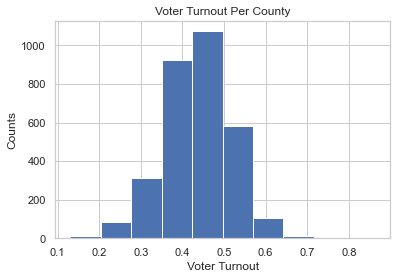

In [7]:
# Plotting histogram of voter turnout percentage per county 
plt.hist(data_train['Votes']/data_train['TOT_POP'])
plt.title("Voter Turnout Per County")
plt.xlabel("Voter Turnout")
plt.ylabel("Counts")
plt.show()

## EDA on Response Variables

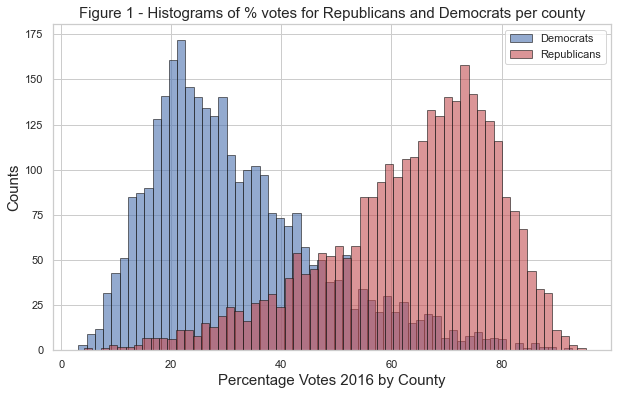

In [8]:
# Intializing plot
plt.figure(figsize=(10,6))

# Plotting histograms 
plt.hist(data_train['Democrats 2016'], bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train['Republicans 2016'], bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Percentage Votes 2016 by County', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 1 - Histograms of % votes for Republicans and Democrats per county', fontsize=15)

# Setting legend
plt.legend()

plt.show()

Figure 1 - Histograms of % votes for Republicans and Democrats per county

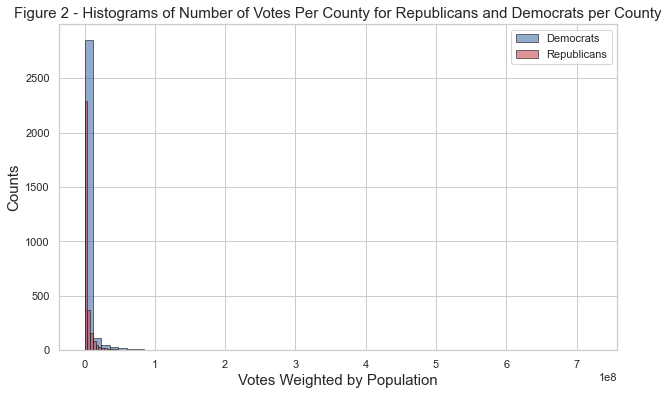

In [9]:
# Initialzing plot
plt.figure(figsize=(10,6))

# Plotting histogram
plt.hist(data_train['response_dem'], bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train['response_rep'], bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Votes Weighted by Population', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 2 - Histograms of Number of Votes Per County for Republicans and Democrats per County', fontsize=15)

# Setting legend
plt.legend()
plt.show()

Figure 2 - Histograms of Number of Votes Per County for Republicans and Democrats per County

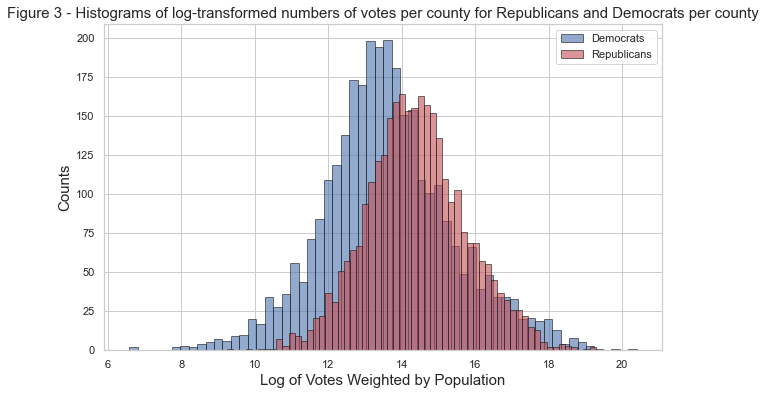

In [10]:
# Initialzing plot
plt.figure(figsize=(10,6))

# Plotting histogram
plt.hist(data_train['log_response_dem'], bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train['log_response_rep'], bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Log of Votes Weighted by Population', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 3 - Histograms of log-transformed numbers of votes per county for Republicans and Democrats per county', fontsize=15)

# Setting legend
plt.legend()
plt.show()

Figure 3 - Histograms of log-transformed numbers of votes per county for Republicans and Democrats per county

## EDA on Predictors
### Voters Consistency 

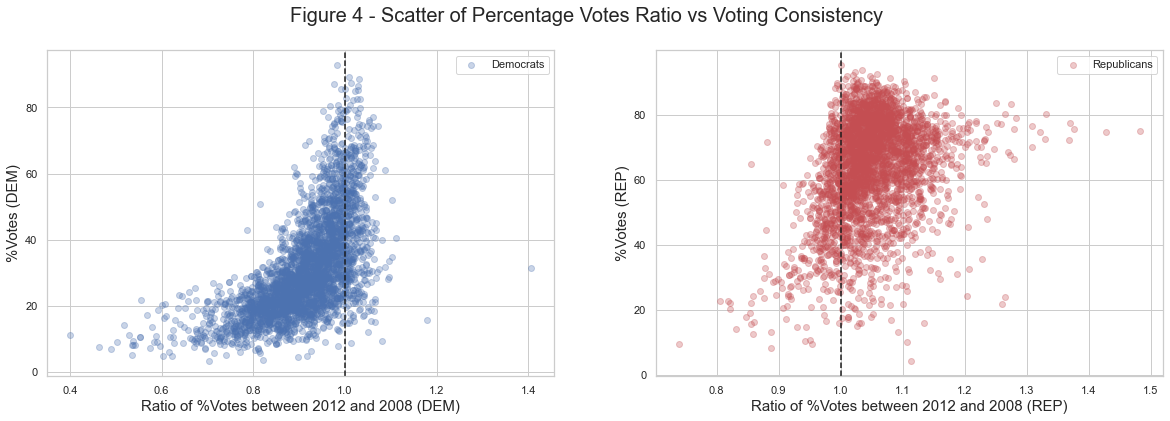

In [11]:
# Now, we are dealing with both 'lag_response_dem' and 'lag_response_rep' variables.
# Figure 3 - Histogram of Percentage Votes Ratio between 2012 and 2008 for Both Parties
# Initialzing plot
fig, ax = plt.subplots(1, 2, figsize=(20,6))

# Plotting histogram
ax[0].scatter(data_train.lag_response_dem, data_train['Democrats 2016'], alpha=0.3, 
              color='b', label='Democrats')
ax[0].axvline(x=1.0, ymin=0, ymax=100, linestyle='--', color='k')
ax[0].set_xlabel('Ratio of %Votes between 2012 and 2008 (DEM)', fontsize=15)
ax[0].set_ylabel("%Votes (DEM)", fontsize=15)
ax[0].legend()

ax[1].scatter(data_train.lag_response_rep, data_train['Republicans 2016'], alpha=0.3, 
              color='r', label='Republicans')
ax[1].axvline(x=1.0, ymin=0, ymax=100, linestyle='--', color='k')
ax[1].set_xlabel('Ratio of %Votes between 2012 and 2008 (REP)', fontsize=15)
ax[1].set_ylabel("%Votes (REP)", fontsize=15)
ax[1].legend()
# Setting labels
plt.suptitle('Figure 4 - Scatter of Percentage Votes Ratio vs Voting Consistency', fontsize=20)
#plt.savefig("/Users/guanhuashu/Desktop/voting_consist")
# Setting legend
plt.show()

Figure 4 - Scatter of Percentage Votes Ratio vs Voting Consistency

This suggests that majorities of republican counties were presisting with their voting habbits.
However, a large proportion of democratican counties were not and shifted their voting habits,
moving to vote more for republicans in 2016. This makes sense as Trump won the election.

### Demographic and Business Data

In [12]:
# I will use train_merge.columns a bit later
# to get the column names of this
demographic_business=pd.concat([data_train.iloc[:, data_train.columns.get_loc('TOT_MALE'):data_train.columns.get_loc('NA_FEMALE')+1],
                       data_train.iloc[:, data_train.columns.get_loc('At Least High School Diploma'):data_train.columns.get_loc('School Enrollment')+1],
                       data_train.loc[:, 'Poverty Estimate, All Ages'],
                       data_train.loc[:, 'Median Household Income'],
                       data_train.iloc[:, data_train.columns.get_loc('NUI'):data_train.columns.get_loc('NIC')+1],
                       data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]], axis=1).drop('School Enrollment', axis = 1)

In [13]:
# Shape
print(f"The shape is: {demographic_business.shape}")

The shape is: (3139, 39)


In [14]:
# Defining correlation variable
demographic_business_cor=demographic_business.corr(method="pearson")

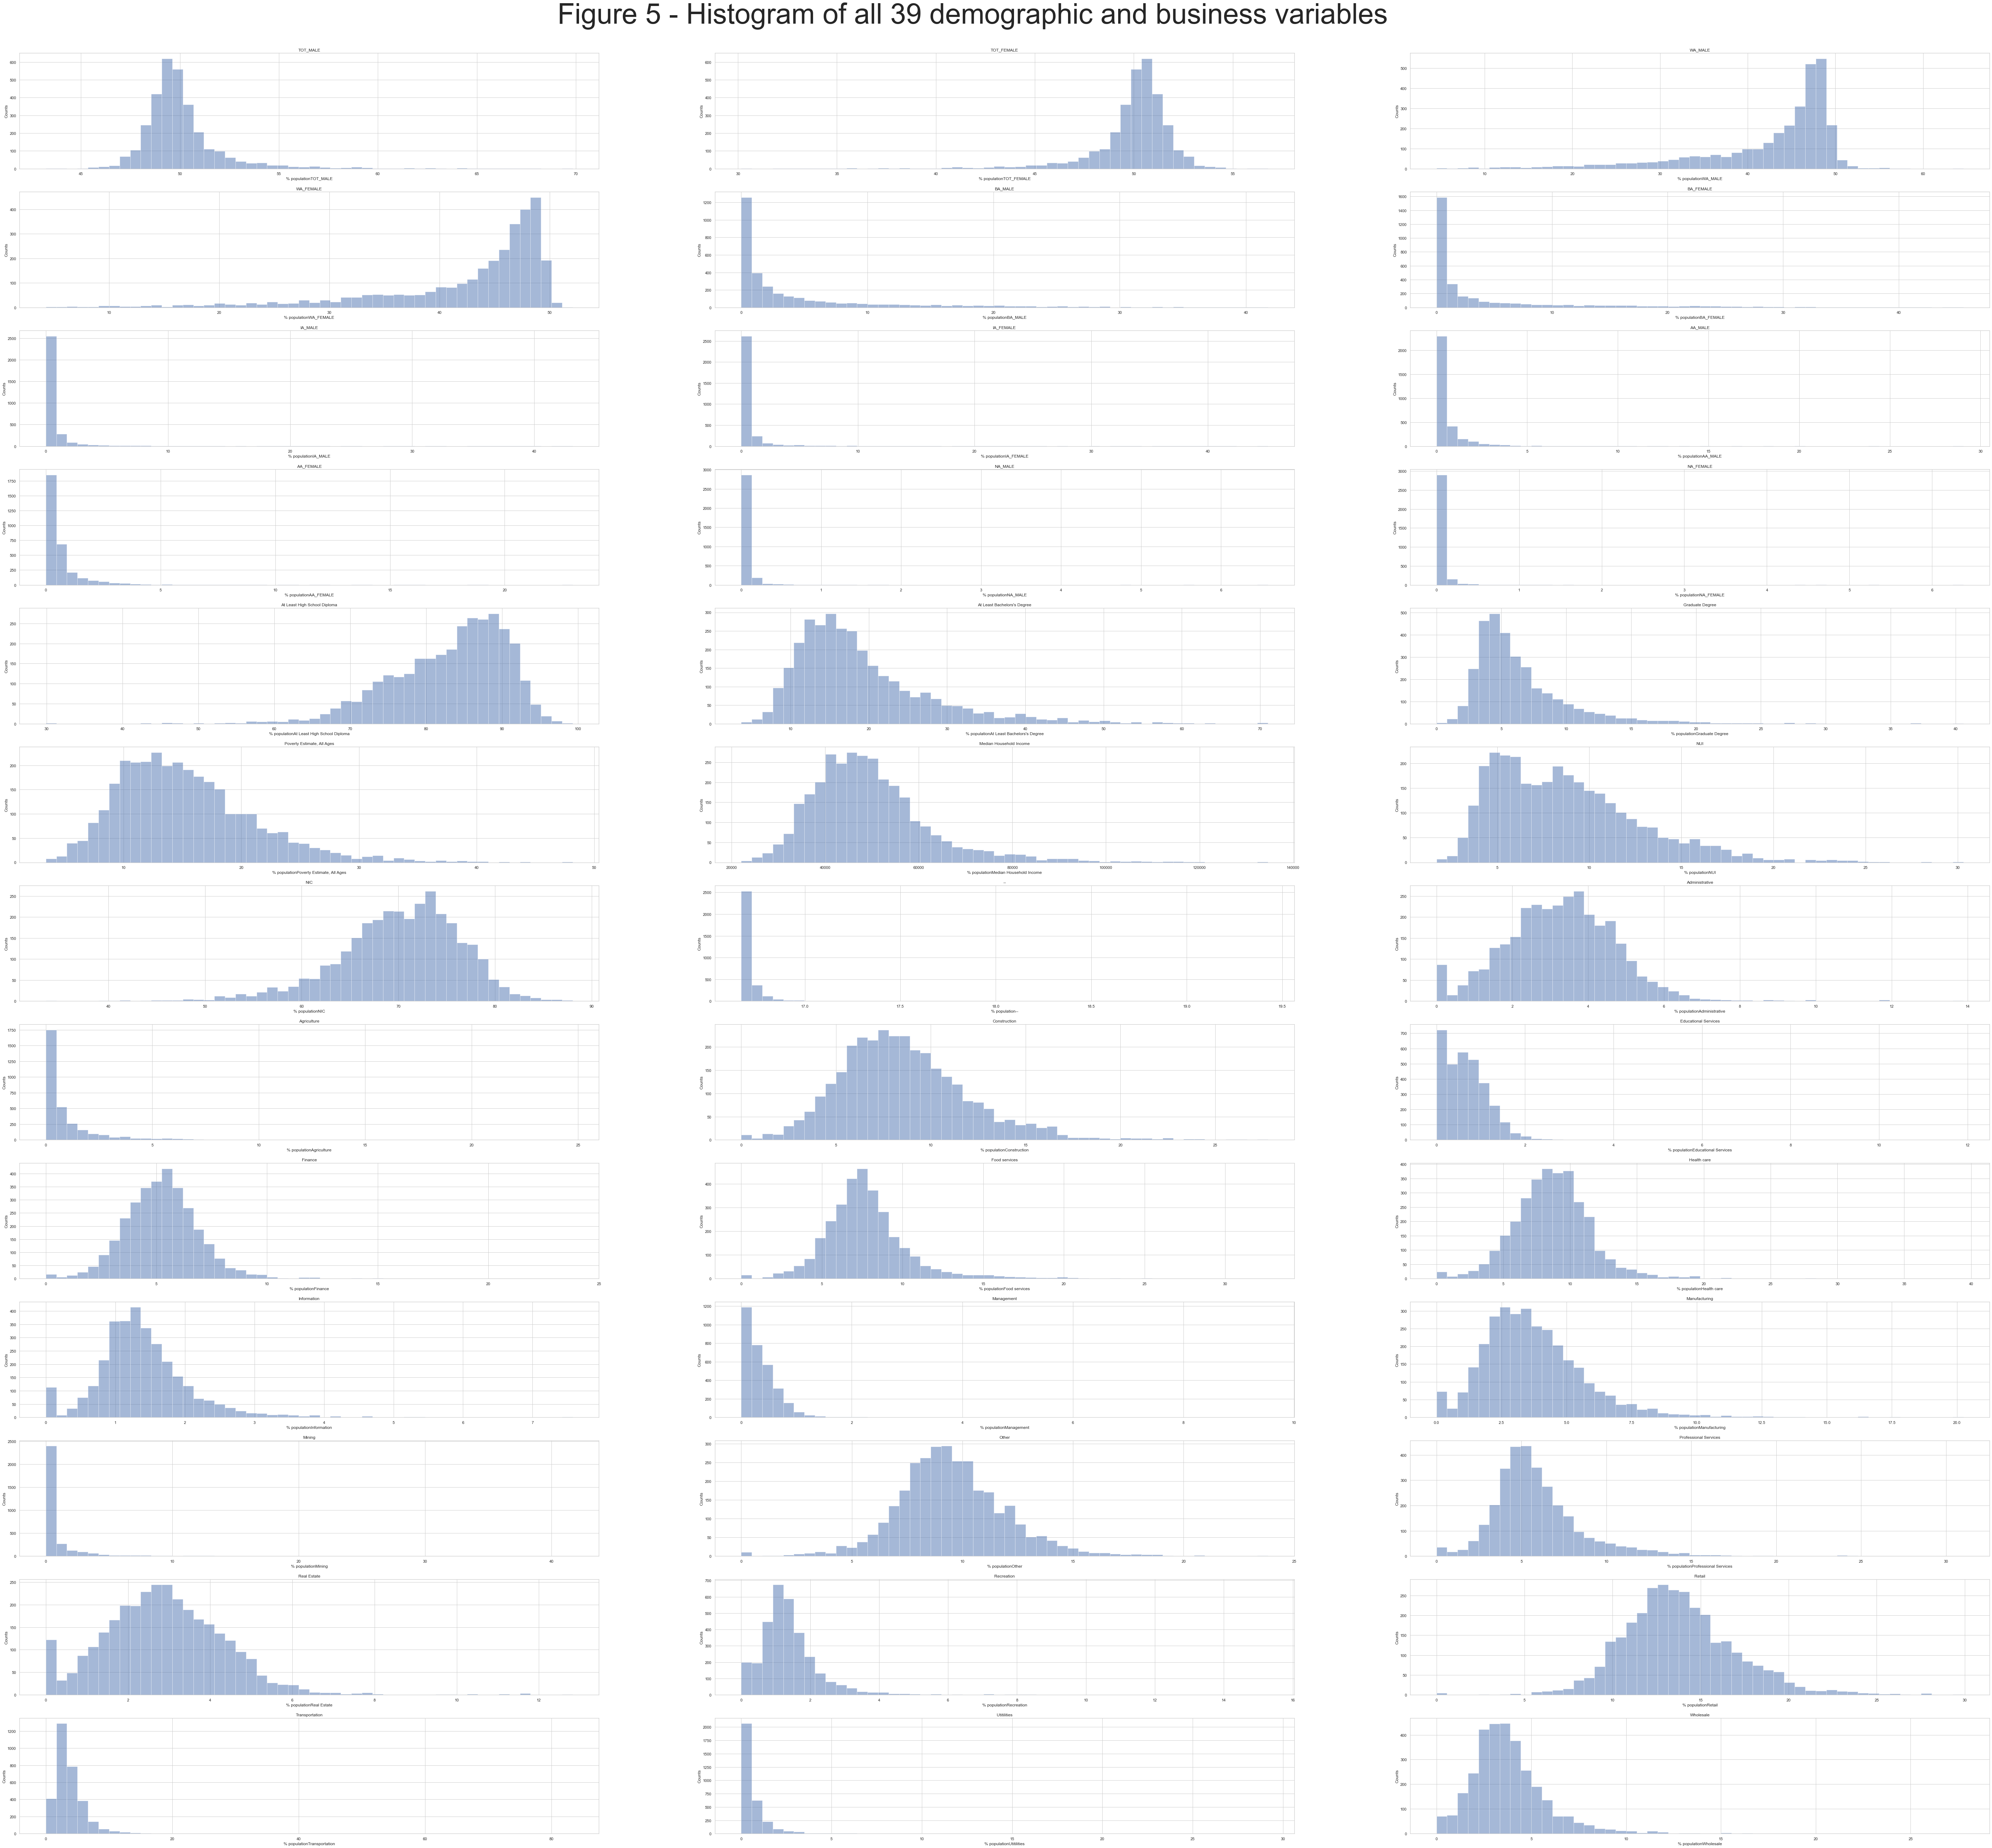

In [15]:
# Plotting percentage of votes against Business predictors and Demographic data
plt.figure(figsize=[100,100])

for i, col in enumerate(demographic_business.columns):
    plt.subplot(14, 3, i+1)
    plt.hist(x=( (demographic_business[col])), bins=50, alpha=0.5)
    plt.ylabel('Counts')
    plt.xlabel('% population' + col)
    plt.title(col)

plt.suptitle("Figure 5 - Histogram of all 39 demographic and business variables", y = .90, fontsize=80)
plt.show()

Figure 5 - Histogram of all 39 demographic and business variables

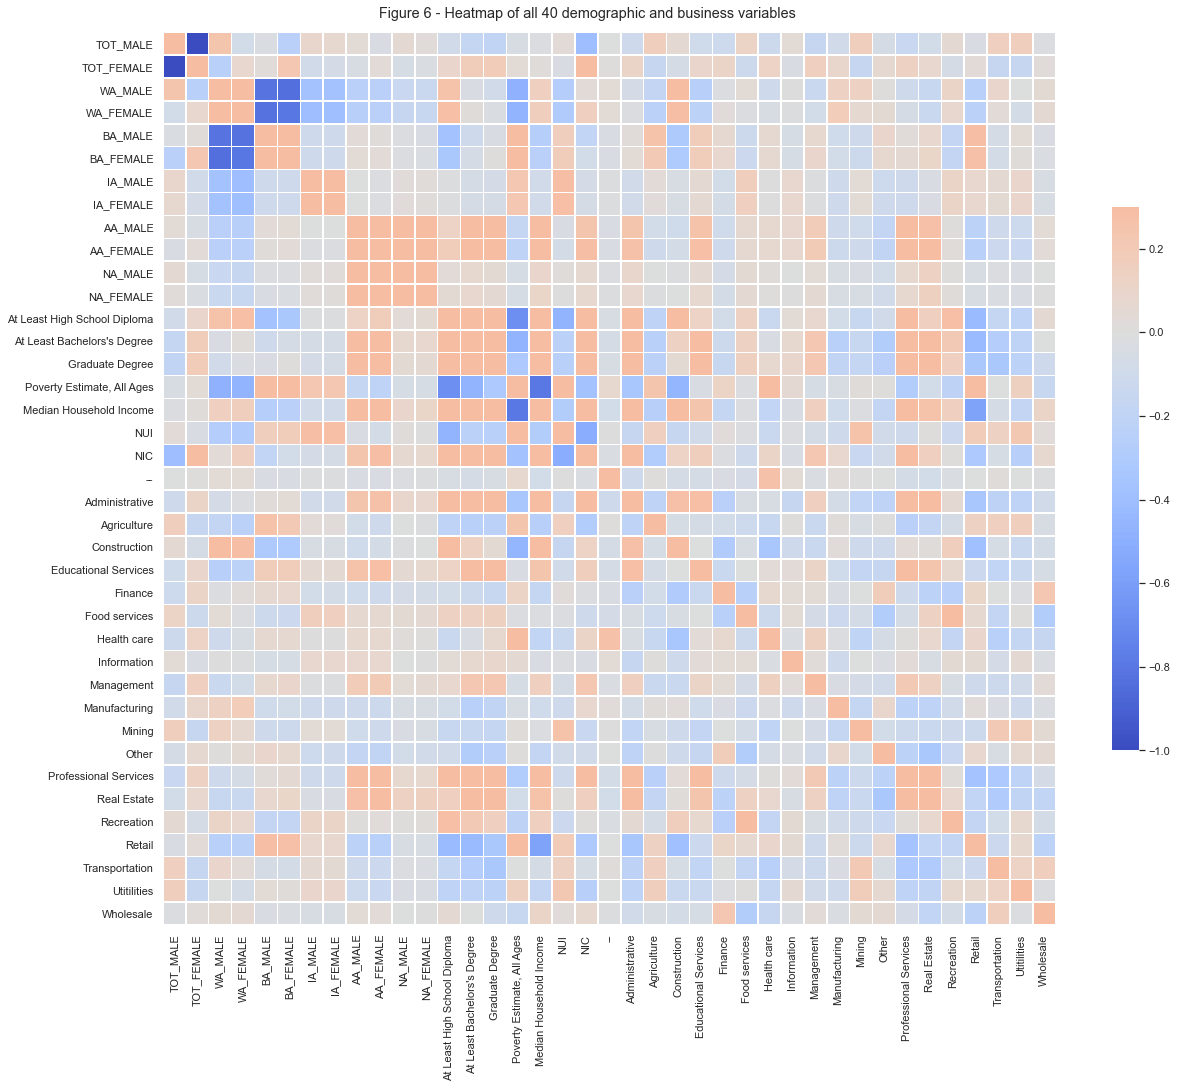

In [16]:
# Plotting a correlation heat map with demographic data dand business data
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(demographic_business_cor, cmap="coolwarm",vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.suptitle("Figure 6 - Heatmap of all 40 demographic and business variables", x=.42, y=.83)
plt.show()

There is not much correlation among variables thus less concern for problems of collinearity  

Figure 6 - Heatmap of all 40 demographic and business variables

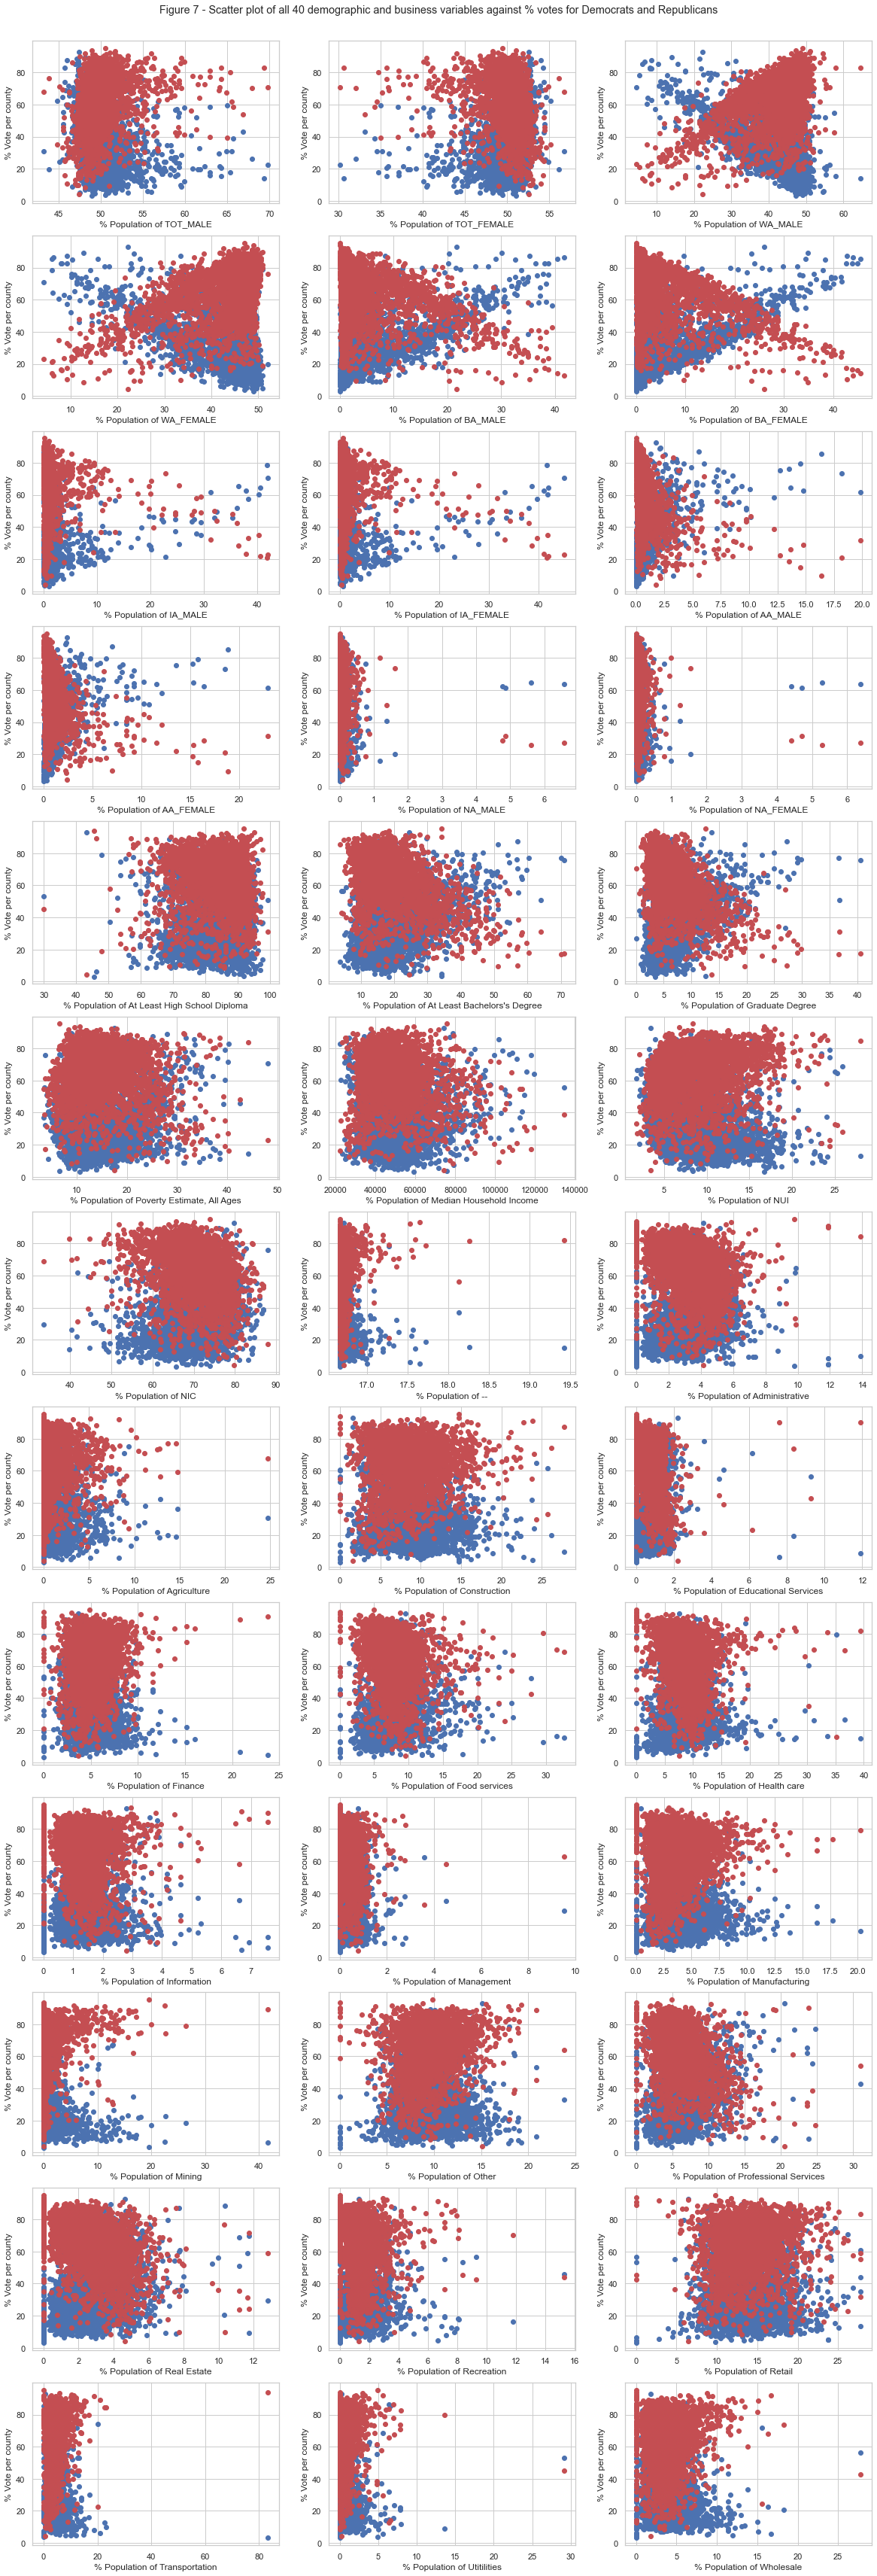

In [17]:
###Regression to election outcome 2016 
plt.figure(figsize=[20,66])

for i, col in enumerate(demographic_business.columns):
    plt.subplot(14, 3, i+1)
    plt.scatter(y=data_train['Democrats 2016'], x=(demographic_business[col]) ,color='b')
    plt.scatter(y=data_train['Republicans 2016'], x=(demographic_business[col]),color='r' )
    plt.xlabel('% Population of ' + col)
    plt.ylabel('% Vote per county')

plt.suptitle("Figure 7 - Scatter plot of all 40 demographic and business variables against % votes for Democrats and Republicans", y = .89)
plt.show()

Figure 7 - Scatter plot of all 40 demographic and business variables against % votes for Democrats and Republicans

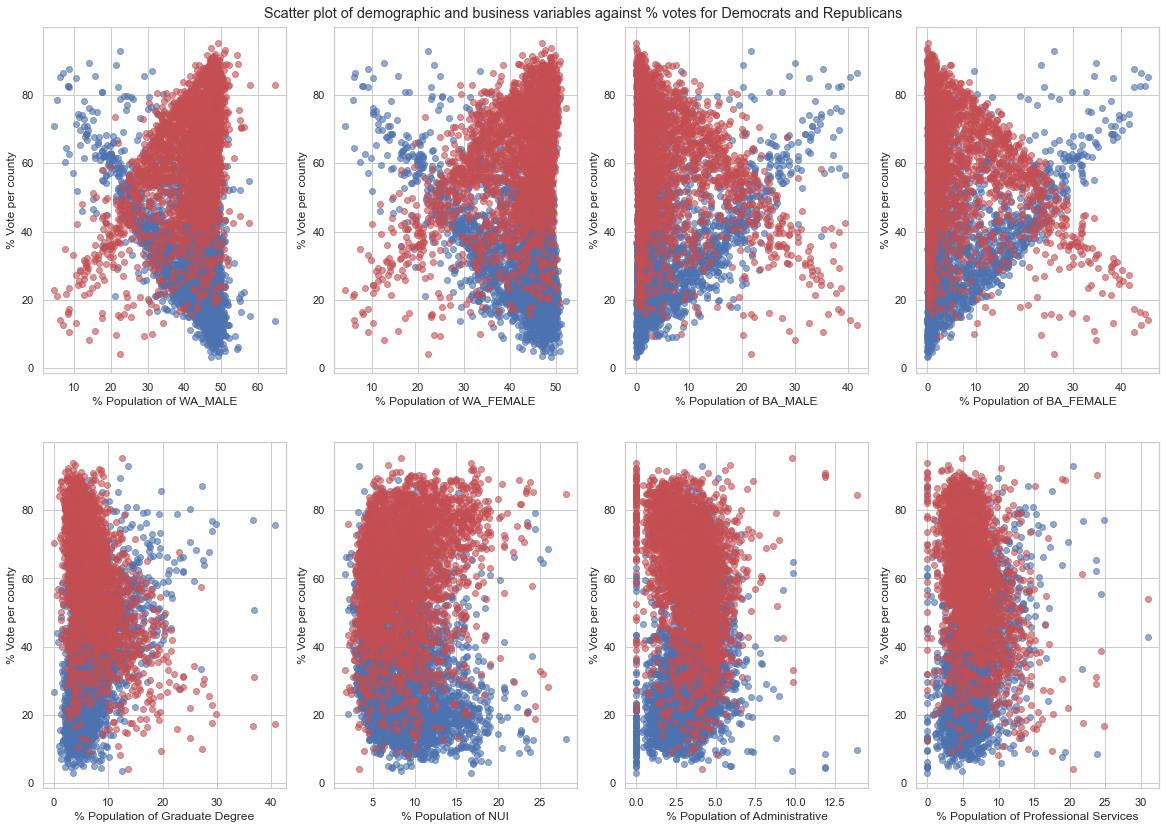

In [18]:
# select a few of them used for documentation
choose=['WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'Graduate Degree', 'NUI','Administrative','Professional Services']

plt.figure(figsize=[20,14])

for i, col in enumerate(choose):
    plt.subplot(2, 4, i+1)
    plt.scatter(y=data_train['Democrats 2016'], x=(demographic_business[col]) ,color='b', alpha=0.6)
    plt.scatter(y=data_train['Republicans 2016'], x=(demographic_business[col]),color='r' , alpha=0.6)
    plt.xlabel('% Population of ' + col)
    plt.ylabel('% Vote per county')

plt.savefig("demo.png")
plt.suptitle("Scatter plot of demographic and business variables against % votes for Democrats and Republicans", y = 0.9)
plt.show()


In [19]:
#plt.savefig("demographic.png")

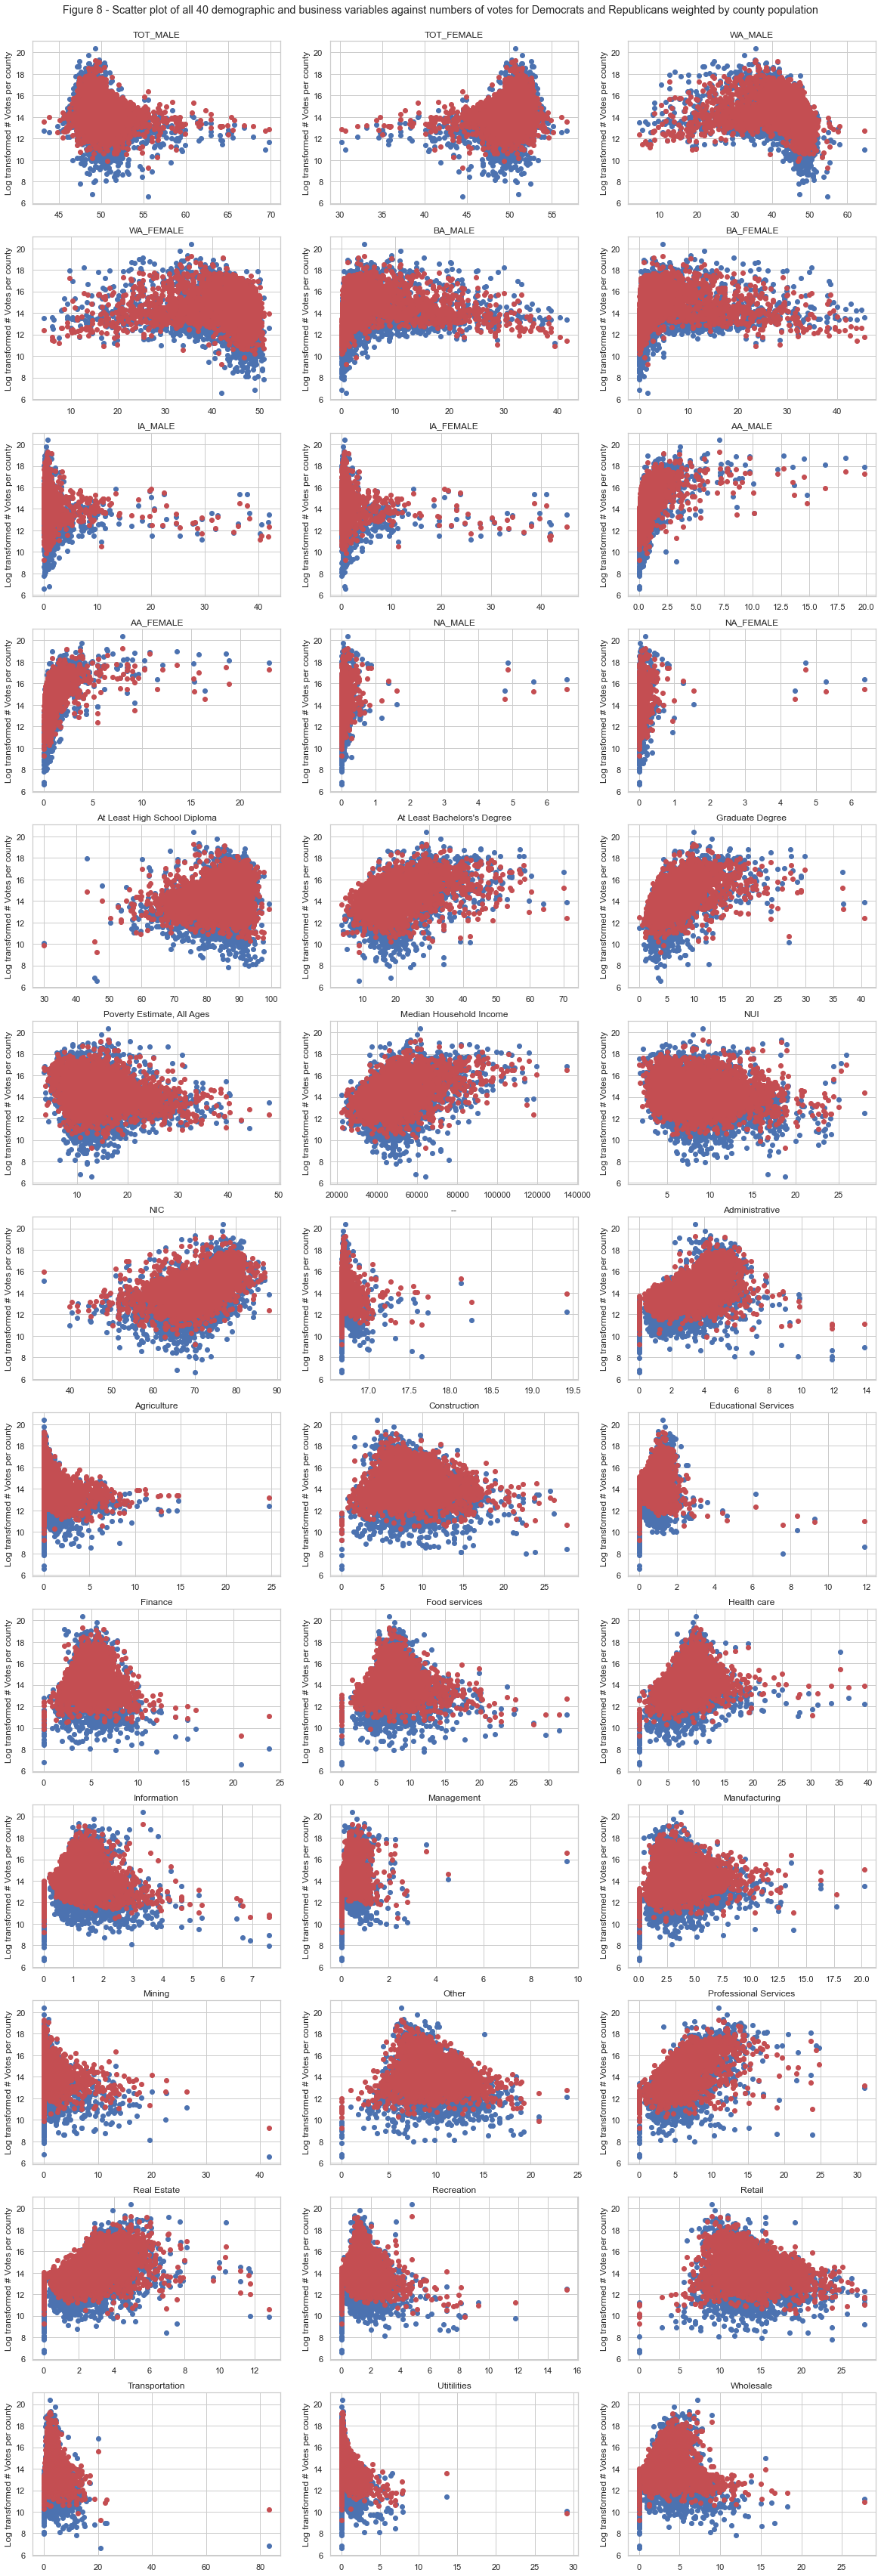

In [20]:
###correlation with # votes 

plt.figure(figsize=[20,66])

for i, col in enumerate(demographic_business.columns):
    plt.subplot(14, 3, i+1)
    plt.scatter(y=np.log(data_train['response_dem']), x=(demographic_business[col]) ,color='b')
    plt.scatter(y=np.log(data_train['response_rep']), x=(demographic_business[col]),color='r' )
    plt.ylabel('Log transformed # Votes per county')
    plt.title(col)

plt.suptitle("Figure 8 - Scatter plot of all 40 demographic and business variables against numbers of votes for Democrats and Republicans weighted by county population", y=.89)

plt.show()

Figure 8 - Scatter plot of all 40 demographic and business variables against numbers of votes for Democrats and Republicans weighted by county population

### House of Representatives Financial Data

In [21]:
# Finance
finance=data_train.iloc[:, data_train.columns.get_loc('house_rep_receipts'):data_train.columns.get_loc('house_dem_cash_on_hand')+1]
finance.shape


(3139, 6)

In [22]:
# Describing the data
finance.describe()

house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand
count        3.139000e+03        3.139000e+03            3.139000e+03        3.139000e+03        3.139000e+03            3.139000e+03
mean         1.576236e+07        1.493184e+07            4.196804e+06        9.709655e+06        8.698864e+06            2.700840e+06
std          1.352539e+07        1.308636e+07            4.149659e+06        1.414240e+07        1.268135e+07            4.299082e+06
min          0.000000e+00        0.000000e+00           -3.896720e+03        3.766634e+04        2.882283e+04            0.000000e+00
25%          6.117663e+06        6.041473e+06            1.070736e+06        1.438342e+06        1.248608e+06            3.838517e+05
50%          1.384217e+07        1.295522e+07            2.794079e+06        4.405427e+06        3.979693e+06            9.883107e+05
75%          1.961964e+07        1.822542e+07            5.245551e+06        1.379829e+07        1.018831e+07            3.211977e+06
max          4.726561e+07        4.822634e+07            1.391429e+07        8.116243e+07        7.071228e+07            2.616824e+07

In [23]:
# Dipslaying the info
finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   house_rep_receipts      3139 non-null   float64
 1   house_rep_disburse      3139 non-null   float64
 2   house_rep_cash_on_hand  3139 non-null   float64
 3   house_dem_receipts      3139 non-null   float64
 4   house_dem_disburse      3139 non-null   float64
 5   house_dem_cash_on_hand  3139 non-null   float64
dtypes: float64(6)
memory usage: 147.3 KB


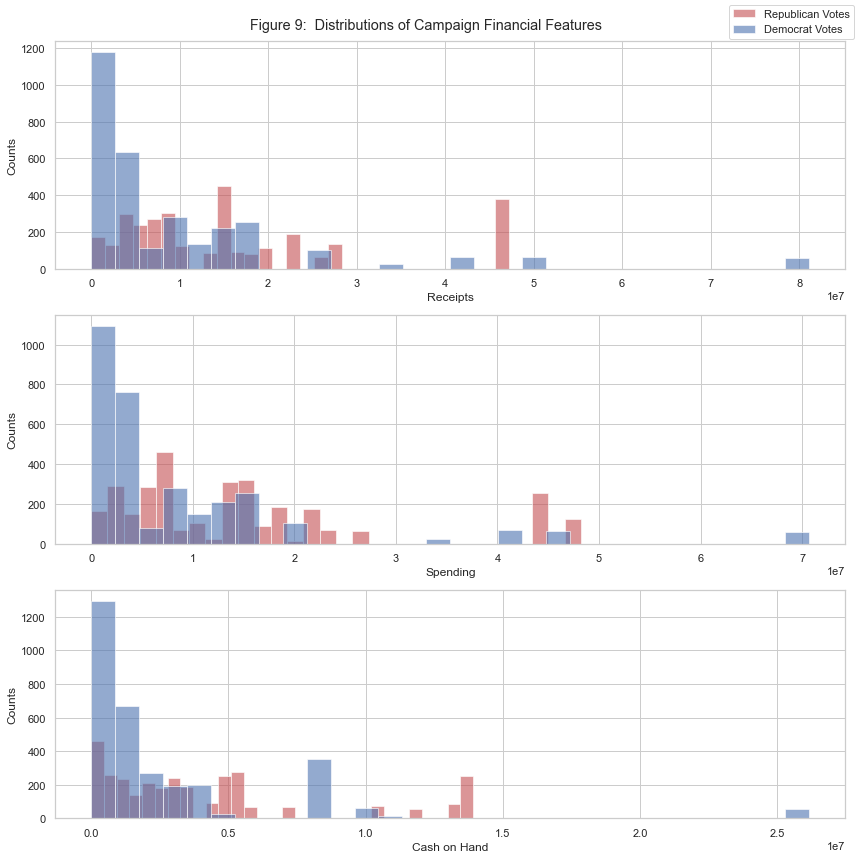

In [24]:
# Setting lists
dem_finance = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand']
rep_finance = ['house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
names_finance = ['Receipts', "Spending", 'Cash on Hand']

# Initializing the subplots
fig, ax  = plt.subplots(nrows= 3, figsize=(12,12))

# Setting counters
r = 0

# Plotting
for rep, dem, n in zip(rep_finance, dem_finance, names_finance):
    if rep == 'house_rep_receipts' and dem == 'house_dem_receipts':
        ax[r].hist(data_train[rep], bins = 30, color = 'r', alpha = .6, label = 'Republican Votes')
        ax[r].hist(data_train[dem], bins = 30, color = 'b', alpha = .6, label = 'Democrat Votes')
        ax[r].set_xlabel(n)
        ax[r].set_ylabel('Counts')
        r+=1
    else:
        ax[r].hist(data_train[rep], bins = 30, color = 'r', alpha = .6)
        ax[r].hist(data_train[dem], bins = 30, color = 'b', alpha = .6)
        ax[r].set_xlabel(n)
        ax[r].set_ylabel('Counts')
        r+=1

# Setting legend
fig.legend(loc='upper right')

# Setting the super title
fig.suptitle("Figure 9:  Distributions of Campaign Financial Features")

# Making the layout tighter
fig.tight_layout()

plt.show()


Figure 9:  Distributions of Campaign Financial Features

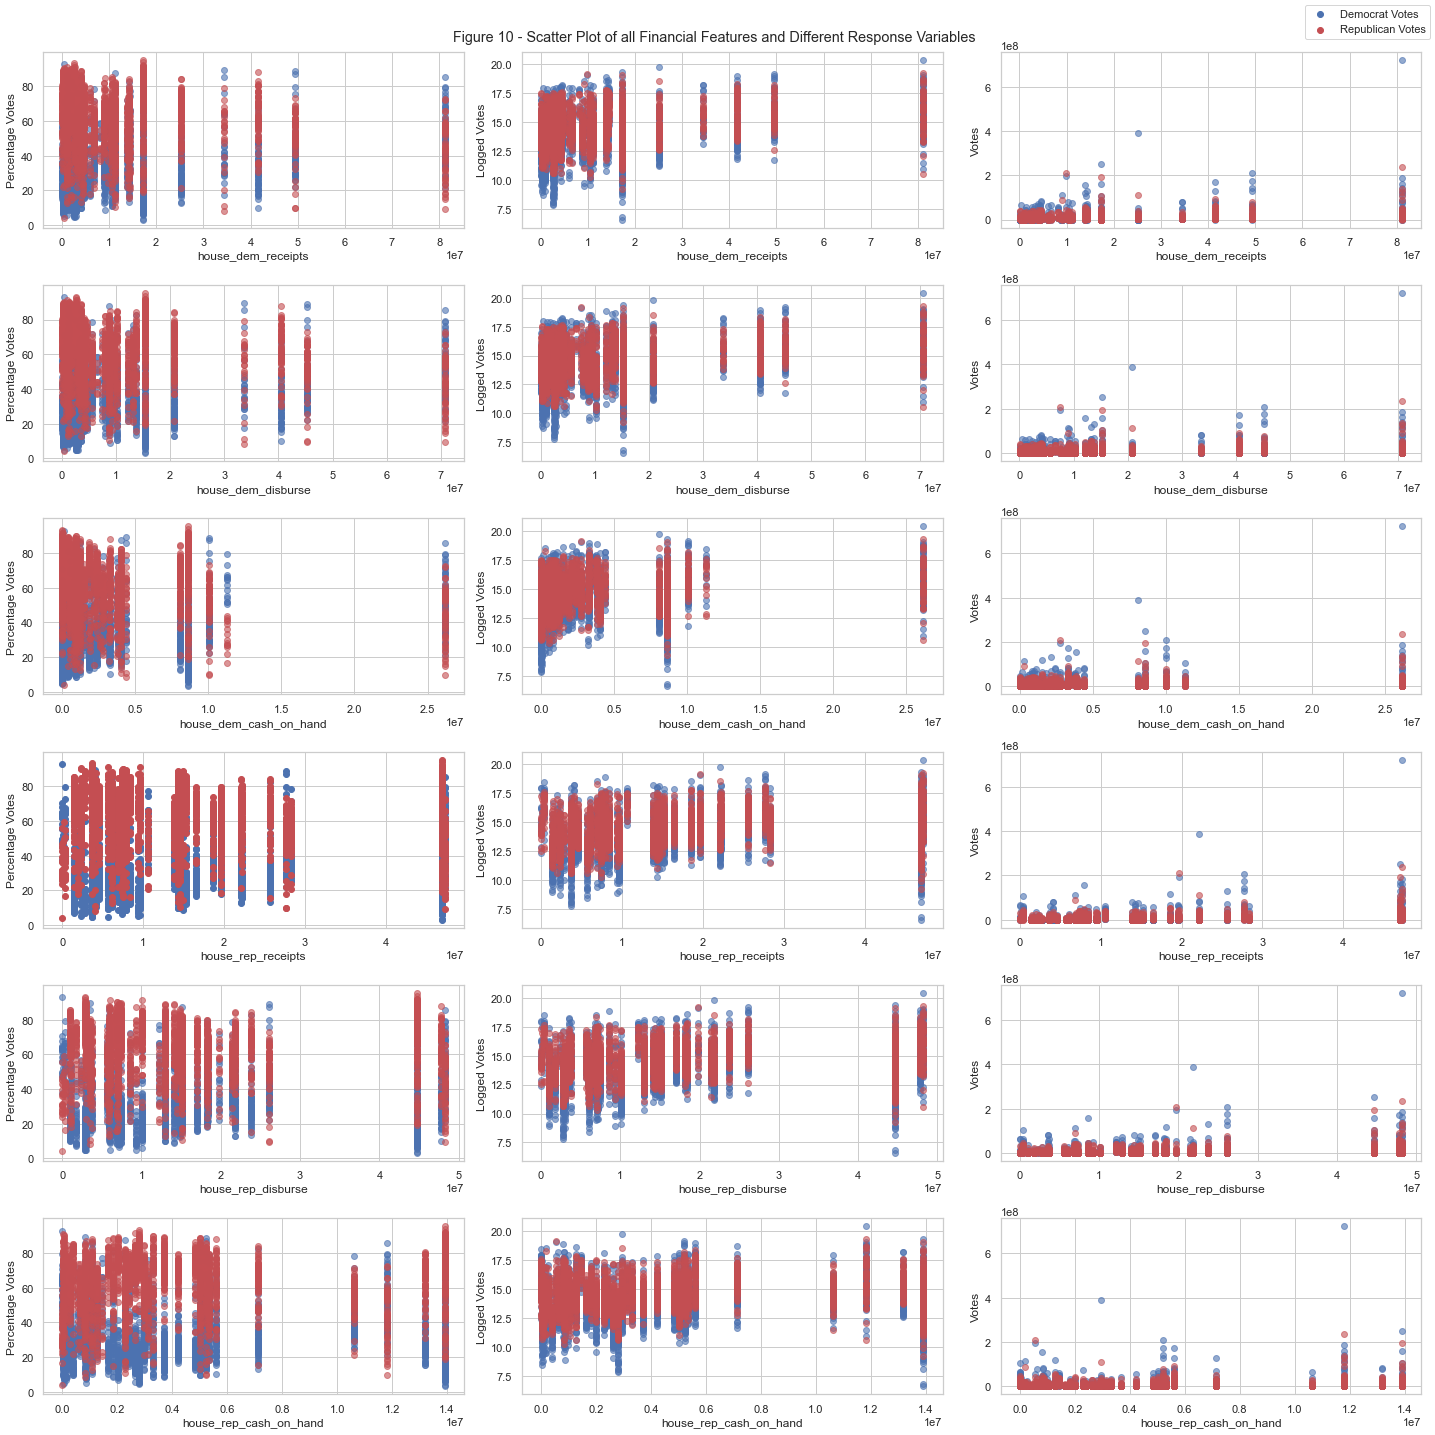

In [25]:
# Setting lists needed for the plotting
finance_list = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand', 'house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
y_dem = ['Democrats 2016', 'log_response_dem', 'response_dem']
y_rep = ['Republicans 2016', 'log_response_rep', 'response_rep']
names_response = ['Percentage Votes', 'Logged Votes', 'Votes']


# Intializing the subplots
fig, ax  = plt.subplots(nrows= 6, ncols=3, figsize=(20,20))

# Setting counters
r = 0
c = 0 

# Looping through the finanical data, response variables, and names to create the graphs
for fin in finance_list:
    for a,b,n2 in zip(y_rep, y_dem, names_response):
    
        if fin == "house_rep_receipts" and a == "Republicans 2016":

            ax[r,c].scatter(y=data_train[b], x=finance[fin], color='b' , label = "Democrat Votes")
            ax[r,c].scatter(y=data_train[a], x=finance[fin], color='r', label = 'Republican Votes')
            ax[r,c].set_ylabel(n2)
            ax[r,c].set_xlabel(fin)

            

        else:
            ax[r,c].scatter(y=data_train[b], x=finance[fin], color='b' , alpha = .6)
            ax[r,c].scatter(y=data_train[a], x=finance[fin], color='r', alpha = .6)
            
            ax[r,c].set_ylabel(n2)
            ax[r,c].set_xlabel(fin)

        if c < 2:
            c += 1
        else:
            r+=1
            c=0
# Fitting legend
fig.legend(loc='upper right')

# Setting the super title
fig.suptitle("Figure 10 - Scatter Plot of all Financial Features and Different Response Variables")

# Making the layout tighter
fig.tight_layout()

plt.show()

Figure 10 - Scatter Plot of all Financial Features and Different Response Variables

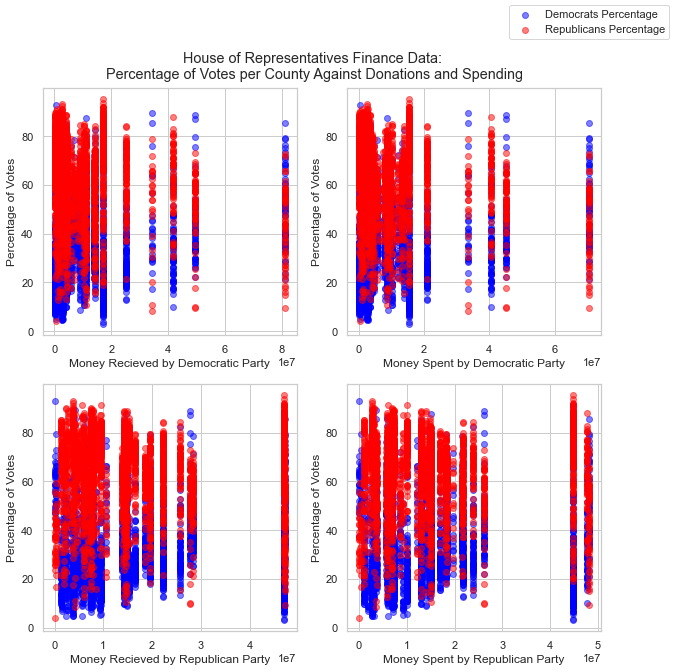

In [26]:
# Focusing on the house and republican spending on the percentage of votes
finance_list1 = ['house_dem_receipts', 'house_dem_disburse', 'house_rep_receipts', 'house_rep_disburse']
respone_plt_rep = ['Democrats 2016', 'Republicans 2016']
response_label = ['Money Recieved by Democratic Party', 'Money Spent by Democratic Party', 'Money Recieved by Republican Party', 'Money Spent by Republican Party']

fig, axes = plt.subplots(2,2, figsize=(10,10))

for ax, fin, name in zip(axes.flat, finance_list1, response_label):
    if fin == 'house_dem_receipts':

        ax.scatter(x=data_train[fin], y=data_train['Democrats 2016'], color = 'blue', alpha = .5, label='Democrats Percentage')
        ax.scatter(x=data_train[fin], y=data_train['Republicans 2016'], color = 'red', alpha = .5, label = 'Republicans Percentage')
        ax.set_xlabel(name)
        ax.set_ylabel("Percentage of Votes")

    else:

        ax.scatter(x=data_train[fin], y=data_train['Democrats 2016'], color = 'blue', alpha = .5)
        ax.scatter(x=data_train[fin], y=data_train['Republicans 2016'], color = 'red', alpha = .5)
        ax.set_xlabel(name)
        ax.set_ylabel("Percentage of Votes")
    
fig.legend()
fig.suptitle("House of Representatives Finance Data:\n Percentage of Votes per County Against Donations and Spending", y=.93)
plt.savefig('financial_data.png', dpi=300)



### Polling Data

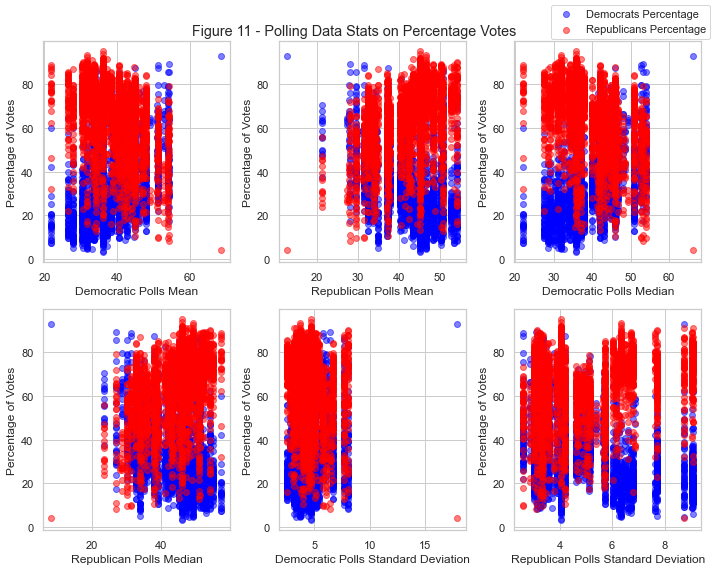

In [27]:
# Focusing on the house and republican spending on the percentage of votes
# Intializng lists
polls = ['dem_poll_mean', 'rep_poll_mean', 'dem_poll_median', 'rep_poll_median', 'dem_poll_sd', 'rep_poll_sd']
respone_plt_rep = ['Democrats 2016', 'Republicans 2016']
response_label = ['Democratic Polls Mean', 'Republican Polls Mean', 'Democratic Polls Median', 'Republican Polls Median', 'Democratic Polls Standard Deviation', 'Republican Polls Standard Deviation' ]

# Initlizing subplots
fig, axes = plt.subplots(2,3, figsize=(10,8))

# Graphing the plots
for ax, poll, name in zip(axes.flat, polls, response_label):
    if poll == 'dem_poll_mean':

        ax.scatter(x=data_train[poll], y=data_train['Democrats 2016'], color = 'blue', alpha = .5, label='Democrats Percentage')
        ax.scatter(x=data_train[poll], y=data_train['Republicans 2016'], color = 'red', alpha = .5, label = 'Republicans Percentage')
        ax.set_xlabel(name)
        ax.set_ylabel("Percentage of Votes")

    else:

        ax.scatter(x=data_train[poll], y=data_train['Democrats 2016'], color = 'blue', alpha = .5)
        ax.scatter(x=data_train[poll], y=data_train['Republicans 2016'], color = 'red', alpha = .5)
        ax.set_xlabel(name)
        ax.set_ylabel("Percentage of Votes")

# Fitting legends, super title, and saving 
fig.legend()
fig.suptitle("Figure 11 - Polling Data Stats on Percentage Votes", y=.96)
plt.tight_layout()
plt.savefig('polling_data.png', dpi=300)

Figure 11 - Polling Data Stats on Percentage Votes

### Economic Data - Unemployment Rate

In [28]:
## Ivan's EDA about Unemployment Rate:
## Here I am gonig to subset certian features
economic_df = data_train[['State', 'FIPS', 'County', 'Civilian_labor_force_2016', 'Employed_2016', 'Unemployed_2016', \
                    'Unemployment_rate_2016', 'lag_response_dem', 'lag_response_rep', \
                    'Democrats 2016', 'Republicans 2016']]

# make a copy to get rid of the warning:
economic_df = economic_df.copy()

In [29]:
# Printing head
economic_df.head()

State  FIPS            County  Civilian_labor_force_2016  Employed_2016  Unemployed_2016  Unemployment_rate_2016  lag_response_dem  lag_response_rep  Democrats 2016  Republicans 2016
0  Alabama  1005    Barbour County                  32.690072      29.977525         2.712547                     8.3          1.047921          0.955413       46.660250         52.271415
1  Alabama  1113    Russell County                  40.606686      38.363839         2.242846                     5.5          1.041426          0.951199       50.047032         48.129181
2  Alabama  1059   Franklin County                  44.047958      41.466578         2.581380                     5.9          0.982311          1.010399       18.377248         79.180259
3  Alabama  1117     Shelby County                  52.079685      49.849964         2.229721                     4.3          0.950167          1.010994       23.110031         73.427546
4  Alabama  1121  Talladega County                  43.394329      40.545238         2.849091                     6.6          1.032942          0.979507       36.450117         62.002529

In [30]:
# Describing Economic Data
economic_df.describe()

FIPS  Civilian_labor_force_2016  Employed_2016  Unemployed_2016  Unemployment_rate_2016  lag_response_dem  lag_response_rep  Democrats 2016  Republicans 2016
count   3139.000000                3139.000000    3139.000000      3139.000000             3139.000000       3111.000000       3111.000000     3111.000000       3111.000000
mean   30392.532972                  47.015810      44.641093         2.374717                5.237910          0.912372          1.049337       31.679286         63.608655
std    15156.298611                   7.135855       7.346914         0.655890                1.889084          0.089682          0.060200       15.325975         15.619852
min     1001.000000                  20.453867      18.761819         0.946074                1.700000          0.400455          0.739058        3.144654          4.122067
25%    18180.000000                  42.407666      39.913775         1.975477                4.000000          0.863562          1.013689       20.445081         54.947224
50%    29177.000000                  47.169444      44.709569         2.300401                4.900000          0.925802          1.043300       28.461992         66.715489
75%    45080.000000                  51.695908      49.574546         2.691777                6.100000          0.976523          1.081089       39.948068         75.056740
max    56045.000000                 106.823821     104.590571        10.069986               24.100000          1.406163          1.482210       92.846592         95.272727

In [31]:
# Getting Info
economic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      3139 non-null   object 
 1   FIPS                       3139 non-null   int64  
 2   County                     3139 non-null   object 
 3   Civilian_labor_force_2016  3139 non-null   float64
 4   Employed_2016              3139 non-null   float64
 5   Unemployed_2016            3139 non-null   float64
 6   Unemployment_rate_2016     3139 non-null   float64
 7   lag_response_dem           3111 non-null   float64
 8   lag_response_rep           3111 non-null   float64
 9   Democrats 2016             3111 non-null   float64
 10  Republicans 2016           3111 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 269.9+ KB


In [32]:
# Check rows that have null values
has_null = economic_df.isnull()
row_null = has_null.any(axis=1)

economic_null_row = economic_df[row_null]
economic_null_row.head()

## Found that there are many Alaska are missing republican's and demorates 2016 data
## So we are going to drop them for now.

State  FIPS                      County  Civilian_labor_force_2016  Employed_2016  Unemployed_2016  Unemployment_rate_2016  lag_response_dem  lag_response_rep  Democrats 2016  Republicans 2016
67  Alaska  2130   Ketchikan Gateway Borough                  51.178230      47.844167         3.334063                     6.5               NaN               NaN             NaN               NaN
68  Alaska  2170   Matanuska-Susitna Borough                  45.477771      41.735898         3.741872                     8.2               NaN               NaN             NaN               NaN
69  Alaska  2016  Aleutians West Census Area                  69.658195      67.344435         2.313760                     3.3               NaN               NaN             NaN               NaN
70  Alaska  2195          Petersburg Borough                  44.447853      40.429448         4.018405                     9.0               NaN               NaN             NaN               NaN
71  Alaska  2110     Juneau City and Borough                  53.424658      51.030483         2.394175                     4.5               NaN               NaN             NaN               NaN

In [33]:
economic_updated_df = economic_df.dropna()
economic_updated_df_c = economic_updated_df.copy()

In [34]:
economic_updated_df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3111 entries, 0 to 3138
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State                      3111 non-null   object 
 1   FIPS                       3111 non-null   int64  
 2   County                     3111 non-null   object 
 3   Civilian_labor_force_2016  3111 non-null   float64
 4   Employed_2016              3111 non-null   float64
 5   Unemployed_2016            3111 non-null   float64
 6   Unemployment_rate_2016     3111 non-null   float64
 7   lag_response_dem           3111 non-null   float64
 8   lag_response_rep           3111 non-null   float64
 9   Democrats 2016             3111 non-null   float64
 10  Republicans 2016           3111 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 291.7+ KB


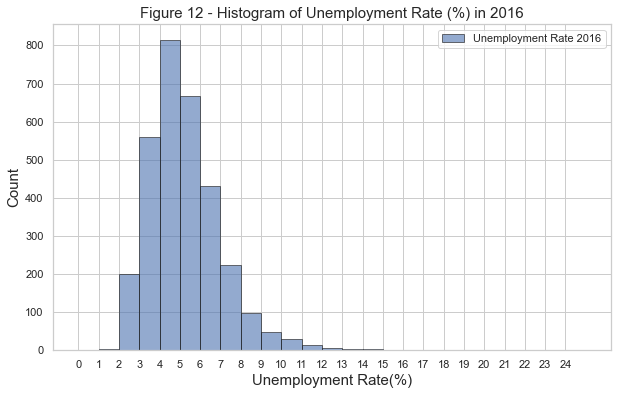

The mean of 2016 Unemployment Rate is 5.20


In [35]:
# First we are dealing with unemployment rate varaible
# make histogram for 'unemployment_rate_2016'
plt.figure(figsize=(10, 6))
plt.hist(economic_updated_df_c.Unemployment_rate_2016, bins=range(26), edgecolor='k', alpha=0.6,
        label='Unemployment Rate 2016')
# plt.hist(test_df.Unemployed_2019, bins=range(26), edgecolor='k', alpha=0.6, 
#          label= 'Unemployment Rate 2019-2020')

plt.ylabel('Count', fontsize=15)
plt.xlabel('Unemployment Rate(%)', fontsize=15)

plt.xticks(np.arange(25))
plt.title('Figure 12 - Histogram of Unemployment Rate (%) in 2016', fontsize=15)

plt.legend()
plt.show()

print("The mean of 2016 Unemployment Rate is {:.2f}".format(economic_updated_df_c.Unemployment_rate_2016.mean()))


Figure 12 - Histogram of Unemployment Rate (%) in 2016

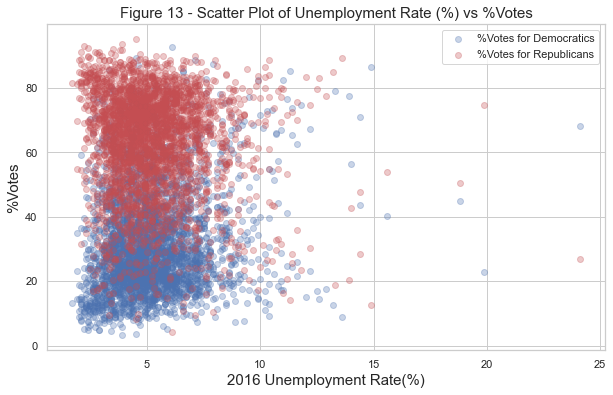

In [36]:
# make scatter plot of unemployment rate vs resposne_dem and response_rep
plt.figure(figsize=(10, 6))

plt.scatter(economic_updated_df_c.Unemployment_rate_2016, economic_updated_df_c['Democrats 2016'], color='b', 
            alpha=0.3, label="%Votes for Democratics")
plt.scatter(economic_updated_df_c.Unemployment_rate_2016, economic_updated_df_c['Republicans 2016'], color='r',
            alpha=0.3, label='%Votes for Republicans')

plt.xlabel('2016 Unemployment Rate(%)', fontsize=15)
plt.ylabel(r'%Votes', fontsize=15)
plt.title('Figure 13 - Scatter Plot of Unemployment Rate (%) vs %Votes', fontsize=15)

plt.legend()
#plt.savefig('/Users/guanhuashu/Desktop/scatter_unem')
plt.show()

Figure 13 - Scatter Plot of Unemployment Rate (%) vs %Votes

### Voter Accessibility

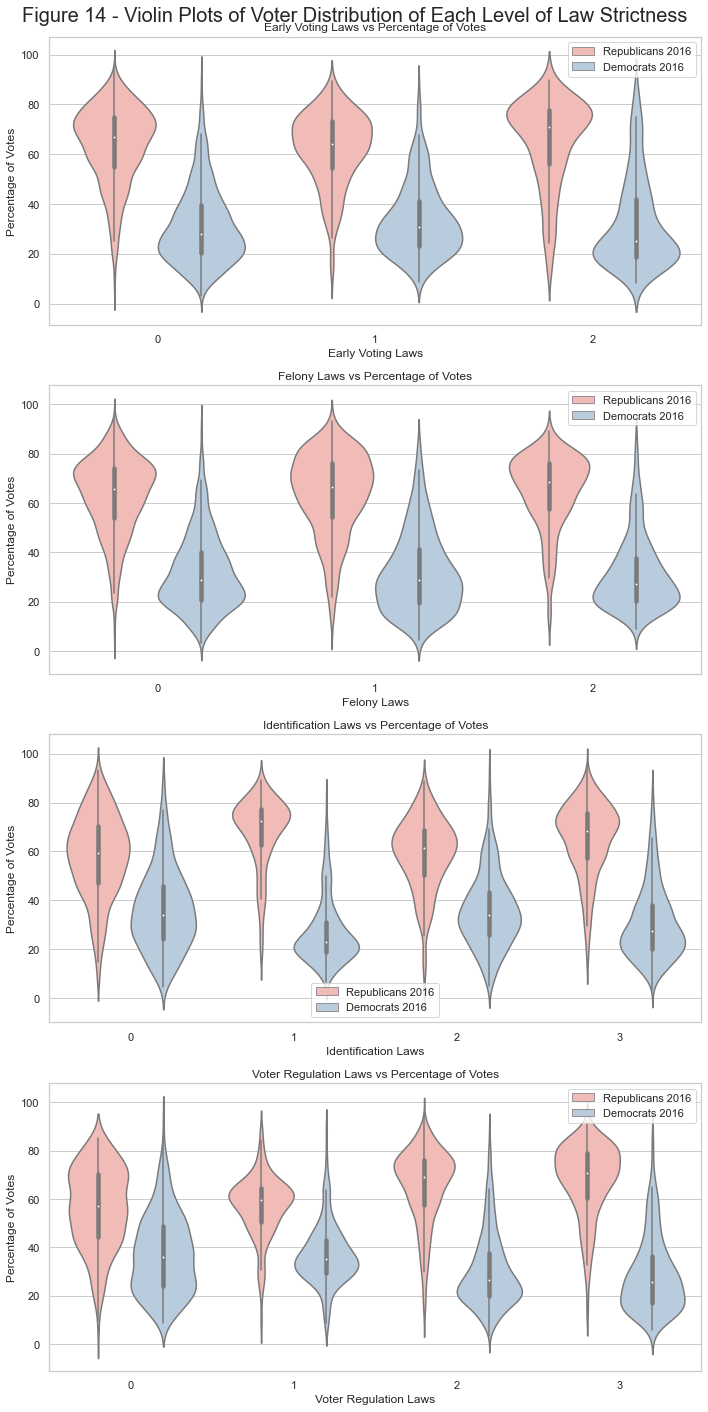

In [37]:
nums = (['Republicans 2016'] * 3139) + (['Democrats 2016'] * 3139)

percvotes = data_train['Republicans 2016'].append(data_train['Democrats 2016'])
# test2 = data_train['early_voting'].append(data_train['early_voting'])

vplotdf = pd.DataFrame()

vplotdf['party'] = nums
vplotdf['percvotes'] = percvotes.values
# vplotdf['early_voting'] = test2.values

laws = ['early_voting', 'felony_laws', 'id_laws', 'reg_laws']
xlabels = ['Early Voting Laws', 'Felony Laws', 'Identification Laws', 'Voter Regulation Laws']

for i in laws:
    vplotdf[i] = data_train[i].append(data_train[i]).values

fig, axes = plt.subplots(4, 1, figsize = (10, 20))

for j in range(4):
    sns.violinplot(ax = axes[j], x=laws[j], y='percvotes', hue="party", data=vplotdf, palette='Pastel1')  
    axes[j].set_xlabel(xlabels[j])
    axes[j].set_ylabel('Percentage of Votes')
    axes[j].set_title(xlabels[j] + ' vs Percentage of Votes')
    axes[j].legend() 
        
plt.suptitle('Figure 14 - Violin Plots of Voter Distribution of Each Level of Law Strictness', fontsize = 20)
plt.tight_layout()
plt.show()

Figure 14 - Violin Plots of Voter Distribution of Each Level of Law Strictness

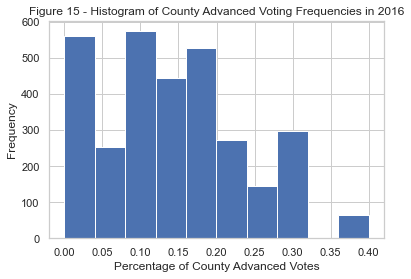

In [38]:
# violin plots of early voting law data
# plot against republican vote count, logged republic vote count, and percentage of republican votes by county
plt.hist(data_train['perc_adv'])
plt.title('Figure 15 - Histogram of County Advanced Voting Frequencies in 2016')
plt.xlabel('Percentage of County Advanced Votes')
plt.ylabel('Frequency')
plt.show()

Figure 15 - Histogram of County Advanced Voting Frequencies in 2016

### A Brief look at the Correlation Between All Features

In [39]:
# Subsetting for the relevant features
voting = data_train[laws]
economics = economic_df.drop(['State', 'FIPS', 'County', 'lag_response_dem', 'lag_response_rep', 'Democrats 2016', 'Republicans 2016'], axis = 1)

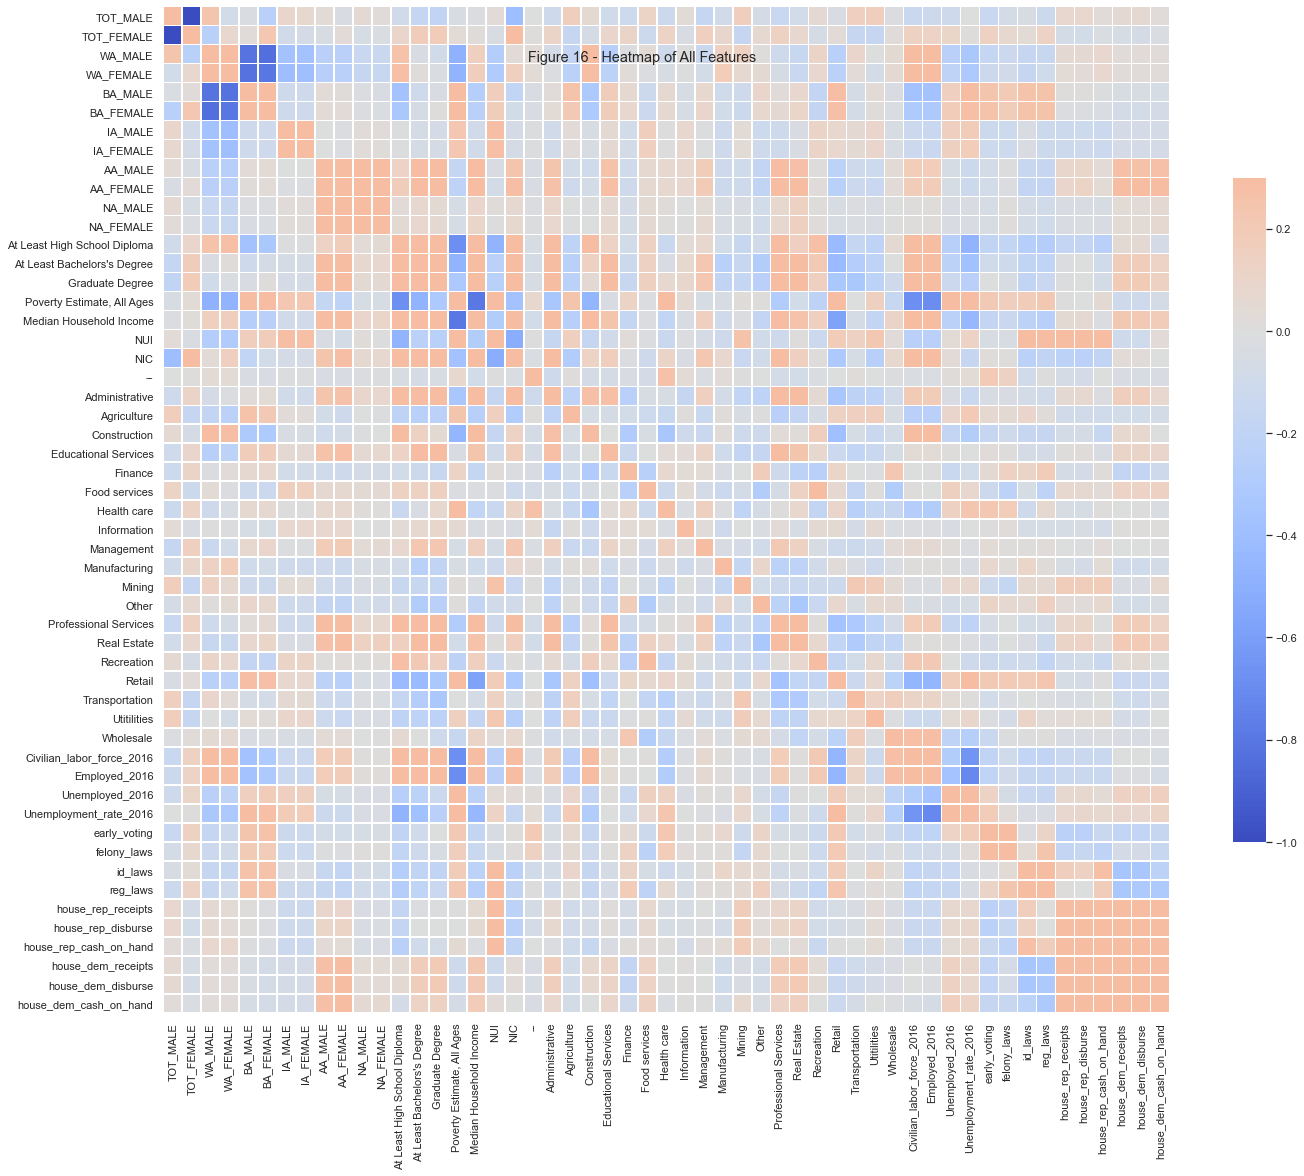

In [40]:
# Merging the features 
full_feature_df = pd.concat([demographic_business, economics, voting, finance],axis=1)

# Calculating correlation
full_merge_cor=full_feature_df.corr(method="pearson")

###Heatmap for chosen variables
f, ax = plt.subplots(figsize=(20, 20))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(full_merge_cor, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.suptitle("Figure 16 - Heatmap of All Features", x = .45, y = .83)
plt.tight_layout()
plt.savefig("allfeatureheatmap.png")
plt.show()

Figure 16 - Heatmap of All Features

# Model Assumption

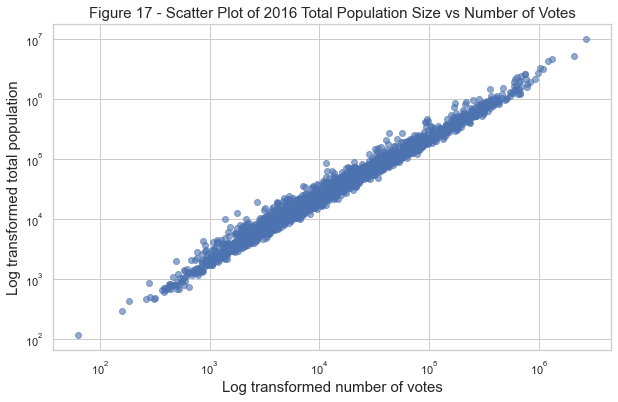

Pearsons coorelation: 0.972


In [41]:
# Here we are testing the assumption of total population size can be used as a
# approximation of the the number of population who actually made the votes. 

votes_pop = data_train[['Votes', 'TOT_POP']]
votes_pop = votes_pop[~votes_pop.isin([np.nan, np.inf, -np.inf]).any(1)]

votes_num = votes_pop.Votes
total_pop = votes_pop.TOT_POP

plt.figure(figsize=(10, 6))

# plot only scatter plot
plt.scatter(votes_num, total_pop, alpha=0.6)
plt.xlabel("Log transformed number of votes", fontsize=15)
plt.ylabel("Log transformed total population", fontsize=15)
plt.yscale('log')
plt.xscale('log')

plt.title("Figure 17 - Scatter Plot of 2016 Total Population Size vs Number of Votes", fontsize=15)
plt.show()

corr, _ = pearsonr(votes_num, total_pop)
print("Pearsons coorelation: {:.3f}".format(corr))

Figure 17 - Scatter Plot of 2016 Total Population Size vs Number of Votes

# Baseline Model Analyses 
## Analysis on 2016 Presidential Election 
### Using the ratio of Democratic Votes and Republic Votes as Response Variables

In [42]:
# Added response variable 
data_train['response'] = data_train['Democrats 2016'] / data_train['Republicans 2016']

## Building our model
# Initialie our predictor sets and I am training with response variables 'response_dem'
state = ['State']
demograph_pred = list(demographic_business.columns)
economic_pred = ['Unemployment_rate_2016']
financial_pred = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand', 'house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
voting_pred = ['bal2016/popu2016', 'early_voting', 'felony_laws', 'id_laws', 'reg_laws']
consistency_pred = ['lag_response_dem', 'lag_response_rep']
response = ['response']
polls = ['dem_poll_mean', 'rep_poll_mean', 'dem_poll_median', 'rep_poll_median', 'dem_poll_sd', 'rep_poll_sd']

# all response variables

# all predictors
train_pred = demograph_pred + economic_pred + financial_pred + voting_pred + consistency_pred + polls

# all predictors + response variables
train_pred_response = state + train_pred + response


In [43]:
temp=data_train[train_pred_response+['TOT_POP']].dropna()

In [44]:
#train_pred in list(train_df.columns)
for pred in train_pred:
    if pred not in list(data_train.columns):
        print(pred)

# This confirms that all predictors in our selected are in the training set.

In [45]:
# Here, i'm checking if there are any null values
# So, first, I need to replace all the missing values
# of business patterns with 0

business_nan = data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]
business_nan_fill = business_nan.fillna(0)
data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1] = business_nan_fill


In [46]:
# All the nan has been filled
business_nan_fill[business_nan_fill.isnull().any(axis=1)]

Empty DataFrame
Columns: [--, Administrative, Agriculture, Construction, Educational Services, Finance, Food services, Health care, Information, Management, Manufacturing, Mining, Other, Professional Services, Real Estate, Recreation, Retail, Transportation, Utitilities, Wholesale]
Index: []

In [47]:
# Now I'm checking the whole train_df
has_null = data_train[train_pred_response].isnull()
null_boolean = has_null.any(axis=1)

null_rows = data_train[train_pred_response][null_boolean]
null_rows.head()

State   TOT_MALE  TOT_FEMALE    WA_MALE  WA_FEMALE   BA_MALE  BA_FEMALE   IA_MALE  IA_FEMALE    AA_MALE  AA_FEMALE   NA_MALE  NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  Poverty Estimate, All Ages  Median Household Income        NUI        NIC         --  Administrative  Agriculture  Construction  Educational Services   Finance  Food services  Health care  Information  Management  Manufacturing    Mining     Other  Professional Services  Real Estate  Recreation     Retail  Transportation  Utitilities  Wholesale  Unemployment_rate_2016  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  bal2016/popu2016  early_voting  felony_laws  id_laws  reg_laws  lag_response_dem  lag_response_rep  dem_poll_mean  rep_poll_mean  dem_poll_median  rep_poll_median  dem_poll_sd  rep_poll_sd  response
67  Alaska  51.440870   48.559130  35.536587  32.012840  0.452324   0.335595  7.032903   7.164223   3.647771   4.421099  0.160502   0.145911                          92.5                         24.2              7.6                    9.082950                  67125.0  14.131466  71.189903  16.689770        3.881342     2.495148      9.426116              0.693097  2.356529       8.733019     6.653729     2.079290    0.970335       1.802052  0.415858  6.515110               4.574439     4.019961    3.188245  14.555032        9.287497     0.000000   1.663432                     6.5          1102309.77          1098098.09                 4211.68          1103561.86          1322055.12               269726.86          0.069867             0            1        1         0               NaN               NaN      32.782632      40.212368             31.0             39.0     6.230053     5.945707       NaN
68  Alaska  52.235423   47.764577  43.823894  39.724738  0.704963   0.483101  3.503683   3.188659   0.577224   0.941231  0.209376   0.161354                          91.8                         20.8              6.3                    9.259597                  71793.0  13.787109  73.960564  16.691912        4.809149     0.454408     17.646168              0.984550  2.574977       8.179340    11.587398     1.287489    0.302939       1.741896  0.416540  7.156922               6.323841     3.142987    2.196304   9.126022        3.332324     0.302939   1.741896                     8.2          1102309.77          1098098.09                 4211.68          1103561.86          1322055.12               269726.86          0.069867             0            1        1         0               NaN               NaN      32.782632      40.212368             31.0             39.0     6.230053     5.945707       NaN
69  Alaska  66.222612   33.777388  24.943032   9.553024  6.275197   0.771253  6.941280   5.521472  23.856266  15.600351  1.822962   0.543383                          70.4                          9.0              1.3                    7.677476                  78151.0  19.877301  69.342682  16.666667        5.072464     5.072464      3.623188              0.000000  1.449275       6.521739     8.695652     2.173913    0.000000       5.797101  0.724638  6.521739               2.173913     2.173913    0.724638   7.971014       15.217391     0.000000   9.420290                     3.3          1102309.77          1098098.09                 4211.68          1103561.86          1322055.12               269726.86          0.069867             0            1        1         0               NaN               NaN      32.782632      40.212368             31.0             39.0     6.230053     5.945707       NaN
70  Alaska  52.822086   47.177914  40.582822  36.012270  1.165644   0.429448  5.797546   4.907975   1.380368   1.779141  0.644172   0.122699                          95.5                         27.4             10.5                    8.128834                  60540.0  17.638037  64.938650  16.666667        1.937984    12.112403      

In [48]:
## Same again, a lot of them are from Alaska, so we are 
## going to drop them for now. 
train_df_final = data_train[train_pred_response].dropna()
##dropping both state and response variable
train_df_semi=train_df_final.drop(columns=['State'], axis = 1)
train_df_final = train_df_final.drop(columns=['State','response'], axis = 1)
# Dropping School Enrollment and Removing the 2016 identifier so the train dataset is identical to the test dataset
train_df_final = train_df_final.rename(columns={'Unemployment_rate_2016': 'Unemployment_rate', 'bal2016/popu2016': 'bal/popu'})
print(train_df_final.shape)

(3111, 59)


In [49]:
# print(len(data_train))
# temp=data_train[train_pred_response].dropna()
# len(temp.State.value_counts())
# len(temp)

In [50]:
## First, standardize all the training data
## The scaler can be used for future testing data
scaler = StandardScaler().fit(train_df_final)
train_df_final_s = scaler.transform(train_df_final)
train_df_final_s = pd.DataFrame(train_df_final_s, columns=train_df_final.columns)
# Describing data
display(train_df_final_s.describe())

TOT_MALE    TOT_FEMALE       WA_MALE     WA_FEMALE       BA_MALE     BA_FEMALE       IA_MALE     IA_FEMALE       AA_MALE     AA_FEMALE       NA_MALE     NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  Poverty Estimate, All Ages  Median Household Income           NUI           NIC            --  Administrative   Agriculture  Construction  Educational Services       Finance  Food services   Health care   Information    Management  Manufacturing        Mining         Other  Professional Services   Real Estate    Recreation        Retail  Transportation   Utitilities     Wholesale  Unemployment_rate  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand     bal/popu  early_voting   felony_laws      id_laws      reg_laws  lag_response_dem  lag_response_rep  dem_poll_mean  rep_poll_mean  dem_poll_median  rep_poll_median   dem_poll_sd   rep_poll_sd
count  3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03                  3.111000e+03                 3.111000e+03     3.111000e+03                3.111000e+03             3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03    3.111000e+03  3.111000e+03  3.111000e+03          3.111000e+03  3.111000e+03   3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03   3.111000e+03  3.111000e+03  3.111000e+03           3.111000e+03  3.111000e+03  3.111000e+03  3.111000e+03    3.111000e+03  3.111000e+03  3.111000e+03       3.111000e+03        3.111000e+03        3.111000e+03            3.111000e+03        3.111000e+03        3.111000e+03            3.111000e+03  3111.000000  3.111000e+03  3.111000e+03  3111.000000  3.111000e+03      3.111000e+03      3.111000e+03   3.111000e+03   3.111000e+03     3.111000e+03     3.111000e+03  3.111000e+03  3.111000e+03
mean  -9.501311e-16  1.007230e-15 -3.334595e-16  1.004946e-16 -2.740763e-17  1.279023e-16  4.567938e-17 -2.740763e-17 -1.141984e-17  1.827175e-17 -1.141984e-17  9.135876e-18                 -1.233343e-16                 9.135876e-17     2.558045e-16               -2.283969e-16             1.004946e-16  9.135876e-17  1.078033e-15  1.928583e-14   -4.567938e-17  2.740763e-17  8.679082e-17         -1.507419e-16 -1.004946e-16  -1.644458e-16 -1.827175e-16 -1.461740e-16  1.804335e-16   4.567938e-17 -9.135876e-17  6.166716e-17           2.866381e-16  1.827175e-17 -1.370381e-17 -2.009893e-16    1.735816e-16  6.395113e-17  3.197557e-17      -1.827175e-17        1.827175e-16        1.370381e-16           -1.644458e-16        5.481525e-17       -3.654350e-17           -3.654350e-17     0.000000  5.481525e-17 -1.827175e-16     0.000000  1.507419e-16      1.580507e-15      2.329648e-15   2.740763e-16   2.466686e-16     1.827175e-17    -9.592670e-17  2.466686e-16 -2.192610e-16
std    1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00                  1.000161e+00                 1.000161e+00     1.000161e+00                1.000161e+00             1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00    1.000161e+00  1.000161e+00  1.000161e+00          1.000161e+00  1.000161e+00   1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00   1.000161e+00  1.000161e+00  1.000161e+00           1.000161e+00  1.000161e+00  1.000161e+00  1.000161e+00    1.000161e+00  1.000161e+00  1.000161e+00       1.000161e+00        1.000161e+00        1.000161e+00            1.000161e+00        1.000161e+00        1.000161e+00            1.000161e+00     1.000161  1.000161e+00  1.000161e+00     1.000161  1.000161e+00      1.000161e+00      1.000161e+00   1.000161e+00   1.000161e+00     1.000161e+00     1.000161e+00  1.000161e+00  1.000161e+00
min   -3.102982e+00 -8.966133e+00 -4.746673e+00 -4.739133e+00 -6.711730e-01 -6.034407e-01 -3.164129e-01

In [51]:
# Initialie our predictor sets 
state = ['State']
demograph_pred = list(demographic_business.columns)
#economic_pred = ['Unemployment_rate_2016']
financial_pred = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand', 'house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
#voting_pred = ['bal2016/popu2016', 'early_voting', 'felony_laws', 'id_laws', 'reg_laws']
consistency_pred = ['lag_response_dem', 'lag_response_rep']
polls = ['dem_poll_mean', 'rep_poll_mean', 'dem_poll_median', 'rep_poll_median', 'dem_poll_sd', 'rep_poll_sd']
economic_pred = ['Unemployment_rate']
voting_pred = ['bal/popu', 'early_voting', 'felony_laws', 'id_laws', 'reg_laws']
response = ['response']

# all predictors
train_pred = demograph_pred + economic_pred + financial_pred + voting_pred + consistency_pred + polls

# all predictors + response variables
train_pred_response = state + train_pred + response

Xtrain = train_df_final_s[train_pred].values
ytrain = train_df_semi.response.values

# Get both shapes for both X and y
print(Xtrain.shape)
print(ytrain.shape)

(3111, 59)
(3111,)


### Random Forest based Presidential Election Model

In [52]:
########Retune random forest model 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [np.sqrt(len(train_pred)), np.log2(len(train_pred)), 4, 8, 9, 10, 12, 15, 20]
# log 2 
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
#Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
### ADD neg_mean_error
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 14, 24, 33, 43, 52, 62,
                                                      71, 81, 90, 100, None],
                                        'max_features': [7.681145747868608,
                                                         5.882643049361842, 4,
                                                         8, 9, 10, 12, 15, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [53]:
###Save cross valdiation results across grid search parameters to file
cv_result=pd.DataFrame.from_dict(rf_random.cv_results_,orient="index")
#cv_result.to_csv("rf_grid_cv_ey.csv")

/Applications/anaconda3/envs/cs109a/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


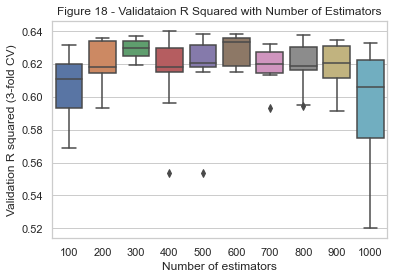

In [54]:
###Plot parameters with validation R square 
plot=cv_result.sort_values(axis=1,by=['param_n_estimators'])

###Plot number of parameters with validation R square 

est=sns.boxplot(plot.loc['param_n_estimators',],plot.loc['mean_test_score',])
est.set_xlabel("Number of estimators")
est.set_ylabel("Validation R squared (3-fold CV)")

plt.title("Figure 18 - Validataion R Squared with Number of Estimators")
plt.show()

Figure 18 - Validataion R Squared with Number of Estimators

/Applications/anaconda3/envs/cs109a/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


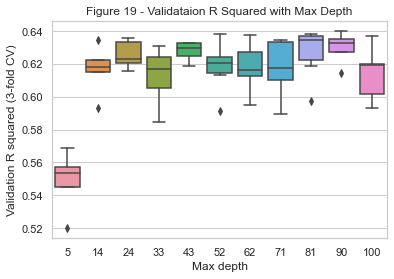

In [55]:
##Plot depths of tree with validation R square 

plot=cv_result.sort_values(axis=1,by=['param_max_depth'])

est=sns.boxplot(plot.loc['param_max_depth',],plot.loc['mean_test_score',])
est.set_xlabel("Max depth")
est.set_ylabel("Validation R squared (3-fold CV)")
plt.title("Figure 19 - Validataion R Squared with Max Depth")
plt.show()

Figure 19 - Validataion R Squared with Max Depth

/Applications/anaconda3/envs/cs109a/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


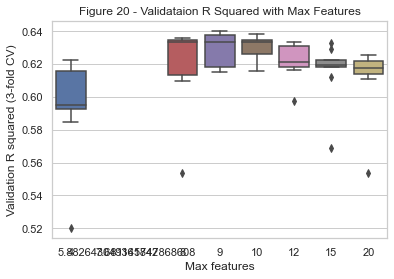

In [56]:
##Plot number of parameters with validation R square 

plot=cv_result.sort_values(axis=1,by=['param_max_features'])
est=sns.boxplot((plot.loc['param_max_features',]),plot.loc['mean_test_score',])
est.set_xlabel("Max features")
est.set_ylabel("Validation R squared (3-fold CV)")

plt.title("Figure 20 - Validataion R Squared with Max Features")
plt.show()

Figure 20 - Validataion R Squared with Max Features

In [57]:
# best params
rf_random.best_params_

{'n_estimators': 400, 'max_features': 9, 'max_depth': 90, 'bootstrap': False}

In [58]:
###Fit the best data
bestrf=RandomForestRegressor(n_estimators=800, 
                             max_features=15,
                             max_depth= 24,
                             bootstrap=False)

bestrf.fit(Xtrain, ytrain)
bestrf.score(Xtrain, ytrain)

0.9999976568351802

In [59]:
train_prediction=pd.DataFrame(bestrf.predict(Xtrain))
train_prediction.index=temp.index
train_predictiondf=pd.concat([train_prediction,temp],axis=1)

In [60]:
train_predictiondf['Prediction Vote']=train_predictiondf[0]*train_predictiondf.TOT_POP
#tstate_vote=pd.DataFrame(train_predictiondf.groupby(['State'])['Prediction Vote'].sum())
state_population=pd.DataFrame(train_predictiondf.groupby(['State'])['TOT_POP'].sum())
#state_electoral=state_vote['Prediction Vote']/state_population['TOT_POP']

###From the ratio of democrat and replublican --> predict their votes separately ? 
ratio_dem=[]
ratio_rep=[]
for p in train_predictiondf[0]:
    ratio_dem.append(p.as_integer_ratio()[0]/(p.as_integer_ratio()[0]+p.as_integer_ratio()[1]))
    ratio_rep.append(p.as_integer_ratio()[1]/(p.as_integer_ratio()[0]+p.as_integer_ratio()[1]))
    
###Calculate ratio of democrat, republican wins per county
train_predictiondf['ratio_dem']=ratio_dem
train_predictiondf['ratio_rep']=ratio_rep
###Calculate number of votes winned of democrat, republican per county
train_predictiondf['pred_dem_vote']=train_predictiondf['ratio_dem']*train_predictiondf['TOT_POP']
train_predictiondf['pred_rep_vote']=train_predictiondf['ratio_rep']*train_predictiondf['TOT_POP']

###Aggregate votes per state
train_state_dem_vote=pd.DataFrame(train_predictiondf.groupby(['State'])['pred_dem_vote'].sum())
train_state_rep_vote=pd.DataFrame(train_predictiondf.groupby(['State'])['pred_rep_vote'].sum())

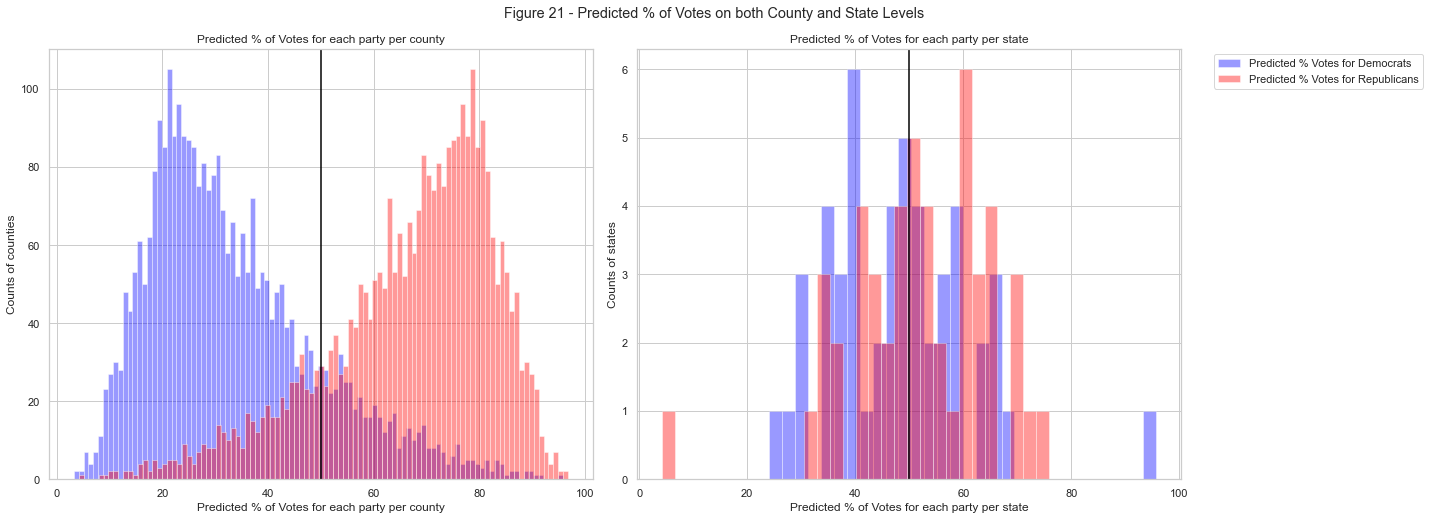

In [61]:
##histograms of prediction on a county level

train_perc_dem_state=train_state_dem_vote.pred_dem_vote/state_population.TOT_POP*100
train_perc_rep_state=train_state_rep_vote.pred_rep_vote/state_population.TOT_POP*100

fig, axs = plt.subplots(1, 2, figsize=[20,7])
axs[0].hist(train_predictiondf.ratio_dem*100, bins=100,color="blue", alpha=0.4, label="Predicted % Votes for Democrats")
axs[0].hist(train_predictiondf.ratio_rep*100, bins=100,color="red", alpha=0.4, label="Predicted % Votes for Republicans")

axs[0].set_title("Predicted % of Votes for each party per county")
axs[0].set_xlabel("Predicted % of Votes for each party per county")
axs[0].axvline(x=50,color="black")
axs[0].set_ylabel("Counts of counties")
#axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()

##histograms of prediction on a state level

axs[1].hist((train_perc_dem_state), bins=30,color="blue", alpha=0.4, label="Predicted % Votes for Democrats")
axs[1].hist((train_perc_rep_state), bins=30,color="red", alpha=0.4, label="Predicted % Votes for Republicans")

axs[1].set_title("Predicted % of Votes for each party per state")
axs[1].set_xlabel("Predicted % of Votes for each party per state")
axs[1].set_ylabel("Counts of states")
axs[1].axvline(x=50,color="black")
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle("Figure 21 - Predicted % of Votes on both County and State Levels", y=1.03)
plt.savefig("train_pres_pred.png")
plt.show()

Figure 21 - Predicted % of Votes on both County and State Levels

In [62]:
#### Reading in 2016 election result
state_2016=pd.read_csv("2016_state_election.csv")
##remove Alaska for we do not have its result
c=state_2016.drop(state_2016.index[[0,51,52]])

##combine training set prediction with actual voting data frame
c.index=train_state_dem_vote.index
c_merge=pd.concat([c,train_state_dem_vote], axis=1)
c_merge.index=train_state_rep_vote.index
c_merge=pd.concat([c_merge, train_state_rep_vote], axis=1)
c_merge['pred % rep']=train_perc_rep_state
c_merge['pred % dem']=train_perc_dem_state

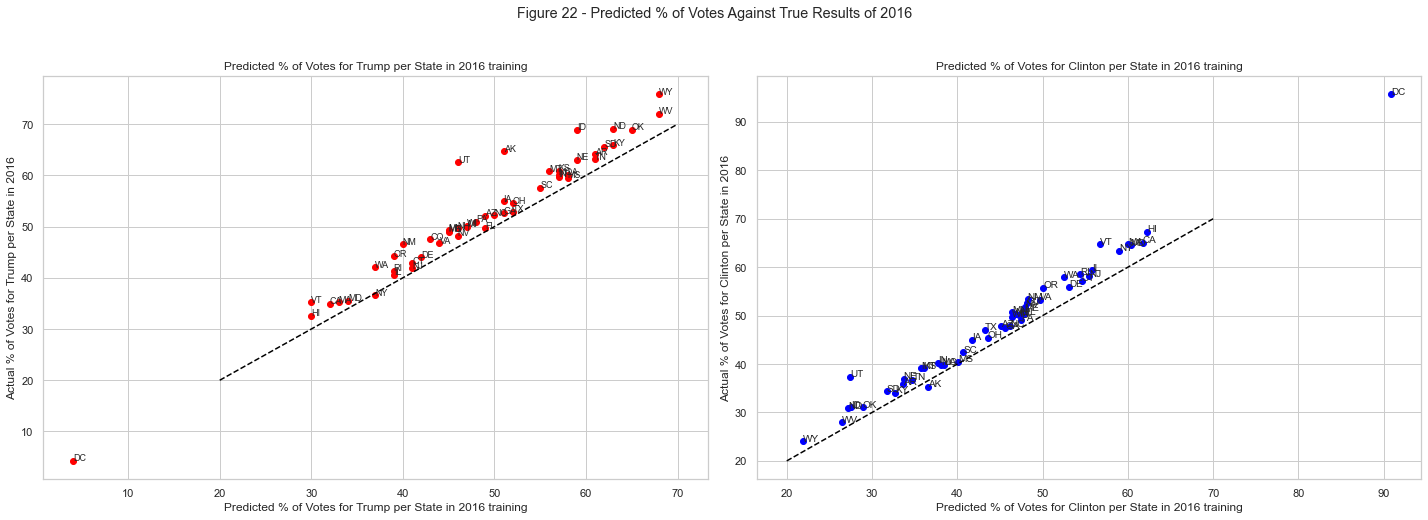

In [63]:
###plot 2016 training set prediction against the true outcome 
x=np.linspace(20, 70, num=100)
y=np.linspace(20, 70, num=100)
name=c_merge.STATE

fig, axs = plt.subplots(1, 2, figsize=[20,7])

xaxis=c_merge['trump']
yaxis=c_merge['pred % rep']

axs[0].scatter(c_merge['trump'], c_merge['pred % rep'], color="red")
axs[0].plot(x, y, '--', color='black')
axs[0].set_title("Predicted % of Votes for Trump per State in 2016 training")
axs[0].set_xlabel("Predicted % of Votes for Trump per State in 2016 training")
axs[0].set_ylabel("Actual % of Votes for Trump per State in 2016")
for i, txt in enumerate(name):
    axs[0].annotate(txt, (xaxis[i], yaxis[i]), size=9)

dxaxis=c_merge['clinton ']
dyaxis=c_merge['pred % dem']

axs[1].scatter(c_merge['clinton '], c_merge['pred % dem'],color="blue")
axs[1].plot(x, y, '--', color='black')
axs[1].set_title("Predicted % of Votes for Clinton per State in 2016 training")
axs[1].set_xlabel("Predicted % of Votes for Clinton per State in 2016 training")
axs[1].set_ylabel("Actual % of Votes for Clinton per State in 2016")
for i, txt in enumerate(name):
    axs[1].annotate(txt, (dxaxis[i], dyaxis[i]), size=10)

plt.suptitle("Figure 22 - Predicted % of Votes Against True Results of 2016", y=1.03)
plt.tight_layout()
plt.savefig("pres_pred_2016_train.png")
plt.show()

Figure 22 - Predicted % of Votes Against True Results of 2016

In [64]:
##R square for prediction on training set 
from sklearn.metrics import r2_score
print("Republican R squared ")
print(r2_score(c_merge['trump'], c_merge['pred % rep']) )
print("Democrats R squared ")
print(r2_score(c_merge['clinton '], c_merge['pred % dem']))

Republican R squared 
0.8379016990548217
Democrats R squared 
0.9059990279338861


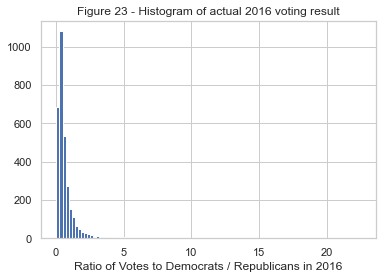

In [65]:
###Plot distribution of predicted and actial voting results in 2016
plt.hist(ytrain, bins=100)
plt.xlabel("Ratio of Votes to Democrats / Republicans in 2016")
plt.title("Figure 23 - Histogram of actual 2016 voting result")
plt.show()

Figure 23 - Histogram of actual 2016 voting result

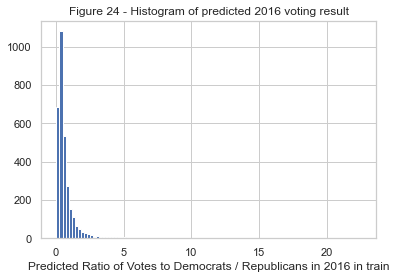

In [66]:
plt.hist(bestrf.predict(Xtrain), bins=100)
plt.xlabel("Predicted Ratio of Votes to Democrats / Republicans in 2016 in train")
plt.title("Figure 24 - Histogram of predicted 2016 voting result")
plt.show()

Figure 24 - Histogram of predicted 2016 voting result

### Test data for 2020 election

In [67]:
fin=pd.read_table("train_test_data/house_financial_2020.csv", sep=",")
test = pd.read_csv('train_test_data/testing_housing_presidential.csv')

##Business pattern fill na with 0 
business=test.iloc[:, test.columns.get_loc('--'):test.columns.get_loc('Wholesale')+1]
b_tot=business.sum(axis=1)

temp=pd.DataFrame()
for col in business.columns:
    temp[col]=test[col]/b_tot*100

temp=temp.fillna(0) 

test.iloc[:, test.columns.get_loc('--'):test.columns.get_loc('Wholesale')+1]=temp

###Change column names to make test and training features consistent
test['State'] = test['STNAME']

test['At Least Bachelors\'s Degree'] = test['Percent of adults with a bachelor\'s degree or higher, 2014-18'] 
test['At Least High School Diploma'] = test['Percent of adults with a bachelor\'s degree or higher, 2014-18'] + test['Percent of adults with a high school diploma only, 2014-18'] + test['Percent of adults completing some college or associate\'s degree, 2014-18']
test['Graduate Degree']=test['Percent of adults with a bachelor\'s degree or higher, 2014-18']

test['Poverty Estimate, All Ages'] = test.PCTPOVALL_2018.astype(float)
test['Median Household Income'] = test['MEDHHINC_2018']
test['Unemployment_rate'] = test['Unemployment_rate_2019']

test['bal/popu']=test['calculated approx. county adv. Ballots 2020'] / test['TOT_POP']
test['lag_response_dem']=data_train['Democrats 2016']/data_train['Democrats 2012']
test['lag_response_rep']=data_train['Republicans 2016']/data_train['Republicans 2012']

test=test.merge(fin, right_on="state", left_on="STNAME")

In [68]:
###Make all demographic in test data %
demo=test.iloc[:, test.columns.get_loc('TOT_MALE'):test.columns.get_loc('NA_FEMALE')+1]
temp=pd.DataFrame()
for col in demo.columns:
    temp[col]=test[col]/test['TOT_POP']*100
test.iloc[:, test.columns.get_loc('TOT_MALE'):test.columns.get_loc('NA_FEMALE')+1]=temp

demo=test.iloc[:, test.columns.get_loc('Civilian_labor_force_2019'):test.columns.get_loc('Unemployed_2019')+1]
temp=pd.DataFrame()
for col in demo.columns:
    temp[col]=test[col]/test['TOT_POP']*100
test.iloc[:, test.columns.get_loc('Civilian_labor_force_2019'):test.columns.get_loc('Unemployed_2019')+1]=temp

demo=test.iloc[:, test.columns.get_loc('NUI'):test.columns.get_loc('NIC')+1]
temo=pd.DataFrame()
for col in demo.columns:
    temp[col]=test[col]/test['TOT_POP']*100
test.iloc[:, test.columns.get_loc('NUI'):test.columns.get_loc('NIC')+1]=temp

test['perc_adv'] = test['early_voting'] / test['TOT_POP']

In [69]:
##Check in every predictor in train is in test 
# for i in train_pred:
#     if i in test.columns:
#         print("Yes"+ i)
#     else: 
#         print( "Not in test"+ i)

# all predictors we used in traing set 
train_pred = demograph_pred + economic_pred + financial_pred + voting_pred + consistency_pred + polls 

test_full=pd.concat([test['State'], test['FIPS Code']], axis=1)
test_full.index=test.index
test_full=pd.concat([test_full,test[train_pred] ], axis=1)

In [70]:
###inspect null data in test set 
has_null = test_full.isnull()
null_boolean = has_null.any(axis=1)

null_rows = test_full[null_boolean]
null_rows.head()

State  FIPS Code   TOT_MALE  TOT_FEMALE    WA_MALE  WA_FEMALE   BA_MALE  BA_FEMALE    IA_MALE  IA_FEMALE   AA_MALE  AA_FEMALE   NA_MALE  NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  Poverty Estimate, All Ages  Median Household Income        NUI        NIC         --  Administrative  Agriculture  Construction  Educational Services   Finance  Food services  Health care  Information  Management  Manufacturing    Mining      Other  Professional Services  Real Estate  Recreation     Retail  Transportation  Utitilities  Wholesale  Unemployment_rate  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  bal/popu  early_voting  felony_laws  id_laws  reg_laws  lag_response_dem  lag_response_rep  dem_poll_mean  rep_poll_mean  dem_poll_median  rep_poll_median  dem_poll_sd  rep_poll_sd
67  Alaska       2180  52.648940   47.351060   8.586565   7.097161  0.449820   0.409836  39.224310  36.055578  0.889644   0.579768  0.099960   0.089964                          84.1                         14.6             14.6                        22.0                    55318  16.663335  74.030388  23.013699        1.643836     0.000000      6.301370              0.000000  1.232877      11.643836    15.342466     2.054795    0.000000       0.410959  1.506849   6.301370               1.095890     4.657534    4.109589  15.479452        4.383562      0.00000   0.821918               10.9                 0.0                 0.0                     0.0          1944410.46          1816216.58                244914.0  6.004676           0.0          1.0      1.0       0.0               NaN               NaN      43.552097      52.000806             44.0             53.0     3.335486     2.756127
68  Alaska       2185  62.357608   37.642392  26.200163   6.468674  1.108625   0.528885  27.919040  25.233930  3.203824   2.278275  0.996745   0.803499                          89.8                         16.6             16.6                        11.1                    89276  14.229048  78.590317  21.253406        2.997275     0.000000      4.087193              0.000000  0.000000      17.711172     2.179837     6.811989    2.724796       0.000000  4.087193   4.768392               2.316076     4.904632    0.000000  11.307902        6.675749      0.00000   8.174387                6.4                 0.0                 0.0                     0.0          1944410.46          1816216.58                244914.0  0.131592           0.0          1.0      1.0       0.0               NaN               NaN      43.552097      52.000806             44.0             53.0     3.335486     2.756127
69  Alaska       2188  53.785592   46.214408   7.111928   4.553208  0.957880   0.813542  41.923632  37.698465  0.498622   0.498622  0.144338   0.078730                          81.8                         11.7             11.7                        21.1                    59337  16.375804  75.856187  28.571429        2.448980     0.000000      2.448980              0.000000  0.000000       9.387755     1.632653     6.530612    0.000000       0.000000  1.224490  13.061224               0.000000     0.000000    0.000000  18.775510       15.918367      0.00000   0.000000               14.0                 0.0                 0.0                     0.0          1944410.46          1816216.58                244914.0  0.069244           0.0          1.0      1.0       0.0               NaN               NaN      43.552097      52.000806             44.0             53.0     3.335486     2.756127
70  Alaska       2195  51.928965   48.071035  38.640539  36.099204  1.347214   0.428659   6.093080   5.235762  1.439069   2.265769  0.796081   0.153092                          89.8                         27.6             27.6                         7.2                    66075  12.798530  66.809553  25.431711        2.354788    15.698587      7.692308              1.412873  0

In [71]:
###drop only Alaska 
clean=test_full.drop(test_full.index[67:71])
clean.shape
display(clean)
clean=pd.DataFrame(clean)
test_x=clean[train_pred]

State  FIPS Code   TOT_MALE  TOT_FEMALE    WA_MALE  WA_FEMALE    BA_MALE  BA_FEMALE   IA_MALE  IA_FEMALE   AA_MALE  AA_FEMALE   NA_MALE  NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  Poverty Estimate, All Ages  Median Household Income        NUI        NIC         --  Administrative  Agriculture  Construction  Educational Services   Finance  Food services  Health care  Information  Management  Manufacturing    Mining      Other  Professional Services  Real Estate  Recreation     Retail  Transportation  Utitilities  Wholesale  Unemployment_rate  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand  bal/popu  early_voting  felony_laws  id_laws  reg_laws  lag_response_dem  lag_response_rep  dem_poll_mean  rep_poll_mean  dem_poll_median  rep_poll_median  dem_poll_sd  rep_poll_sd
0     Alabama       1001  48.492008   51.507992  37.369561  38.892767   9.373714  10.739408  0.216578   0.259536  0.511912   0.662264  0.057277   0.046537                          88.7                         27.7             27.7                        13.8                    59338   8.400007  75.204496  18.351578        2.318094     0.880017      6.546469              0.686843  7.834299      10.688989     8.606997     0.944409    0.000000       1.051728  0.321958  11.247049               5.387422     4.378622    1.094656  16.183730        1.137583     0.708307   1.631251                2.7          2593073.97          1836694.09              2318331.85         12839666.85         12243323.94              2903815.02  0.027071           2.0          1.0      3.0       2.0          0.908975          1.084702      38.980462      57.996000             39.0             58.0     2.145167     2.760354
1     Alabama       1073  47.258542   52.741458  25.786056  27.285662  19.823163  23.643696  0.139240   0.143796  0.850172   0.939455  0.022473   0.035531                          89.8                         32.4             32.4                        16.1                    55013   9.134599  72.967765  16.758624        3.708926     0.056196      5.481650              0.894025  6.514631       7.673288     9.009727     1.556114    0.882786       2.500204  0.106261   9.152771               9.754577     3.997057    1.170917  13.231568        2.053703     0.247262   5.249714                2.9          2593073.97          1836694.09              2318331.85         12839666.85         12243323.94              2903815.02  0.011134           2.0          1.0      3.0       2.0          0.901323          1.099448      38.980462      57.996000             39.0             58.0     2.145167     2.760354
2     Alabama       1075  48.967765   51.032235  43.027888  44.498370   4.875045   5.454545  0.130388   0.181094  0.050706   0.057950  0.007244   0.007244                          82.4                         12.5             12.5                        17.4                    40936   9.243028  68.279609  22.065313        0.617829     4.501324      5.295675              0.000000  4.148279       7.678729     5.648720     1.588703    0.000000       4.148279  0.000000   9.796999               5.648720     0.617829    0.264784  17.917034        8.914387     0.000000   1.147396                3.1          2593073.97          1836694.09              2318331.85         12839666.85         12243323.94              2903815.02  0.469905           2.0          1.0      3.0       2.0          0.630599          1.138576      38.980462      57.996000             39.0             58.0     2.145167     2.760354
3     Alabama       1077  47.978518   52.021482  41.855299  45.100238   4.608051   5.409311  0.236172   0.210290  0.387150   0.430286  0.032352   0.030196                          87.4                         23.9             23.9                        14.0                    48707   9.116889  68.773523  17.644437        2.648003     0.588445      5.866619             

In [72]:
###standardize test training set 
scaler = StandardScaler().fit(train_df_final)

test_df_final_s = scaler.transform(test_x)
test_df_final_s = pd.DataFrame(test_df_final_s, columns=test_x.columns)

In [73]:
test_df_final_s.describe()

TOT_MALE   TOT_FEMALE      WA_MALE    WA_FEMALE      BA_MALE    BA_FEMALE      IA_MALE    IA_FEMALE      AA_MALE    AA_FEMALE      NA_MALE    NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  Poverty Estimate, All Ages  Median Household Income          NUI          NIC           --  Administrative  Agriculture  Construction  Educational Services      Finance  Food services  Health care  Information   Management  Manufacturing       Mining        Other  Professional Services  Real Estate   Recreation       Retail  Transportation  Utitilities    Wholesale  Unemployment_rate  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand     bal/popu  early_voting  felony_laws      id_laws     reg_laws  lag_response_dem  lag_response_rep  dem_poll_mean  rep_poll_mean  dem_poll_median  rep_poll_median  dem_poll_sd  rep_poll_sd
count  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000                   3136.000000                  3136.000000      3136.000000                 3136.000000              3136.000000  3136.000000  3136.000000  3136.000000     3136.000000  3136.000000   3136.000000           3136.000000  3136.000000    3136.000000  3136.000000  3136.000000  3136.000000    3136.000000  3136.000000  3136.000000            3136.000000  3136.000000  3136.000000  3136.000000     3136.000000  3136.000000  3136.000000        3136.000000         3136.000000         3136.000000             3136.000000         3136.000000         3136.000000             3136.000000  3135.000000   3135.000000  3135.000000  3135.000000  3135.000000       3111.000000       3111.000000    3136.000000    3136.000000      3136.000000      3136.000000  3136.000000  3136.000000
mean      0.020060    -0.020060    -0.041975    -0.047180     0.004827     0.001547     0.049582     0.044451     0.055101     0.050276     0.037833     0.038148                      0.477009                     0.298227         3.926670                   -0.020707                 0.262203     0.064338    -0.183147    45.310434       -0.262188    -0.058155      0.057724             -0.352252     0.064644       0.412707    -0.188416    -0.552403    -0.256500      -0.797755    -0.040859     0.191860              -0.084935    -0.127167    -0.363747    -0.308009       -0.037150    -0.240889    -0.363421          -0.660951            1.128192            1.141774                0.753709            0.848154            0.776604               -0.007282    16.466730     -0.004147     0.002673    -0.005868    -0.016442         -1.191942          0.322539       1.212035       0.974390         1.183021         0.760790    -1.077272    -1.385703
std       1.022005     1.022005     1.021800     1.025837     0.993824     0.995952     1.159659     1.138228     1.169245     1.086686     1.033387     1.035002                      0.847776                     1.090828         2.449131                    1.057165                 1.081508     1.035056     1.002134    71.293897        1.214388     1.312850      1.248943              0.979054     1.381532       1.462155     1.133804     1.116903     1.074522       0.880821     1.211552     1.470328               1.149043     1.246629     1.198697     1.258817        1.099591     1.152408     1.201584           0.800612            2.477098            2.376491                2.664780            2.363594            2.299849                0.932654    84.596492      0.997442     0.996789     0.998562     1.013763          1.504985          1.741792       1.079155       1.210627         1.052875         1.126370     0.731886     0.385287
min      -3.207757   -10.619886    -5.065075    -5.039226    -0.671173    -0.603441    -0.316413    -0.301739    -0.525906    -0.557043    -0.276945    -0.265305                     -6.592356                    -2.195443      

In [74]:
##Impute missing values in test data 
from sklearn.impute import KNNImputer 
imputer = KNNImputer(n_neighbors=10)
test_impute=imputer.fit_transform(test_df_final_s)
test_impute=pd.DataFrame(test_impute, columns=train_pred)

In [75]:
test_impute.describe()

TOT_MALE   TOT_FEMALE      WA_MALE    WA_FEMALE      BA_MALE    BA_FEMALE      IA_MALE    IA_FEMALE      AA_MALE    AA_FEMALE      NA_MALE    NA_FEMALE  At Least High School Diploma  At Least Bachelors's Degree  Graduate Degree  Poverty Estimate, All Ages  Median Household Income          NUI          NIC           --  Administrative  Agriculture  Construction  Educational Services      Finance  Food services  Health care  Information   Management  Manufacturing       Mining        Other  Professional Services  Real Estate   Recreation       Retail  Transportation  Utitilities    Wholesale  Unemployment_rate  house_dem_receipts  house_dem_disburse  house_dem_cash_on_hand  house_rep_receipts  house_rep_disburse  house_rep_cash_on_hand     bal/popu  early_voting  felony_laws      id_laws     reg_laws  lag_response_dem  lag_response_rep  dem_poll_mean  rep_poll_mean  dem_poll_median  rep_poll_median  dem_poll_sd  rep_poll_sd
count  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000  3136.000000                   3136.000000                  3136.000000      3136.000000                 3136.000000              3136.000000  3136.000000  3136.000000  3136.000000     3136.000000  3136.000000   3136.000000           3136.000000  3136.000000    3136.000000  3136.000000  3136.000000  3136.000000    3136.000000  3136.000000  3136.000000            3136.000000  3136.000000  3136.000000  3136.000000     3136.000000  3136.000000  3136.000000        3136.000000         3136.000000         3136.000000             3136.000000         3136.000000         3136.000000             3136.000000  3136.000000   3136.000000  3136.000000  3136.000000  3136.000000       3136.000000       3136.000000    3136.000000    3136.000000      3136.000000      3136.000000  3136.000000  3136.000000
mean      0.020060    -0.020060    -0.041975    -0.047180     0.004827     0.001547     0.049582     0.044451     0.055101     0.050276     0.037833     0.038148                      0.477009                     0.298227         3.926670                   -0.020707                 0.262203     0.064338    -0.183147    45.310434       -0.262188    -0.058155      0.057724             -0.352252     0.064644       0.412707    -0.188416    -0.552403    -0.256500      -0.797755    -0.040859     0.191860              -0.084935    -0.127167    -0.363747    -0.308009       -0.037150    -0.240889    -0.363421          -0.660951            1.128192            1.141774                0.753709            0.848154            0.776604               -0.007282    16.464596     -0.004218     0.002587    -0.005738    -0.016244         -1.195794          0.321611       1.212035       0.974390         1.183021         0.760790    -1.077272    -1.385703
std       1.022005     1.022005     1.021800     1.025837     0.993824     0.995952     1.159659     1.138228     1.169245     1.086686     1.033387     1.035002                      0.847776                     1.090828         2.449131                    1.057165                 1.081508     1.035056     1.002134    71.293897        1.214388     1.312850      1.248943              0.979054     1.381532       1.462155     1.133804     1.116903     1.074522       0.880821     1.211552     1.470328               1.149043     1.246629     1.198697     1.258817        1.099591     1.152408     1.201584           0.800612            2.477098            2.376491                2.664780            2.363594            2.299849                0.932654    84.583083      0.997291     0.996641     0.998430     1.013662          1.500367          1.735927       1.079155       1.210627         1.052875         1.126370     0.731886     0.385287
min      -3.207757   -10.619886    -5.065075    -5.039226    -0.671173    -0.603441    -0.316413    -0.301739    -0.525906    -0.557043    -0.276945    -0.265305                     -6.592356                    -2.195443      

In [76]:
# Predicting presidential election using the best fitted random forest model 
best = bestrf
pres_pred=bestrf.predict(test_impute.values)

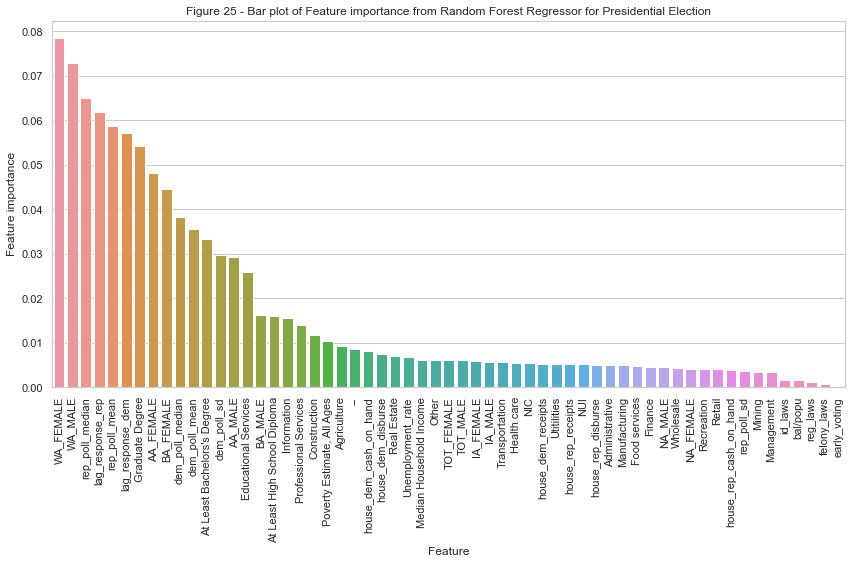

In [77]:
##Plot bar graphs fro random forest feature importance 
feature=pd.DataFrame(best.feature_importances_)
feature=feature.copy()
feature['Feature']=train_pred
feature=feature.sort_values(by=[0], ascending=False)

plt.figure(figsize=(12,8))

ax = sns.barplot(x="Feature", y=0, data=feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 25 - Bar plot of Feature importance from Random Forest Regressor for Presidential Election")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.savefig("pres_feature.png")
plt.show()

Figure 25 - Bar plot of Feature importance from Random Forest Regressor for Presidential Election

In [78]:
#####Use permutation importance to assess feature importance 
from sklearn.inspection import permutation_importance

permutate=permutation_importance(best,Xtrain, ytrain, n_repeats=10, random_state=42)

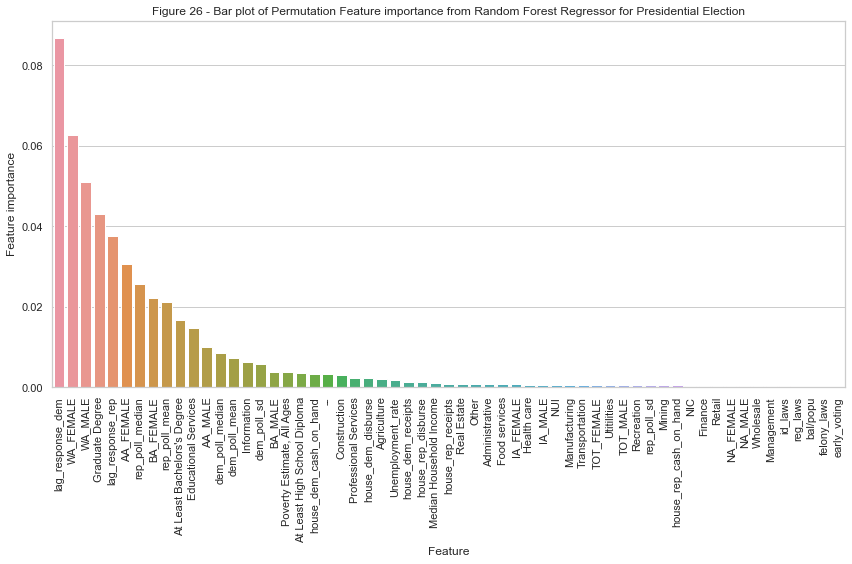

In [79]:
##Plot permutation features 
pfeature=pd.DataFrame(permutate.importances_mean)
pfeature=pfeature.copy()
pfeature['Feature']=train_pred
pfeature=pfeature.sort_values(by=[0], ascending=False)

plt.figure(figsize=(12,8))

ax = sns.barplot(x="Feature", y=0, data=pfeature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 26 - Bar plot of Permutation Feature importance from Random Forest Regressor for Presidential Election")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.savefig("pres_permutation_feature.png")
plt.show()

Figure 26 - Bar plot of Permutation Feature importance from Random Forest Regressor for Presidential Election

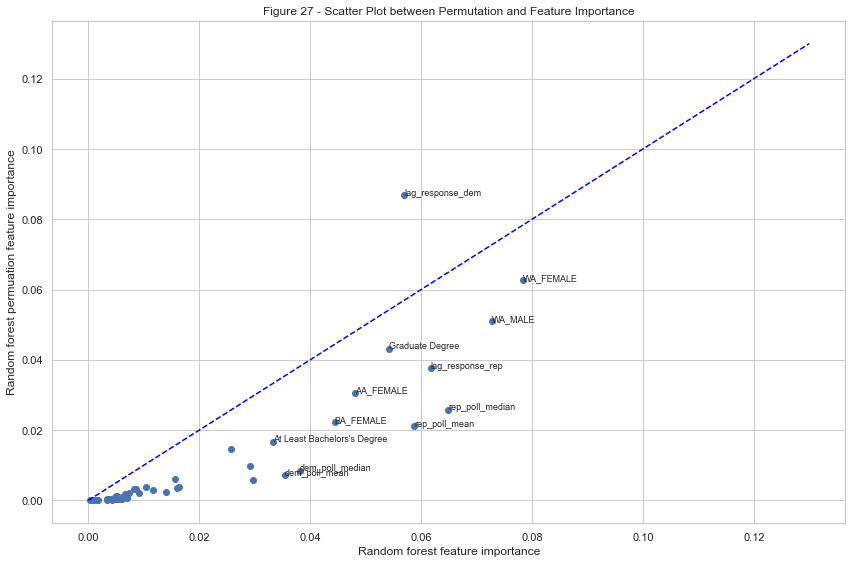

In [80]:
##Scatter plot for concordance bewteen permutation and feature importance
features=feature.merge(pfeature, right_on="Feature", left_on="Feature")
xaxis=features['0_x']
yaxis=features['0_y']
features['label']=features.Feature
features.loc[ (features['0_x']<0.03)  &(features['0_y']<0.03) , 'label']= ""
name=features.label

x=np.linspace(0, 0.13, num=100)
y=np.linspace(0, 0.13, num=100)

plt.figure(figsize=(12,8))
plt.scatter(features['0_x'], features['0_y'])
plt.plot(x, y, '--', color='blue')
plt.xlabel("Random forest feature importance")
plt.ylabel("Random forest permuation feature importance")
for i, txt in enumerate(name):
    plt.annotate(txt, (xaxis[i], yaxis[i]), size=9)

plt.title("Figure 27 - Scatter Plot between Permutation and Feature Importance")
plt.tight_layout()
plt.savefig("feature_imp.png")

Figure 27 - Scatter Plot between Permutation and Feature Importance

In [81]:
####Transform test prediction from county level to state level 
test_prediction=train_pred+["TOT_POP"]

temp=test.drop(test.index[67:71])
test_p=pd.concat([temp['State'], temp['FIPS Code']], axis=1)
test_p.index=temp.index
test_p=pd.concat([test_p,temp[test_prediction] ], axis=1)


In [82]:
###prediction analysis
pred=pd.DataFrame({"Prediction":pres_pred})
pred.index=test_p.index
pres_prediction=pd.concat([pred,test_p], axis=1)
pres_prediction=pres_prediction.copy()

##Aggregate county level vote to state level 
pres_prediction['Prediction Vote']=pres_prediction.Prediction*pres_prediction.TOT_POP
state_vote=pd.DataFrame(pres_prediction.groupby(['State'])['Prediction Vote'].sum())
##Calculate state population 
state_population=pd.DataFrame(pres_prediction.groupby(['State'])['TOT_POP'].sum())
##% votes for state 
state_electoral=state_vote['Prediction Vote']/state_population['TOT_POP']

In [83]:
###From the ratio of democrat and replublican --> predict each party's votes separately 
ratio_dem=[]
ratio_rep=[]
for p in pres_prediction.Prediction:
    ratio_dem.append(p.as_integer_ratio()[0]/(p.as_integer_ratio()[0]+p.as_integer_ratio()[1]))
    ratio_rep.append(p.as_integer_ratio()[1]/(p.as_integer_ratio()[0]+p.as_integer_ratio()[1]))

In [84]:
###Calculate ratio of democrat, republican wins per county
pres_prediction['ratio_dem']=ratio_dem
pres_prediction['ratio_rep']=ratio_rep
###Calculate number of votes winned of democrat, republican per county
pres_prediction['pred_dem_vote']=pres_prediction['ratio_dem']*pres_prediction['TOT_POP']
pres_prediction['pred_rep_vote']=pres_prediction['ratio_rep']*pres_prediction['TOT_POP']

In [85]:
###Aggregate votes per state
state_dem_vote=pd.DataFrame(pres_prediction.groupby(['State'])['pred_dem_vote'].sum())
state_rep_vote=pd.DataFrame(pres_prediction.groupby(['State'])['pred_rep_vote'].sum())

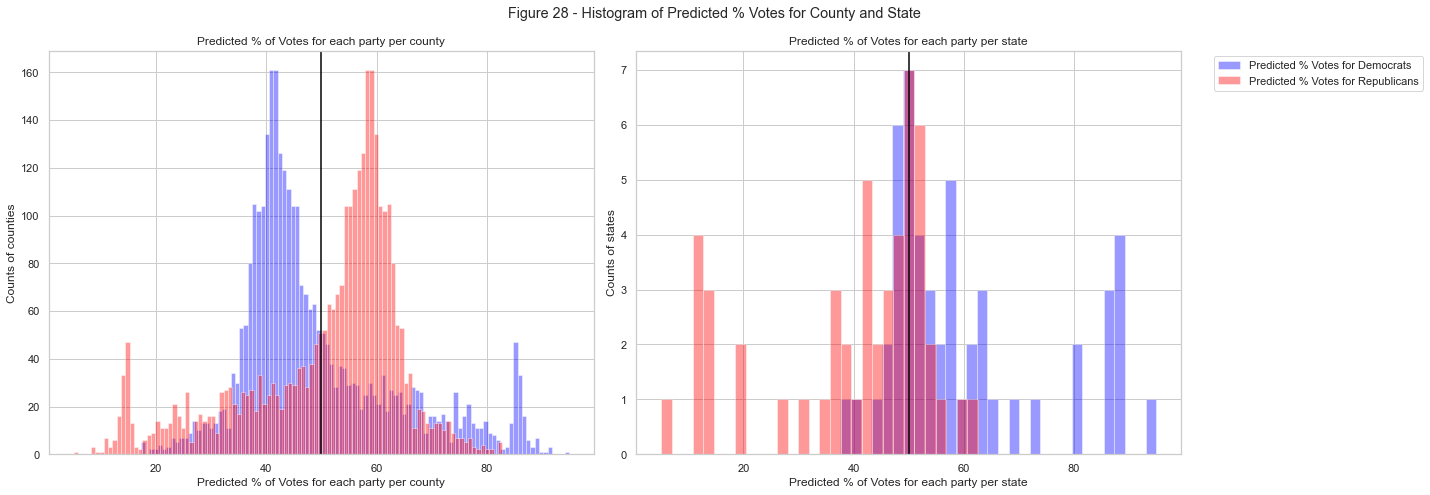

In [86]:
###Distribution of Predicted %votes per county 
perc_dem_state=state_dem_vote.pred_dem_vote/state_population.TOT_POP*100
perc_rep_state=state_rep_vote.pred_rep_vote/state_population.TOT_POP*100


fig, axs = plt.subplots(1, 2, figsize=[20,7])
axs[0].hist(pres_prediction.ratio_dem*100, bins=100,color="blue", alpha=0.4, label="Predicted % Votes for Democrats")
axs[0].hist(pres_prediction.ratio_rep*100, bins=100,color="red", alpha=0.4, label="Predicted % Votes for Republicans")

axs[0].set_title("Predicted % of Votes for each party per county")
axs[0].set_xlabel("Predicted % of Votes for each party per county")
axs[0].axvline(x=50,color="black")
axs[0].set_ylabel("Counts of counties")
#axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()

###Distribution of Predicted %votes per state 
axs[1].hist((perc_dem_state), bins=30,color="blue", alpha=0.4, label="Predicted % Votes for Democrats")
axs[1].hist((perc_rep_state), bins=30,color="red", alpha=0.4, label="Predicted % Votes for Republicans")

axs[1].set_title("Predicted % of Votes for each party per state")
axs[1].set_xlabel("Predicted % of Votes for each party per state")
axs[1].set_ylabel("Counts of states")
axs[1].axvline(x=50,color="black")
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle("Figure 28 - Histogram of Predicted % Votes for County and State")
plt.tight_layout()
plt.savefig("pres_pred.png")
plt.show()

Figure 28 - Histogram of Predicted % Votes for County and State

In [87]:
##state_frame save all predicative values in a dataframe
state_frame=pd.concat([state_dem_vote, state_rep_vote], axis=1)
state_frame['perc_dem_state']=perc_dem_state
state_frame['perc_rep_state']=perc_rep_state
state_frame['state_population']=state_population.TOT_POP
state_frame['election_result']="Biden"
state_frame.loc[state_frame['perc_dem_state']<50,'election_result']="Trump"
state_frame['STATE']=state_frame.index

In [88]:
##read in 2020 election results to compare with prediction
electoral=pd.read_csv("2020_election_results/pres_2020_results.csv")
electoral=electoral.rename(columns={"State":"STATE"})
presidential_prediction=state_frame.merge(electoral, right_on="STATE", left_on="STATE")

In [89]:
###merge this data frame with fips code 
# fmerge=pd.merge(presidential_prediction, test, left_on='STATE',right_on="STNAME")
# fmerge.to_csv("pres_pred_state.csv")

In [90]:
###Final electoral votes
biden=sum(presidential_prediction.loc[presidential_prediction['perc_dem_state']>50 ,'electoral_college'])
trump=sum(presidential_prediction.loc[presidential_prediction['perc_dem_state']<50 ,'electoral_college'])

print("Biden is predicted to win" , biden, "electoral votes")
print("Trump is predicted to win" , trump, "votes")

Biden is predicted to win 449 electoral votes
Trump is predicted to win 89 votes


Estelle's codes end here. Ivan's presidential election scatter plot code should be added here. NN model should be added after .

In [91]:
#pres_prediction.to_csv("presidential_prediction_impute.csv")

In [92]:
election_result = pd.read_csv("2020_election_results/presidential_prediction_state.csv")

In [93]:
election_result.head()

pred_perc_rep = election_result.perc_rep_state
pred_perc_dem = election_result.perc_dem_state

act_perc_rep = election_result.rep_per.values
act_perc_rep = pd.Series(map(lambda x: x[:-1], act_perc_rep)).astype(float)

act_perc_dem = election_result.dem_per.values
act_perc_dem = pd.Series(map(lambda x: x[:-1], act_perc_dem)).astype(float)

In [94]:
election_result.head()

Unnamed: 0  pred_dem_vote  pred_rep_vote  perc_dem_state  perc_rep_state  state_population election_result       STATE  Unnamed: 0.1 dem_candidate   dem_votes dem_per rep_candidate  rep_votes rep_per  electoral_college
0           0   2.353616e+06   2.549569e+06       48.001774       51.998226           4903185           Trump     Alabama             0     Joe Biden     849,648   36.6%  Donald Trump  1,441,168   62.0%                  9
1           1   4.217077e+05   2.791143e+05       60.173291       39.826709            700822           Biden      Alaska             3     Joe Biden     153,778   42.8%  Donald Trump    189,951   52.8%                  3
2           2   4.349999e+06   2.928718e+06       59.763260       40.236740           7278717           Biden     Arizona             6     Joe Biden   1,672,143   49.4%  Donald Trump  1,661,686   49.1%                 11
3           3   1.374421e+06   1.643383e+06       45.543734       54.456266           3017804           Trump    Arkansas             9     Joe Biden     423,932   34.8%  Donald Trump    760,647   62.4%                  6
4           4   2.895376e+07   1.055847e+07       73.277971       26.722029          39512223           Biden  California            12     Joe Biden  11,109,764   63.5%  Donald Trump  6,005,961   34.3%                 55

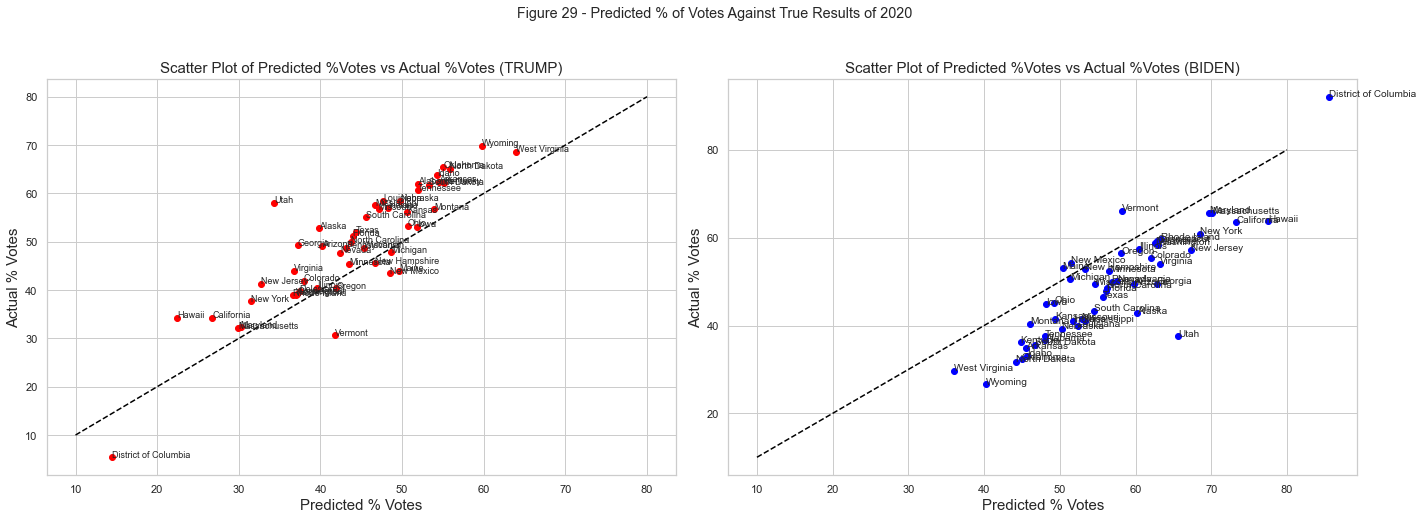

2020 Republican R squared 
0.5476179956913373
2020 Democrats R squared 
0.3520088882351049


In [95]:
x=np.linspace(10, 80, num=100)
y=np.linspace(10, 80, num=100)
name=election_result.STATE

fig, axs = plt.subplots(1, 2, figsize=[20,7])

xaxis=act_perc_rep
yaxis=pred_perc_rep

axs[0].scatter(yaxis, xaxis, color="red")
axs[0].plot(x, y, '--', color='black')
axs[0].set_title("Scatter Plot of Predicted %Votes vs Actual %Votes (TRUMP)", fontsize=15)
axs[0].set_xlabel("Predicted % Votes", fontsize=15)
axs[0].set_ylabel("Actual % Votes", fontsize=15)
for i, txt in enumerate(name):
    axs[0].annotate(txt, (yaxis[i], xaxis[i]), size=9)

dxaxis=act_perc_dem
dyaxis=pred_perc_dem

axs[1].scatter(dyaxis, dxaxis,color="blue")
axs[1].plot(x, y, '--', color='black')
axs[1].set_title("Scatter Plot of Predicted %Votes vs Actual %Votes (BIDEN)", fontsize=15)
axs[1].set_xlabel("Predicted % Votes", fontsize=15)
axs[1].set_ylabel("Actual % Votes", fontsize=15)
for i, txt in enumerate(name):
    axs[1].annotate(txt, (dyaxis[i], dxaxis[i]), size=10)

plt.suptitle("Figure 29 - Predicted % of Votes Against True Results of 2020", y=1.03)
plt.tight_layout()
plt.show()


from sklearn.metrics import r2_score
print("2020 Republican R squared ")
print(r2_score(xaxis, yaxis) )
print("2020 Democrats R squared ")
print(r2_score(dxaxis, dyaxis))

Figure 29 - Predicted % of Votes Against True Results of 2020

## Analysis on 2016 House of Representative Elections

In [96]:
# Reading in data to get house trianing set and mapping from district to county 
house_results = pd.read_csv("train_test_data/house_training_updated.csv")
district_df = pd.read_csv("2016-precinct-house.txt", sep = "\t")

# Subsetting counties and district 
district_df1 = district_df[['state','county_fips', 'district']]

/Applications/anaconda3/envs/cs109a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Missing Counties

In [97]:
# Intializing a dictionary
districts =  {}
counties = 0

# Subsetting required columns
check_districts_df = district_df1[['state', 'district']].dropna()

# Count the number of counties in each state
for state in np.unique(district_df1['state'].values):
    x=len(np.unique(check_districts_df[check_districts_df['state'] == state]['district'].values))
    counties += x 
    districts[state] = x 

# We will not have the Alaskan County after we merge with our training and test sets
counties -= 1

In [98]:
districts

{'Alabama': 7,
 'Alaska': 1,
 'Arizona': 9,
 'Arkansas': 4,
 'California': 53,
 'Colorado': 7,
 'Connecticut': 5,
 'Delaware': 1,
 'District of Columbia': 1,
 'Florida': 26,
 'Georgia': 14,
 'Hawaii': 2,
 'Idaho': 2,
 'Illinois': 18,
 'Indiana': 9,
 'Iowa': 4,
 'Kansas': 4,
 'Kentucky': 6,
 'Louisiana': 6,
 'Maine': 2,
 'Maryland': 8,
 'Massachusetts': 9,
 'Michigan': 14,
 'Minnesota': 8,
 'Mississippi': 4,
 'Missouri': 8,
 'Montana': 1,
 'Nebraska': 3,
 'Nevada': 4,
 'New Hampshire': 2,
 'New Jersey': 12,
 'New Mexico': 3,
 'New York': 27,
 'North Carolina': 13,
 'North Dakota': 1,
 'Ohio': 16,
 'Oklahoma': 4,
 'Oregon': 5,
 'Pennsylvania': 18,
 'Rhode Island': 2,
 'South Carolina': 7,
 'South Dakota': 1,
 'Tennessee': 9,
 'Texas': 35,
 'Utah': 4,
 'Vermont': 1,
 'Virginia': 11,
 'Washington': 10,
 'West Virginia': 3,
 'Wisconsin': 8,
 'Wyoming': 1}

In [99]:
# Calculating missing counties including Alaska
missing = 435 - counties
print(f"There are {missing} counties. After further investigation, there is one from Texas, one from Okalahoma, and one from Florida. None of the seats seem to be favored for one party over the other, so althouhg this is a limitatin but since it is such a small number of seats, we have decided to move on with analysis without them")

There are 3 counties. After further investigation, there is one from Texas, one from Okalahoma, and one from Florida. None of the seats seem to be favored for one party over the other, so althouhg this is a limitatin but since it is such a small number of seats, we have decided to move on with analysis without them


### Back to the Analysis

In [100]:
# Dropping state
district_df1 = district_df1.drop('state', axis=1)

In [101]:
# Merging house_results and district_df1 
house_results = house_results.merge(district_df1, left_on = 'FIPS', right_on = 'county_fips', how = 'left')

# Dropping duplicate rows
house_results = house_results.drop_duplicates()

In [102]:
# Fips that needs to be corrected
fips = [ 1097,  5001,  5003,  5007,  5009,  5011,  5019,  5023,  5027, 5049,  5053,  5055,  5071,  5077,  5081,  5083,  5091,  5099, 5115,  5117,  5123,  5127,  5133,  5135,  5139, 18169]

# Input correct district numbers by fips code
correct_district = [1,1,4,3,3,4,4,1,4,1,4,1,4,1,4,4,4,4,3,1,1,4,4,1,4,2]

# Replace NaN values with correct district
for fips, correct in zip(fips, correct_district):
    house_results.loc[(house_results['FIPS'] == fips), "district"] = correct

In [103]:
# Filling NAs to 0 as NAs implies got 0% of vote
house_results[['Rep%', 'Dem%', 'Other%']] = house_results[['Rep%', 'Dem%', 'Other%']].fillna(0)

# Subsetting
check = house_results[[ 'FIPS', 'district']]

In [104]:
# Dropping unneeded features
drop_features = ['Rep', 'Dem', 'Other_x', 'Green 2016', 'pres_rep_receipts', 'pres_rep_disburse', 'pres_rep_cash_on_hand', 'pres_dem_receipts', 'pres_dem_disburse', 'pres_dem_cash_on_hand', 'senate_rep_receipts', 'senate_rep_disburse', 'senate_rep_cash_on_hand', 'senate_dem_receipts', 'senate_dem_disburse', 'senate_dem_cash_on_hand']
house_results = house_results.drop(drop_features, axis=1)

In [105]:
# Dropping duplicate values
house_results = house_results.dropna()

In [106]:
# Checking to see if filled all missing districts 
check = house_results[['state', 'FIPS', 'district']]
check[check.isna().any(axis=1)]

Empty DataFrame
Columns: [state, FIPS, district]
Index: []

In [107]:
# create the x and y training sets from the house results data
house_results = house_results.rename(columns = {'Unemployment_rate_2016': 'Unemployment_rate', "bal2016/popu2016": 'bal/popu', 'Other_y': 'Other'})

# Sunbsetting train dataset
Xtrain_h = house_results[train_pred]
ytrain_h = house_results[['Rep%', 'Dem%', 'Other%']] / 100

In [108]:
# scale the training data
scaler = StandardScaler().fit(Xtrain_h)
Xtrain_h_s = scaler.transform(Xtrain_h)
ytrain_h = ytrain_h.fillna(0)

In [109]:
# check if there are any holes in the response data
ytrain_h.isna().sum()

Rep%      0
Dem%      0
Other%    0
dtype: int64

### Decision Tree Approach
#### Using a multiclass response variable 

In [110]:
# Defining functin for random forest classification
def calc_meanstd_class(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for depth in depths:
        dtree = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        
        # append train score
        train_scores.append(train_score)
        
        # start cv
        cv = cross_val_score(estimator=dtree, X=X_train, y=y_train, 
                            scoring='accuracy', cv=5)
        
        # append to the means and stds
        cvmeans.append(cv.mean())
        cvstds.append(cv.std())
    
    # transform into np arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores

In [111]:
# Depths
depths = list(range(1,50))

# Initializing the list
ytrain_classes = []

# looping and appending the max values
for r in ytrain_h.values:
    ytrain_classes.append(np.argmax(r))

# Running the function that was created above 
cvmeans_H, cvstds_H, train_scores_H = calc_meanstd_class(Xtrain_h_s, ytrain_classes, depths)

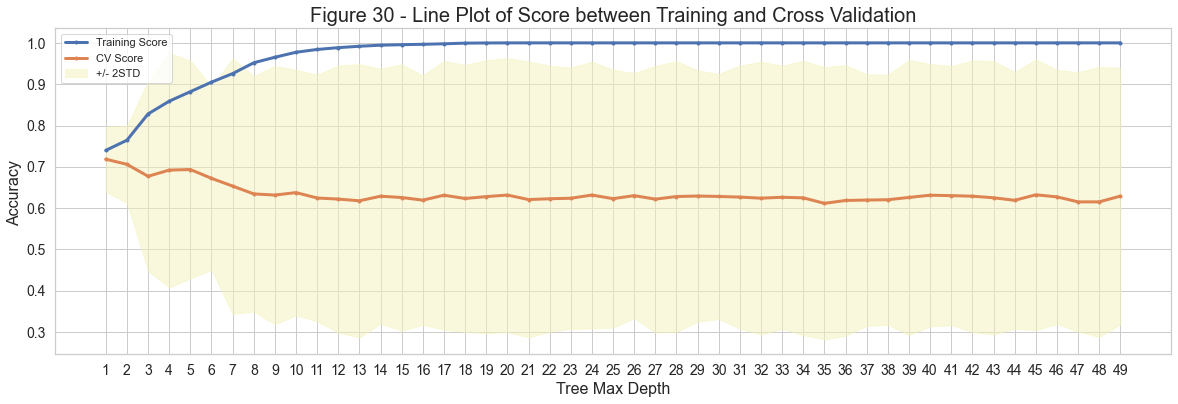

In [112]:
# Intializing subplots
fig, ax = plt.subplots(figsize=(20,6))

# Graphing
ax.plot(depths, train_scores_H, '.-', label='Training Score', lw=3)
ax.plot(depths, cvmeans_H, '.-', label='CV Score', lw=3)
plt.fill_between(depths, cvmeans_H+2*cvstds_H, cvmeans_H-2*cvstds_H, color='#F5F3BB', alpha=0.5, label="+/- 2STD")

# Set ticks and labels
ax.set_xticks(depths)
ax.set_xlabel("Tree Max Depth", fontsize=16)
ax.set_ylabel("Accuracy ", fontsize=16) 
ax.tick_params(labelsize=14)

# Setting legend
ax.legend()

# Setting title
ax.set_title("Figure 30 - Line Plot of Score between Training and Cross Validation", fontsize=20)
plt.show()

Figure 30 - Line Plot of Score between Training and Cross Validation

In [113]:
# Finding best cvmean score
best_cv_H = max(cvmeans_H)

# Finding best depth
best_depth_H = list(cvmeans_H).index(max(cvmeans_H)) +1 

print(f"The best cv score is {best_cv_H}. The best depth is {best_depth_H}.")
print(f"The corresponding training score is {train_scores_H[2]}")

The best cv score is 0.7185415807044525. The best depth is 1.
The corresponding training score is 0.8280659908566885


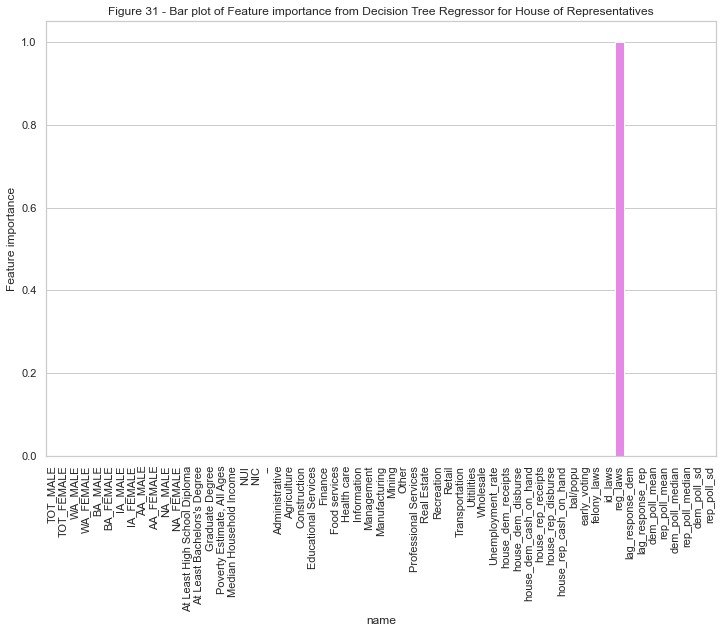

In [114]:
# Feature importance 
# Running decison tree using best_depth to visualize feature importance 
dtree = DecisionTreeRegressor(max_depth=best_depth_H).fit(Xtrain_h_s, ytrain_h)
feature=pd.DataFrame(dtree.feature_importances_)
feature=feature.copy()
feature['name']= train_pred

# Initializing the subplots
plt.figure(figsize=(12,8))

# Plotting
ax = sns.barplot(x="name", y=0, data=feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 31 - Bar plot of Feature importance from Decision Tree Regressor for House of Representatives")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Figure 31 - Bar plot of Feature importance from Decision Tree Regressor for House of Representatives

### Random Forest Approach
#### Using multiclass response variable

In [115]:
########Retune random forest model 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [np.sqrt(len(train_pred)), np.log2(len(train_pred)), 4, 8, 9, 10, 12, 15, 20]
# log 2 
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

#Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
### ADD neg_mean_error
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain_h_s, ytrain_classes)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 14, 24, 33, 43, 52, 62,
                                                      71, 81, 90, 100, None],
                                        'max_features': [7.681145747868608,
                                                         5.882643049361842, 4,
                                                         8, 9, 10, 12, 15, 20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [116]:
# For reproducibility set seed
np.random.seed(42)

# Implementing random forest classifier with best found parameters in random grid search
rf_class_best = RandomForestClassifier(max_depth=5, max_features=4, n_estimators=1000)
rf_class_best.fit(Xtrain_h_s, ytrain_classes)
rf_accuracy = rf_class_best.score(Xtrain_h_s, ytrain_classes)

In [117]:
print(f"The accuracy for the random forest model is {round(rf_accuracy,4)}")

The accuracy for the random forest model is 0.8734


### Neural Network Approach
#### Using a multi proportion response variables: 
\[Republican% per County, Democrats% per County, Other% per County\]

In [118]:
!pip install tensorflow==2.3.1
import tensorflow as tf

In [119]:
# Setting random seed for reproducibility
np.random.seed(42)

# Initialzing the kernel weight
kernel_weight = .01

# Initializng the NN model
NN_model = tf.keras.Sequential(name = 'NN_model')
l2_reg = tf.keras.regularizers.l2(kernel_weight)

# Setting best model 
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Adding layers
NN_model.add(tf.keras.layers.InputLayer(input_shape = (len(train_pred),)))
NN_model.add(tf.keras.layers.Dense(1000, kernel_regularizer=l2_reg, activation = 'relu', name = 'hidden1'))
NN_model.add(tf.keras.layers.Dropout(0.3))
#NN_model.add(tf.keras.layers.Dense(500, kernel_regularizer=l2_reg, activation = 'relu', name = 'hidden2'))
# NN_model.add(tf.keras.layers.Dense(100, kernel_regularizer=l2_reg, activation = 'relu', name = 'hidden3'))

# Adding ouput layer
NN_model.add(tf.keras.layers.Dense(3, activation = 'softmax', name = 'output'))

# Compiling the model
### Try other loss functions 
NN_model.compile(loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer = tf.keras.optimizers.Adam(lr = 0.001))

In [120]:
# Fitting
model = NN_model.fit(Xtrain_h_s, ytrain_h.values, batch_size = 10, epochs = 150, validation_split = .2, callbacks=[mcp_save])

Epoch 1/150
403/403 [==============================] - 1s 2ms/step - loss: 0.1448 - root_mean_squared_error: 0.1983 - val_loss: 0.0645 - val_root_mean_squared_error: 0.2170
Epoch 2/150
403/403 [==============================] - 1s 2ms/step - loss: 0.0491 - root_mean_squared_error: 0.1768 - val_loss: 0.0717 - val_root_mean_squared_error: 0.2279
Epoch 3/150
403/403 [==============================] - 1s 2ms/step - loss: 0.0450 - root_mean_squared_error: 0.1668 - val_loss: 0.0548 - val_root_mean_squared_error: 0.1978
Epoch 4/150
403/403 [==============================] - 1s 2ms/step - loss: 0.0425 - root_mean_squared_error: 0.1637 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2052
Epoch 5/150
403/403 [==============================] - 1s 2ms/step - loss: 0.0424 - root_mean_squared_error: 0.1626 - val_loss: 0.0829 - val_root_mean_squared_error: 0.2595
Epoch 6/150
403/403 [==============================] - 1s 2ms/step - loss: 0.0397 - root_mean_squared_error: 0.1573 - val_loss: 0.0652 

403/403 [==============================] - 1s 2ms/step - loss: 0.0284 - root_mean_squared_error: 0.1379 - val_loss: 0.0592 - val_root_mean_squared_error: 0.2240
Epoch 49/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0277 - root_mean_squared_error: 0.1369 - val_loss: 0.0611 - val_root_mean_squared_error: 0.2285
Epoch 50/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0272 - root_mean_squared_error: 0.1361 - val_loss: 0.0711 - val_root_mean_squared_error: 0.2496
Epoch 51/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0269 - root_mean_squared_error: 0.1350 - val_loss: 0.0608 - val_root_mean_squared_error: 0.2281
Epoch 52/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0268 - root_mean_squared_error: 0.1349 - val_loss: 0.0557 - val_root_mean_squared_error: 0.2169
Epoch 53/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0275 - root_mean_squared_error: 0.1369 - val_loss: 0.0808 - val_r

403/403 [==============================] - 1s 1ms/step - loss: 0.0255 - root_mean_squared_error: 0.1326 - val_loss: 0.0670 - val_root_mean_squared_error: 0.2428
Epoch 96/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0267 - root_mean_squared_error: 0.1358 - val_loss: 0.0660 - val_root_mean_squared_error: 0.2413
Epoch 97/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0279 - root_mean_squared_error: 0.1399 - val_loss: 0.0789 - val_root_mean_squared_error: 0.2648
Epoch 98/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0285 - root_mean_squared_error: 0.1398 - val_loss: 0.0659 - val_root_mean_squared_error: 0.2385
Epoch 99/150
403/403 [==============================] - 1s 2ms/step - loss: 0.0268 - root_mean_squared_error: 0.1353 - val_loss: 0.0652 - val_root_mean_squared_error: 0.2379
Epoch 100/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0280 - root_mean_squared_error: 0.1388 - val_loss: 0.0736 - val_

Epoch 142/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0273 - root_mean_squared_error: 0.1397 - val_loss: 0.0585 - val_root_mean_squared_error: 0.2259
Epoch 143/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0255 - root_mean_squared_error: 0.1336 - val_loss: 0.0595 - val_root_mean_squared_error: 0.2285
Epoch 144/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0270 - root_mean_squared_error: 0.1393 - val_loss: 0.0504 - val_root_mean_squared_error: 0.2063
Epoch 145/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0260 - root_mean_squared_error: 0.1356 - val_loss: 0.0605 - val_root_mean_squared_error: 0.2284
Epoch 146/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0293 - root_mean_squared_error: 0.1441 - val_loss: 0.0697 - val_root_mean_squared_error: 0.2483
Epoch 147/150
403/403 [==============================] - 1s 1ms/step - loss: 0.0265 - root_mean_squared_error: 0.1369 - val_l

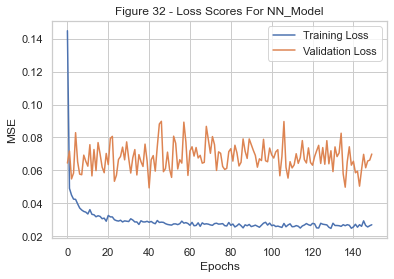

In [121]:
# Setting plots
fig, ax = plt.subplots()

# Graphing the training and validation loss
ax.plot(model.history['loss'], label = 'Training Loss')
ax.plot(model.history['val_loss'], label = 'Validation Loss')

# Setting labels and title
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE")
ax.set_title("Figure 32 - Loss Scores For NN_Model")

# Placing legend
ax.legend()

plt.show()

Figure 32 - Loss Scores For NN_Model

In [122]:
from sklearn.metrics import r2_score

In [123]:
# Loading weights and predicting
NN_model.load_weights('.mdl_wts.hdf5')
ypred_train_nn = NN_model.predict(Xtrain_h_s)

print(r2_score(ytrain_h['Rep%'], ypred_train_nn[:,0]))
print(r2_score(ytrain_h['Dem%'], ypred_train_nn[:,1]))
print(r2_score(ytrain_h['Other%'], ypred_train_nn[:,2]))
print(r2_score(ytrain_h, ypred_train_nn))

0.6772431318920424
0.636042249663403
0.6733309843059148
0.6622054552871198


In [124]:
# County with max percentage wins county
ypred_train_class_nn = [np.argmax(x) for x in ypred_train_nn]

In [125]:
# your code here
# Initializing the model
rf_pred = RandomForestClassifier(max_depth=5, max_features=4, n_estimators=1000)
rf_pred.fit(Xtrain_h_s, ypred_train_class_nn)

# Finding the training and test classification accuracy scores
training_accuracy_rf = rf_pred.score(Xtrain_h_s, ypred_train_class_nn)

# Printing the accuracy scores
print(f"The train accuracy is {training_accuracy_rf}.")

The train accuracy is 0.9487179487179487.


In [126]:
# your code here
# Initializing the model
logreg = LogisticRegression(multi_class = 'multinomial', C=.0001, penalty = "l2", max_iter = 5000)

# Fitting the model
logreg.fit(Xtrain_h_s, ypred_train_class_nn)

# Finding the training and test classification accuracy scores
training_accuracy_logreg = logreg.score(Xtrain_h_s, ypred_train_class_nn)

# Printing the accuracy scores
print(f"The training accuracy for this model is {training_accuracy_logreg}.")

The training accuracy for this model is 0.8137547207314649.


In [127]:
#####Use permutation importance to assess feature importance 
from sklearn.inspection import permutation_importance

In [128]:
# Implementation of permutation importance 
permutation_importance = permutation_importance(logreg, Xtrain_h_s, ypred_train_class_nn, n_jobs=-1, random_state = 42)

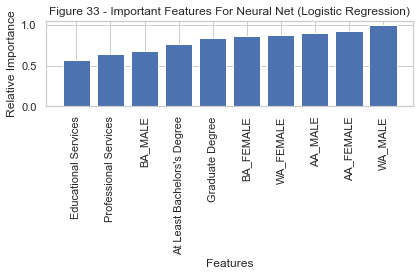

In [129]:
# Initializing a dataframe
df1 = pd.DataFrame()

# Adding the importance results to the dataframe
df1['importance'] = list(permutation_importance['importances_mean'])

# Sorting
df1 = df1.sort_values('importance')

# Subsetting the ten best features
value_importance_df = df1.iloc[-10:]

# Getting the important feature's indexes
idx_importance = list(value_importance_df.index)

# Getting the importance features values
value_importance = value_importance_df.values

# Transforming the name of the important features into a list

list_importance = []
for idx in idx_importance:
    list_importance.append(train_pred[idx])


# Intializing value importance list
value_important = []

# Looping though the important values and appending to list
for i in range(len(value_importance)):
    value_important.append(value_importance[i][0]) 

# Scaling so we get relative importance 
value_important = value_important/max(value_important)

# Making a bar plot
plt.bar(list_importance, value_important)

# Setting the labels and titles
plt.xlabel("Features")
plt.ylabel("Relative Importance")
plt.title("Figure 33 - Important Features For Neural Net (Logistic Regression)")

# Flipping the names of the features 90 degrees
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('nn_feature_impt')

Figure 33 - Important Features For Neural Net (Logistic Regression)

In [130]:
# your code here
# Initializing the model
rf_importance = RandomForestClassifier()

# Fitting the model
rf_importance.fit(Xtrain_h_s, ypred_train_class_nn)

# Finding the training and test classification accuracy scores
training_accuracy_rf = rf_importance.score(Xtrain_h_s, ypred_train_class_nn)

# Printing the accuracy scores
print(f"The training accuracy for this model is {training_accuracy_rf}.")

The training accuracy for this model is 1.0.


In [131]:
# Importing
from sklearn.inspection import permutation_importance

In [132]:
# Calculating permutation importance
permutation_importance = permutation_importance(rf_importance, Xtrain_h_s, ypred_train_class_nn, n_jobs=-1, random_state=42)

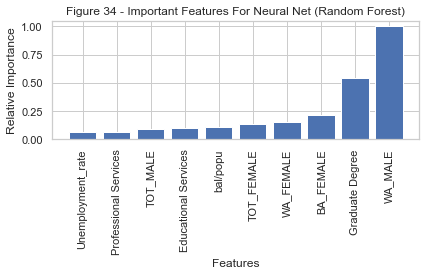

In [133]:
# Initializing a dataframe
df1 = pd.DataFrame()

# Adding the importance results to the dataframe
df1['importance'] = list(permutation_importance['importances_mean'])

# Sorting
df1 = df1.sort_values('importance')

# Subsetting the ten best features
value_importance_df = df1.iloc[-10:]

# Getting the important feature's indexes
idx_importance = list(value_importance_df.index)

# Getting the importance features values
value_importance = value_importance_df.values

# Transforming the name of the important features into a list

list_importance = []
for idx in idx_importance:
    list_importance.append(train_pred[idx])

# Intializing value importance list
value_important = []

# Looping though the important values and appending to list
for i in range(len(value_importance)):
    value_important.append(value_importance[i][0]) 

# Scaling so we get relative importance 
value_important = value_important/max(value_important)

# Making a bar plot
plt.bar(list_importance, value_important)

# Setting the labels and titles
plt.xlabel("Features")
plt.ylabel("Relative Importance")
plt.title("Figure 34 - Important Features For Neural Net (Random Forest)")

# Flipping the names of the features 90 degrees
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('randomforestfeatures.png')

Figure 34 - Important Features For Neural Net (Random Forest)

# Testing on 2020 House of Representatives Data
### Focusing on Random Forest Classification and Nueral Net Model

### Random Forest
#### Has winner take all design due to nature of classification: Winner of county gets all votes in county

In [134]:
# Reading in test data
Xtest_h = pd.read_csv('train_test_data/impute_stand_update_final.csv')
Xtest_h = Xtest_h.drop('Unnamed: 0', axis = 1)

# Reading in total pops data
tot_pops_df = pd.read_csv("county_pops_2019.csv")
tot_pops_df = tot_pops_df.rename(columns={'Fips':"county_fips", '2019 County Population': 'pop'})

In [135]:
# Cleaning the test data
Xtest_h = Xtest_h.rename(columns = {'FIPS Code': 'county_fips'})
Xtest_h = Xtest_h.merge(district_df1, on = 'county_fips', how = 'left')
Xtest_h = Xtest_h.merge(tot_pops_df, on = 'county_fips', how = 'left')
house_merge = house_results[['FIPS','state']].rename(columns = {'FIPS': 'county_fips'})
Xtest_h = Xtest_h.merge(house_merge, on = 'county_fips')

In [136]:
# Dropping duplicate rows
Xtest_h = Xtest_h.drop_duplicates()


# Checking for missing values. These are duplicate counties 
check = Xtest_h[['county_fips', 'state', 'district', 'pop']]
check[check.isna().any(axis=1)]

county_fips           state  district       pop
1               1001         Alabama       NaN   55869.0
105             1073         Alabama       NaN  658573.0
1742            1075         Alabama       NaN   13805.0
1850            1077         Alabama       NaN   92729.0
2015            1079         Alabama       NaN   32924.0
...              ...             ...       ...       ...
8109941        45031  South Carolina       NaN   66618.0
8110363        45029  South Carolina       NaN   37677.0
8111362        45027  South Carolina       NaN   33745.0
8111750        45025  South Carolina       NaN   45650.0
8112080        45033  South Carolina       NaN   30479.0

[184 rows x 4 columns]

In [137]:
# Correct districts
fips = [ 1097,  5001,  5003,  5007,  5009,  5011,  5019,  5023,  5027, 5049,  5053,  5055,  5071,  5077,  5081,  5083,  5091,  5099, 5115,  5117,  5123,  5127,  5133,  5135,  5139, 18169]
correct_district = [1,1,4,3,3,4,4,1,4,1,5,1,4,1,4,4,4,4,3,1,1,4,4,1,4,2]

# Replace NaN values with correct district
for fip, correct in zip(fips, correct_district):
    Xtest_h.loc[(Xtest_h['county_fips'] == fip), "district"] = correct

In [138]:
# Dropping duplicate districts
Xtest_h = Xtest_h.dropna()

In [139]:
# Subestting required columns and checking for NAs
results_df_h_rf = Xtest_h[['county_fips', 'state', 'district', 'pop']]
results_df_h_rf[results_df_h_rf.isna().any(axis=1)]

Empty DataFrame
Columns: [county_fips, state, district, pop]
Index: []

In [140]:
# Getting predictions for rf on test data
rf_preds = rf_class_best.predict(Xtest_h[train_pred])

# Adding reusults to previous dataframe
results_df_h_rf['rf_preds'] = rf_preds
results_df_h_rf.shape

/Applications/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(5030, 5)

In [141]:
results_df_h_rf.head()

county_fips    state  district       pop  rf_preds
0            1001  Alabama       2.0   55869.0         0
95           1073  Alabama       6.0  658573.0         0
97           1073  Alabama       7.0  658573.0         0
1741         1075  Alabama       4.0   13805.0         0
1849         1077  Alabama       5.0   92729.0         0

In [142]:
# Getting absolute votes for each party 
grouped_df_rf = results_df_h_rf.groupby(['state', "district", 'rf_preds']).sum()
grouped_df_rf = grouped_df_rf.drop('county_fips',axis=1)

# Initializing lists
state_list = []
district_list = []
party_list = []

# Looping through and getting state, district, and party 
for i in range(grouped_df_rf.shape[0]):
    state_list.append(grouped_df_rf.index[i][0])
    district_list.append(grouped_df_rf.index[i][1])
    party_list.append(grouped_df_rf.index[i][2])

# Adding list to the dataframe
grouped_df_rf['District'] = district_list
grouped_df_rf['State'] = state_list
grouped_df_rf['Party'] = party_list

In [143]:
# Intializing dict
districts_per_state = {}

# Getting districts in each state
for state in np.unique(grouped_df_rf["State"].values):
    districts_per_state[state] = list(np.unique(grouped_df_rf[grouped_df_rf['State'] == state]['District'].values))

In [144]:
# Initializing a dict
state_won_rf = {}

# Looping through and getting the number of wins by each party in each state
for state in np.unique(grouped_df_rf['State'].values):
    list_temp = []
    for i in districts_per_state[state]:
        if len(grouped_df_rf['pop'][state][i]) == 1:
            list_temp.append(grouped_df_rf['pop'][state][i].index[0])
        else:
            list_temp.append(grouped_df_rf['pop'][state][i].argmax())
    state_won_rf[state] = list_temp

In [145]:
# Caluclating the number of predicted wins 
rep_seats_US_rf = 0
dem_seats_US_rf = 0
other_seats_US_rf = 0
number_seats_state_rf = {}
number_seats_rf = {}

# For each state
for state in np.unique(grouped_df_rf["State"].values):
    # Get number of rep/dem/other predictions
    rep_temp = sum(np.asarray(state_won_rf[state]) == 0)
    dem_temp = sum(np.asarray(state_won_rf[state]) == 1)
    other_temp = sum(np.asarray(state_won_rf[state]) == 2)

    # Add these to a dict
    number_seats_state_rf[state] = [rep_temp, dem_temp, other_temp]

    # Calculating number of seats won by each state in each party 
    rep_seats_US_rf = rep_seats_US_rf + sum(np.asarray(state_won_rf[state]) == 0)
    dem_seats_US_rf= dem_seats_US_rf + sum(np.asarray(state_won_rf[state]) == 1)
    other_seats_US_rf = other_seats_US_rf + sum(np.asarray(state_won_rf[state]) == 2)

In [146]:
print(f"The RF exactly predicts that republicans will win {rep_seats_US_rf}, the democrats will win {dem_seats_US_rf}, and other parties will win {other_seats_US_rf}")

The RF exactly predicts that republicans will win 223, the democrats will win 210, and other parties will win 0


In [147]:
# Intializing dict
state_win_final = {}

# Looping through and getting percentage of distrsicts that we hace that went REP,DEM, OTHER
for state in np.unique(grouped_df_rf['State'].values):
    rep_rf = sum(np.asarray(state_won_rf[state]) == 0) / len(np.asarray(state_won_rf[state]))
    dem_rf = sum(np.asarray(state_won_rf[state]) == 1) / len(np.asarray(state_won_rf[state]))
    if rep_rf + dem_rf == 1:
        other_rf = 0
    else:
        other_rf = 1 - rep_rf - dem_rf
    state_win_final[state] = [rep_rf, dem_rf, other_rf]

# Making a dataframe
state_results_final_df = pd.DataFrame(state_win_final)

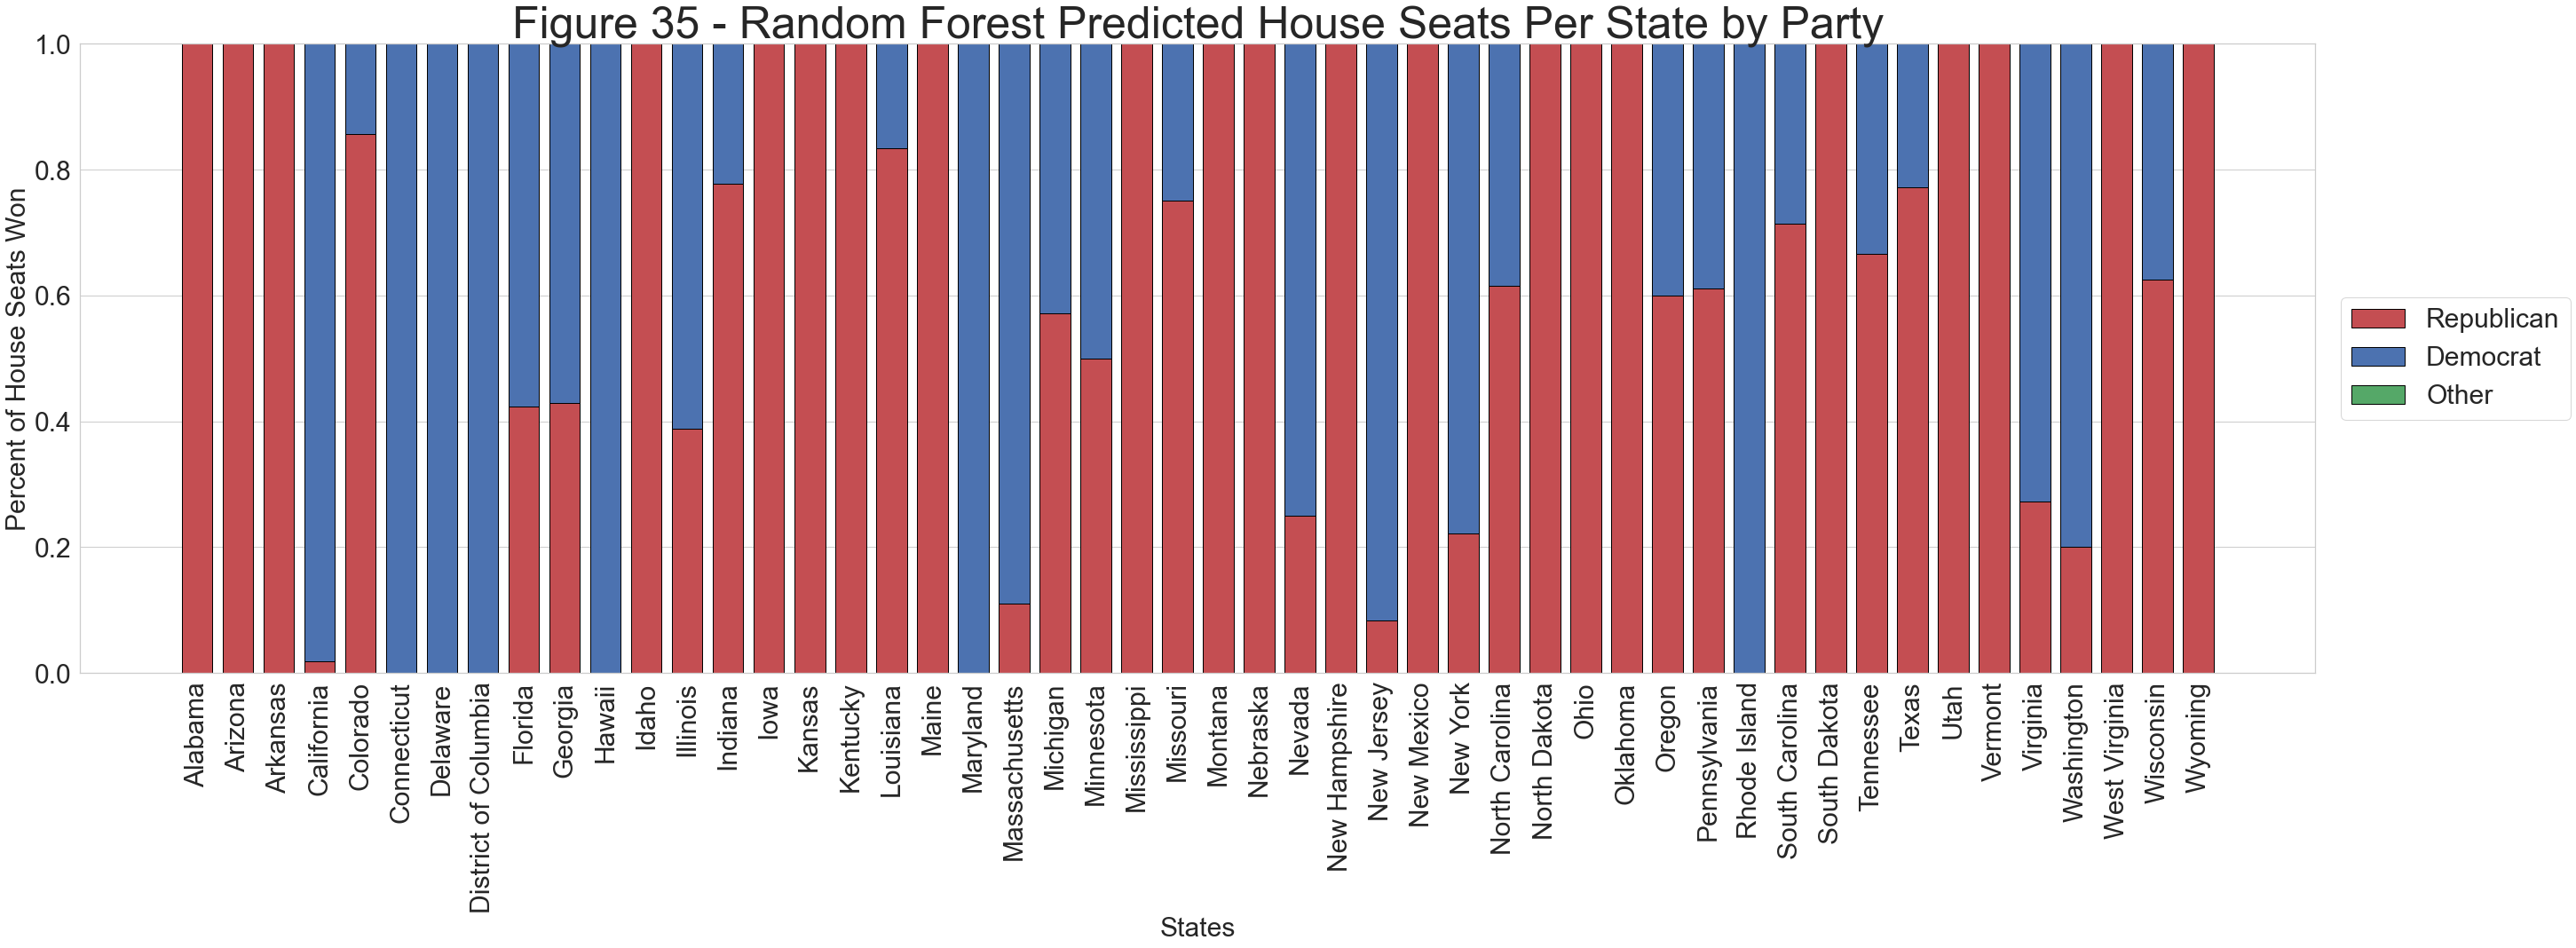

In [148]:
# Setting width
width = 0.75
# Getting labels
labels = state_results_final_df.columns
# Setting x
x = np.arange(len(labels))

# Intializing subplots
fig, ax = plt.subplots(figsize = (40,15))

# Plotting
ax.bar(x, state_results_final_df.iloc[0].values, width, edgecolor ='black', label = 'Republican', color = 'r')
ax.bar(x, state_results_final_df.iloc[1].values, width, edgecolor ='black', label = 'Democrat', color = 'b', bottom = state_results_final_df.iloc[0].values)
ax.bar(x, state_results_final_df.iloc[2].values, width, edgecolor ='black', label = 'Other', color = 'g', bottom = (state_results_final_df.iloc[1].values + state_results_final_df.iloc[0].values))

# Setting labels, legend, and title
ax.set_ylabel('Percent of House Seats Won', fontsize=30)
ax.set_xlabel("States", fontsize=30)
ax.set_title('Figure 35 - Random Forest Predicted House Seats Per State by Party', fontsize=50)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=30)
ax.legend(fontsize=30, loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.xticks(rotation=90)
plt.yticks(fontsize=30)
fig.tight_layout()
# plt.show()
plt.savefig('rf_house_preds.png')

Figure 35 - Random Forest Predicted House Seats Per State by Party

In [149]:
# Extrapolating the number of seats with district data that we have
house_seats = [7, 9, 4, 53, 7, 5, 1, 1, 27, 14, 2, 2, 18, 9, 4, 4, 6, 6, 2, 8, 9, 14, 8, 4, 8, 1, 3, 4, 2, 12, 3, 27, 13, 1, 16, 5, 5, 18, 2, 7, 1, 9, 36, 4, 1, 11, 10, 3, 8, 1]

# Calculate this way to account for the three missing districts
number_rep = [x*y for x,y in zip(house_seats, list(state_results_final_df.iloc[0].values))]
number_dem = [x*y for x,y in zip(house_seats, list(state_results_final_df.iloc[1].values))]
number_other = [x*y for x,y in zip(house_seats, list(state_results_final_df.iloc[2].values))]

print(f"Not including Alaska, the random forest predicts that {round(sum(number_rep))} will go to republicans, {round(sum(number_dem))} will go to democrats, and {round(sum(number_other))} will go to an other pary")

Not including Alaska, the random forest predicts that 224.0 will go to republicans, 211.0 will go to democrats, and 0.0 will go to an other pary


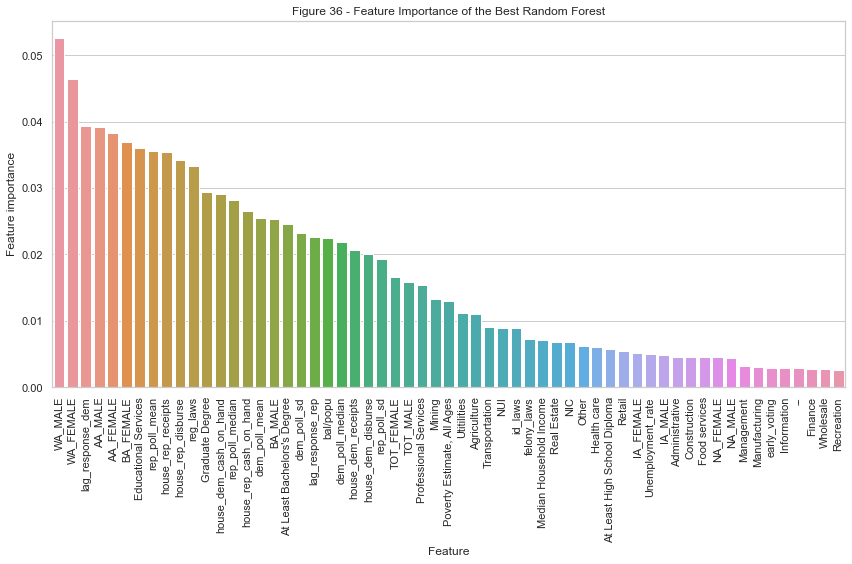

In [150]:
# Getting data frame
feature=pd.DataFrame(rf_class_best.feature_importances_)
# Copying
feature=feature.copy()
# Setting features in dataframe
feature['Feature']= train_pred
# Sorting
feature=feature.sort_values(by=[0], ascending=False)

# Initializing the subplots
plt.figure(figsize=(12,8))

# Plotting
ax = sns.barplot(x="Feature", y=0, data=feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 36 - Feature Importance of the Best Random Forest")
plt.setp(ax.get_xticklabels(), rotation=90)
# plt.show()
plt.tight_layout()
plt.savefig('rf_feature_impt')

Figure 36 - Feature Importance of the Best Random Forest

### NN Model
#### Moving away from the winner take all design

In [151]:
# Loading weights
NN_model.load_weights('.mdl_wts.hdf5')
# Predicting
ypred_test = NN_model.predict(Xtest_h[train_pred])

# Make into a dataframe
ypred_df = pd.DataFrame(ypred_test)

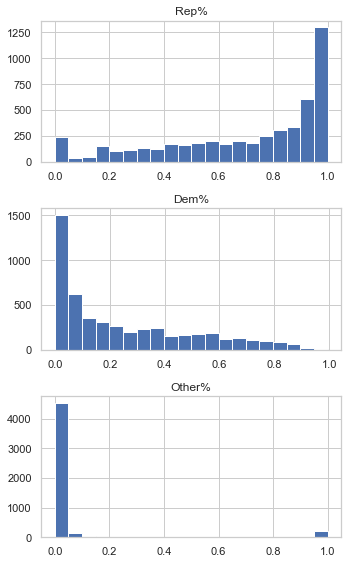

In [152]:
# Intializing subplots
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (5, 8))

# Looping through and plotting 
for i in range(3):
    ax[i].hist(ypred_test[:,i], bins = 20)
    ax[i].set_title(ytrain_h.columns[i])
fig.tight_layout()

In [153]:
ypred_df.head()

0         1             2
0  0.748894  0.250659  4.463175e-04
1  0.302355  0.674005  2.364025e-02
2  0.302355  0.674005  2.364025e-02
3  0.988104  0.011895  7.559912e-07
4  0.717723  0.281636  6.400786e-04

In [154]:

# Getting dataframe with population 
results_df_h_nn = Xtest_h[['county_fips', 'state', 'district', 'pop']]

# Resetting index and dropping index column
results_df_h_nn = results_df_h_nn.reset_index().drop('index', axis=1)

# Adding predictions to dataframe
results_df_h_nn = pd.concat([results_df_h_nn, ypred_df], axis = 1)

In [155]:
# Results head
results_df_h_nn.head()

county_fips    state  district       pop         0         1             2
0         1001  Alabama       2.0   55869.0  0.748894  0.250659  4.463175e-04
1         1073  Alabama       6.0  658573.0  0.302355  0.674005  2.364025e-02
2         1073  Alabama       7.0  658573.0  0.302355  0.674005  2.364025e-02
3         1075  Alabama       4.0   13805.0  0.988104  0.011895  7.559912e-07
4         1077  Alabama       5.0   92729.0  0.717723  0.281636  6.400786e-04

In [156]:
# Multiplying each counties proportion to total county population
results_df_h_nn['preds_rep'] = results_df_h_nn['pop']*results_df_h_nn[0]
results_df_h_nn['preds_dem'] = results_df_h_nn['pop']*results_df_h_nn[1]
results_df_h_nn['preds_other'] = results_df_h_nn['pop']*results_df_h_nn[2]

In [157]:
# Grouping by state and district and summing up predicted absolute votes
grouped_df_nn = results_df_h_nn.groupby(['state', 'district']).sum()

In [158]:
# Resetting index
grouped_df_nn = grouped_df_nn.reset_index()

In [159]:
# Intializing a list
win_district_list = []

# Looping through and getting party that wins in each county
for i in range(grouped_df_nn.shape[0]):
    win_district_list.append(np.argmax(grouped_df_nn.iloc[i][['preds_rep', 'preds_dem','preds_other']].values))

In [160]:
# Adding win to dataframe
grouped_df_nn['won_district'] = win_district_list

# Initialzing a dictionary
perc_state = {}

# Finding percentage of seats that go to each party in each state
for state in np.unique(grouped_df_nn['state'].values):
    win_list_temp = []
    for i in range(3):
        try:
            win_list_temp.append((grouped_df_nn[grouped_df_nn['state'] == state]['won_district'].value_counts().loc[i]) / (len(grouped_df_nn[grouped_df_nn['state'] == state]['won_district'])))
        except:
            win_list_temp.append(0)
    perc_state[state] = win_list_temp

In [161]:
# Making the dictionary into a dataframe
state_won_df_nn = pd.DataFrame(perc_state)

In [162]:
state_won_df_nn.head()

Alabama  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia   Florida   Georgia  Hawaii  Idaho  Illinois   Indiana  Iowa  Kansas  Kentucky  Louisiana  Maine  Maryland  Massachusetts  Michigan  Minnesota  Mississippi  Missouri  Montana  Nebraska  Nevada  New Hampshire  New Jersey  New Mexico  New York  North Carolina  North Dakota  Ohio  Oklahoma  Oregon  Pennsylvania  Rhode Island  South Carolina  South Dakota  Tennessee     Texas  Utah  Vermont  Virginia  Washington  West Virginia  Wisconsin  Wyoming
0  0.571429      0.0       1.0         0.0  0.142857          0.0       0.0                   0.0  0.269231  0.357143     0.0    1.0  0.222222  0.888889   1.0    0.75       1.0   0.833333    0.5       0.0            0.0  0.357143        0.5          0.5     0.875      1.0       1.0    0.25            0.0         0.0    0.333333  0.037037        0.230769           1.0   1.0       1.0     0.2           0.5           0.0        0.428571           1.0   0.666667  0.228571  0.75      0.0  0.272727         0.0            1.0      0.375      1.0
1  0.428571      1.0       0.0         1.0  0.857143          1.0       1.0                   0.0  0.730769  0.642857     1.0    0.0  0.777778  0.111111   0.0    0.00       0.0   0.166667    0.5       1.0            1.0  0.642857        0.5          0.5     0.125      0.0       0.0    0.75            1.0         1.0    0.666667  0.962963        0.769231           0.0   0.0       0.0     0.8           0.5           1.0        0.571429           0.0   0.111111  0.771429  0.25      1.0  0.727273         1.0            0.0      0.625      0.0
2  0.000000      0.0       0.0         0.0  0.000000          0.0       0.0                   1.0  0.000000  0.000000     0.0    0.0  0.000000  0.000000   0.0    0.25       0.0   0.000000    0.0       0.0            0.0  0.000000        0.0          0.0     0.000      0.0       0.0    0.00            0.0         0.0    0.000000  0.000000        0.000000           0.0   0.0       0.0     0.0           0.0           0.0        0.000000           0.0   0.222222  0.000000  0.00      0.0  0.000000         0.0            0.0      0.000      0.0

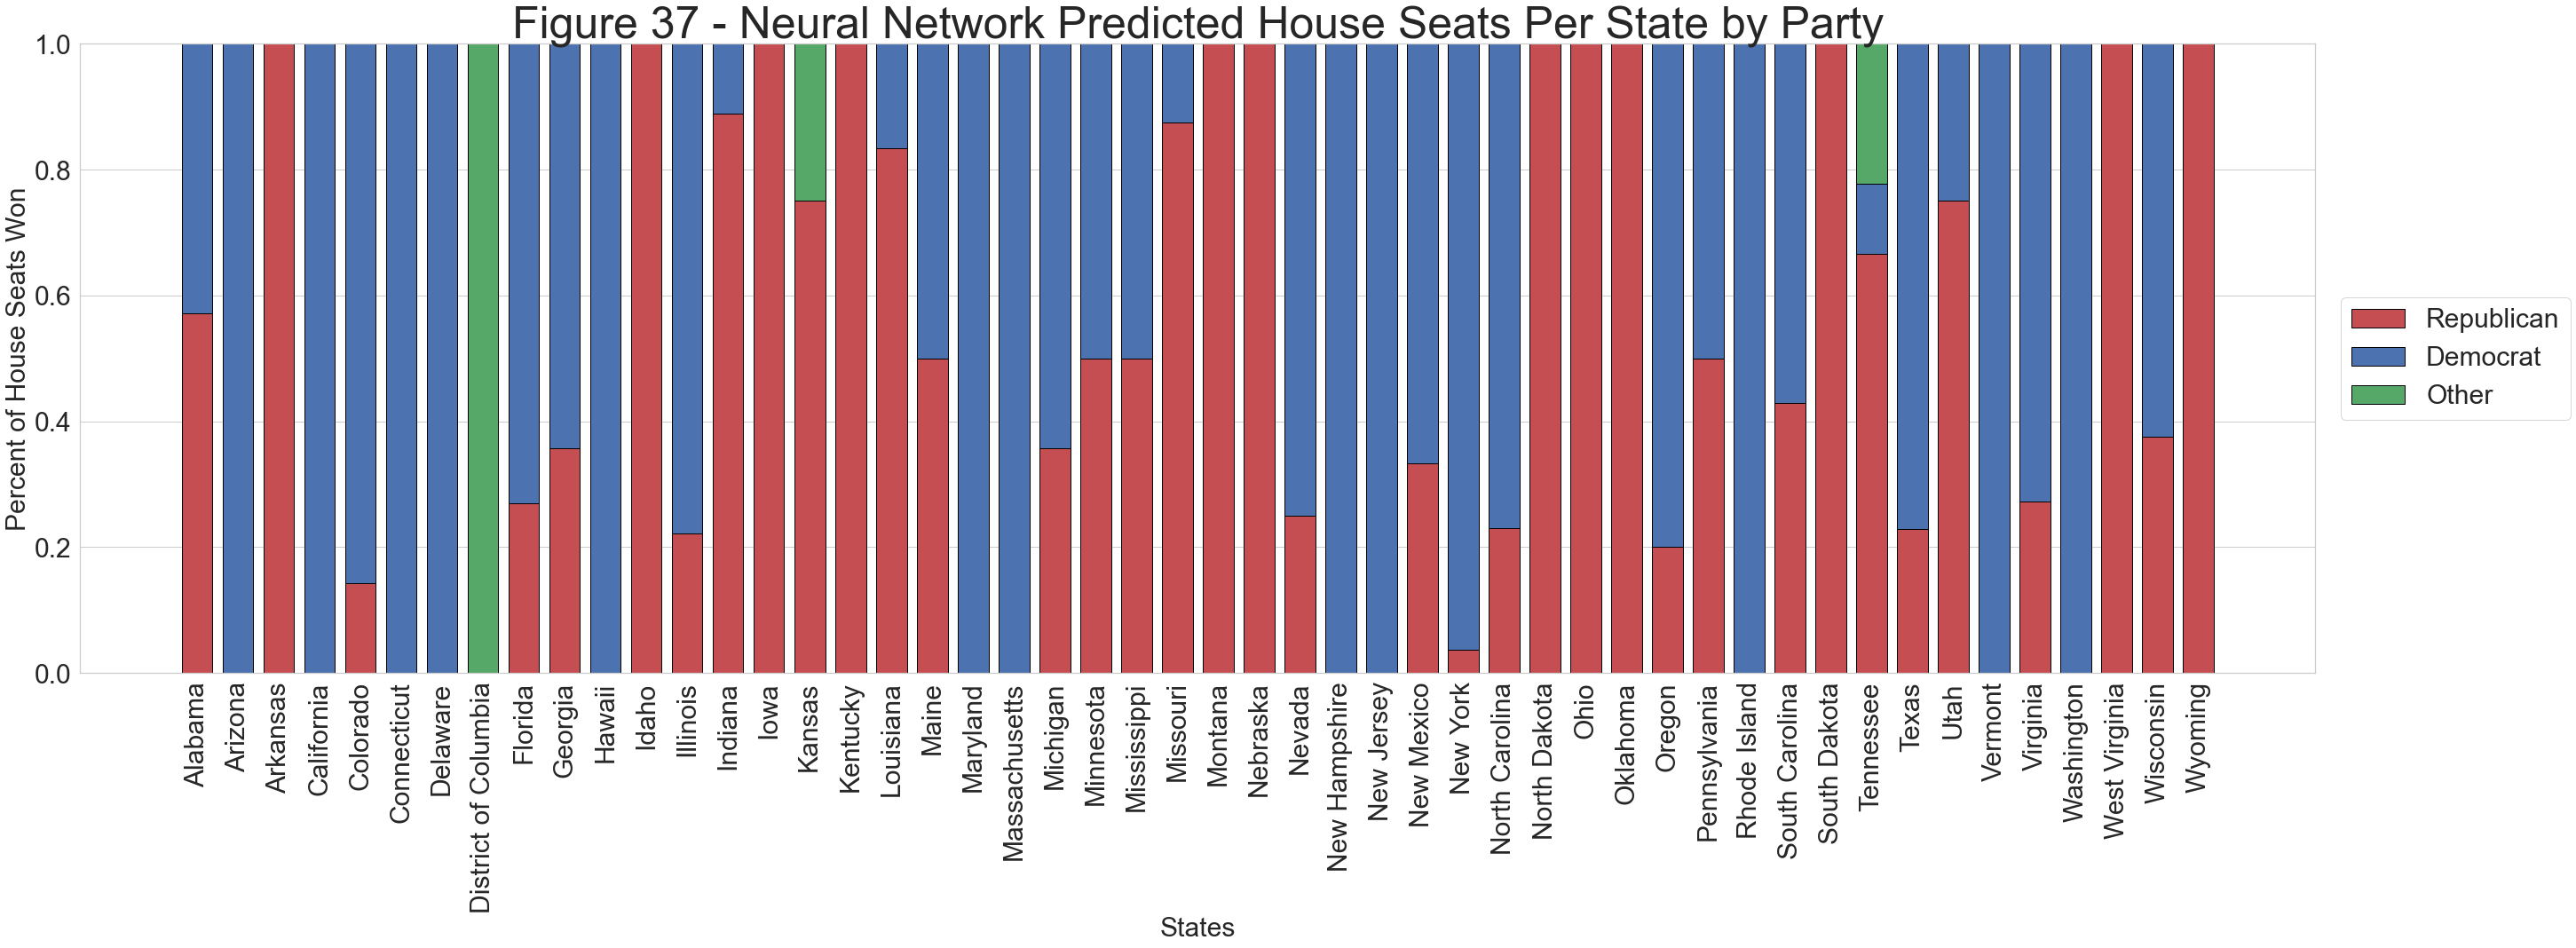

In [163]:
# Setting width
width = 0.75

# Setting labels and
labels = state_won_df_nn.columns
x = np.arange(len(labels))

# Initialzing the subplot
fig, ax = plt.subplots(figsize = (40,15))

# Plotting
ax.bar(x, state_won_df_nn.iloc[0].values, width, edgecolor ='black', label = 'Republican', color = 'r')
ax.bar(x, state_won_df_nn.iloc[1].values, width, edgecolor ='black', label = 'Democrat', color = 'b', bottom = state_won_df_nn.iloc[0].values)
ax.bar(x, state_won_df_nn.iloc[2].values, width, edgecolor ='black', label = 'Other', color = 'g', bottom = (state_won_df_nn.iloc[1].values + state_won_df_nn.iloc[0].values))

# Setting label, title and ticks
ax.set_ylabel('Percent of House Seats Won', fontsize=30)
ax.set_xlabel("States", fontsize=30)
ax.set_title('Figure 37 - Neural Network Predicted House Seats Per State by Party', fontsize=50)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=30)
ax.legend(fontsize=30, loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.xticks(rotation=90)
plt.yticks(fontsize=30)

# Tight layout
fig.tight_layout()

# Saving out
plt.savefig('nn_house_preds')

Figure 37 - Neural Network Predicted House Seats Per State by Party

In [164]:
house_seats = [7, 9, 4, 53, 7, 5, 1, 1, 27, 14, 2, 2, 18, 9, 4, 4, 6, 6, 2, 8, 9, 14, 8, 4, 8, 1, 3, 4, 2, 12, 3, 27, 13, 1, 16, 5, 5, 18, 2, 7, 1, 9, 36, 4, 1, 11, 10, 3, 8, 1]

# Calculate this way to account for the three missing districts
number_rep = [x*y for x,y in zip(house_seats, list(state_won_df_nn.iloc[0].values))]
number_dem = [x*y for x,y in zip(house_seats, list(state_won_df_nn.iloc[1].values))]
number_other = [x*y for x,y in zip(house_seats, list(state_won_df_nn.iloc[2].values))]

print(f"Not including Alaska, the random forest predicts that {round(sum(number_rep))} will go to republicans, {round(sum(number_dem))} will go to democrats, and {round(sum(number_other))} will go to an other pary")

Not including Alaska, the random forest predicts that 145.0 will go to republicans, 286.0 will go to democrats, and 4.0 will go to an other pary


### Feature Importances Extra (For Learning Exposure)

In [165]:
!pip install lime==0.2.0.1

In [166]:
# Importing
import lime
from lime.lime_tabular import LimeTabularExplainer

In [167]:
# Predicting on Xtrain for feature importance to keep it consistent with previous feature importances 
NN_model.predict_proba(Xtrain_h_s)

Instructions for updating:
Please use `model.predict()` instead.


array([[0.6696951 , 0.32747424, 0.00283068],
       [0.6992569 , 0.2968351 , 0.00390795],
       [0.49229133, 0.5061054 , 0.00160321],
       ...,
       [0.12404753, 0.01087486, 0.8650777 ],
       [0.5638006 , 0.07167667, 0.36452284],
       [0.38733268, 0.02026115, 0.5924062 ]], dtype=float32)

In [168]:
# Run LimeTabularExplainer
explainer = LimeTabularExplainer(Xtrain_h_s,
                                 feature_names=Xtrain_h.columns,
                                 mode='regression')
# Selecting index
idx = 132

# Running explain_instance
exp = explainer.explain_instance(Xtrain_h_s[idx], 
                                 NN_model.predict, 
                                 num_features = 10)#X_train.values[idx].size)

# Printing information
print('Observation #: %d' % idx)
print('Probability =', NN_model.predict(Xtrain_h_s)[idx][1])
print('True class: %s' % ytrain_h['Dem%'].iloc[idx])

Observation #: 132
Probability = 0.3195478
True class: 0.0


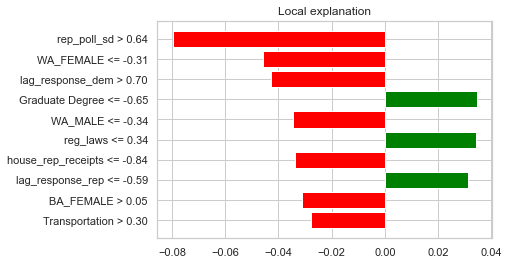

In [169]:
# Plotting
exp.as_pyplot_figure();

Figure 38 - Feature Importance Explained by Lime Package

### Thank you for your time!!! :)